# Setup

## Environment

In [1]:
!pip -q install plotly dash
!pip install seaborn
!pip install statsmodels
!pip install scikit-learn

In [2]:
from IPython.display import display
from modules.quicklook.src.analyze_time_series import AnalyzeTimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew, kurtosis, mode
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.mixture import GaussianMixture
import time
from datetime import datetime
%matplotlib inline
import sqlite3

import plotly.express as px
import plotly.graph_objects as go
from dash import Dash, dcc, html, Input, Output, callback_context, State, no_update, ctx
import plotly.subplots as sp
from dash.dependencies import Input, Output, State
import socket

In [3]:
pd.set_option('display.max_rows', None)  # Set to None to display all rows
pd.set_option('display.max_columns', None)  # Set to None to display all columns

## Define Helper Functions

### Miscellaneous

In [4]:
# define a function to return a free port on the system for running the Dash app
def find_free_port():
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.bind(('', 0))  # bind to a free port provided by the host.
    port = s.getsockname()[1]  # return the port number assigned.
    s.close()
    return port

### Data acquisition

In [5]:
# define a function to return the column names from the timeseries database
def get_column_names(db_path, table_name='kpfdb', show_schema='no'):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute(f"PRAGMA table_info('{table_name}');")
    columns_info = cursor.fetchall()
    
    col_names = [col[1] for col in columns_info] # extract column names from the column information
    if show_schema.lower() == 'yes':
        print(f"Schema of {table_name}:")
        for i, col in enumerate(columns_info):
            print(f"{i}: {col[1]}")
        print("\n")  # Print a newline for better separation
    
    conn.close()
    
    return col_names

In [6]:
# define a function to run a query on a tsdb object and return the results as a dataframe
def jsm_kpf_query(query, tsdb):
    conn = sqlite3.connect(tsdb.db_path)
    cursor = conn.cursor()
    results_df = pd.read_sql_query(query, conn)
    conn.close()
    
    return results_df

In [7]:
# define a function to perform filtering based on qc flags
def filter_qc(df, mode=None):
    qc_columns = ['NOTJUNK', 'GOODREAD', 'OLDBIAS', 'OLDDARK', 'OLDFLAT', 'WLSL1', 'LFCSAT', 'TIMCHKL0', 'TIMCHKL2', 'DATAPRL0', 
                  'DATAPRL1', 'DATAPRL2', 'DATAPR2D', 'CAHKPRL1', 'CAHKPR2D', 'KWRDPRL0', 'LFC2DFOK', 'EMSAT', 'EMNEG', 'LOWBIAS', 
                  'LOWDARK', 'POS2DSNR', 'MONOTWLS', 'GREEN', 'RED', 'CA_HK', 'EXPMETER', 'GUIDE', 'FFFB'
    ]

    # Print value_counts for each column
    for column in qc_columns:
        print(f"Value counts for {column}:")
        print(df[column].value_counts())
        print()  # To add an empty line for better readability

    if mode == None:
        return df
    elif mode == 'basic_strict':
        return df[
            (df['NOTJUNK'] == 1) #& (df['GOODREAD'] == 1)
        ]
    elif mode == 'some_relaxed':
        return df[
            (df['NOTJUNK'] != 0) & 
            (df['GOODREAD'] != 0) & # currently, all values are None
            (df['LFCSAT'] != 0) &
            (df['LFC2DFOK'] != 0)
        ]
    elif mode == 'some_strict':
        return df[
            (df['NOTJUNK'] == 1) & 
            (df['GOODREAD'] == 1) &
            (df['LFCSAT'] == 1) &
            (df['LFC2DFOK'] == 1)
        ]
    elif mode == 'all_relaxed':
        return df[
            (df['NOTJUNK'] != 0) & 
            (df['GOODREAD'] != 0) & 
            (df['LFCSAT'] != 0) &
            (df['EMSAT'] != 0) & 
            (df['EMNEG'] != 0) & 
            (df['LOWBIAS'] != 0) & 
            (df['LOWDARK'] != 0) & 
            (df['LFC2DFOK'] != 0) & 
            (df['OLDBIAS'] != 0) & 
            (df['OLDDARK'] != 0) & 
            (df['OLDFLAT'] != 0) &
            #(df['FFFB'] != 'No') & # nearly all records are "No"
            #(df['EXPMETER'] != 'NO') & # nearly all records are "NO"
            (df['GREEN'] != 'NO')
            (df['RED'] != 'NO')
        ]
    elif mode == 'all_strict':
        return df[
            (df['NOTJUNK'] == 1) & 
            (df['GOODREAD'] == 1) & 
            (df['LFCSAT'] == 1) & 
            (df['EMSAT'] == 1) & 
            (df['EMNEG'] == 1) & 
            (df['LOWBIAS'] == 1) & 
            (df['LOWDARK'] == 1) & 
            (df['LFC2DFOK'] == 1) & 
            (df['OLDBIAS'] == 1) & 
            (df['OLDDARK'] == 1) & 
            (df['OLDFLAT'] == 1) &
            #(df['FFFB'] == 'Yes') & # nearly all records are "No"
            #(df['EXPMETER'] == 'YES') & # nearly all records are "NO"
            (df['GREEN'] == 'YES')
            (df['RED'] == 'YES')
        ]
    else:
        raise ValueError("invalid mode specified")

In [8]:
def make_object_dummies(df, feature_cols_qc):
    # Create dummy variables for 'OBJECT'
    object_dummies = pd.get_dummies(df['OBJECT'], prefix='OBJECT')

    # Concatenate these new columns to the original DataFrame
    df = pd.concat([df, object_dummies], axis=1)

    # Add the dummy variables to the list of qc features
    feature_cols_qc = feature_cols_qc + object_dummies.columns.tolist()
    
    return df, feature_cols_qc

### Plots

In [9]:
# define a function to plot the distributions of radial velocity values
def plot_rv_value_histograms(df, subtitle='unspecified details', cam_col='CCD1'):

    plt.figure(figsize=(10, 6))

    plt.hist(df[cam_col + 'RV1'].dropna(), bins=50, alpha=0.5, label=cam_col + 'RV1', color='purple', density=True)
    plt.hist(df[cam_col + 'RV2'].dropna(), bins=50, alpha=0.5, label=cam_col + 'RV2', color='green', density=True)
    plt.hist(df[cam_col + 'RV3'].dropna(), bins=50, alpha=0.5, label=cam_col + 'RV3', color='red', density=True)
    #plt.hist(df[cam_col + 'RVC'].dropna(), bins=50, alpha=0.5, label=cam_col + 'RVC', color='blue', density=True)
    plt.hist(df[cam_col + 'RV'].dropna(), bins=50, alpha=0.5, label=cam_col + 'RV', color='black', density=True)

    plt.xlabel('RV (m/s)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Radial Velocity Values' + '\n' + subtitle)
    plt.legend()
    plt.grid(True)
    plt.show()


In [10]:
# define a function to plot the distributions of radial velocity errors
def plot_rv_error_histograms(df, subtitle='unspecified details', cam_col='CCD1'):

    plt.figure(figsize=(10, 6))

    plt.hist(df[cam_col + 'ERV1'].dropna(), bins=50, alpha=0.5, label=cam_col + 'ERV1', color='purple', density=True)
    plt.hist(df[cam_col + 'ERV2'].dropna(), bins=50, alpha=0.5, label=cam_col + 'ERV2', color='green', density=True)
    plt.hist(df[cam_col + 'ERV3'].dropna(), bins=50, alpha=0.5, label=cam_col + 'ERV3', color='red', density=True)
    #plt.hist(df[cam_col + 'ERVC'].dropna(), bins=50, alpha=0.5, label=cam_col + 'ERVC', color='blue', density=True)
    plt.hist(df[cam_col + 'ERV'].dropna(), bins=50, alpha=0.5, label=cam_col + 'ERV', color='black', density=True)


    plt.xlabel('RV Error (m/s)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Radial Velocity Errors' + '\n' + subtitle)
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:
"""# define a function to make a Scatter plot of RV values and RV errors, for each fiber in CCD1
def plot_rv_error_scatter_by_fiber(df, xmin, xmax, ymin, ymax, subtitle='unspecified details', cam_col='CCD1'):

    plt.figure(figsize=(10, 6))
    plt.scatter(df[cam_col + 'RV'], df[cam_col + 'ERV'], color='black', label=cam_col + '-Mean', alpha=0.5)
    plt.scatter(df[cam_col + 'RV1'], df[cam_col + 'ERV1'], color='purple', label=cam_col + 'ERV1', alpha=0.5)
    plt.scatter(df[cam_col + 'RV2'], df[cam_col + 'ERV2'], color='green', label=cam_col + 'ERV2', alpha=0.5)
    plt.scatter(df[cam_col + 'RV3'], df[cam_col + 'ERV3'], color='red', label=cam_col + 'ERV3', alpha=0.5)

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    plt.xlabel('RV (m/s)')
    plt.ylabel('Error in RV (m/s)')
    plt.title('Correlation Between ' + cam_col + ' Radial Velocity Values and Errors, by Fiber' + '\n' + subtitle)
    plt.legend()
    plt.grid(True)
    plt.show()"""
    
# define a function to make an interactive Scatter plot overlaying RV Errors vs. RV Values
def plot_rv_error_vs_rv_value_overlay(df, subtitle='unspecified details', cam_col='CCD1', hover_details=['ObsID', 'OBJECT', 'day_num']):
    app = Dash(__name__) # create the Dash app
    fig = go.Figure() # define the figure using Plotly

    # add traces for each fiber
    fibers = [cam_col + 'RV', cam_col + 'RV1', cam_col + 'RV2', cam_col + 'RV3']
    colors = ['black', 'purple', 'green', 'red']
    for fiber, color in zip(fibers, colors):
        fig.add_trace(go.Scatter(
            x=df[fiber],
            y=df[f'{fiber.replace("RV", "ERV")}'],
            mode='markers',
            marker=dict(color=color),
            name=f'{fiber}',
            customdata=df[hover_details],
            hovertemplate="<br>".join([f"{hd}: %{{customdata[{i}]}}" for i, hd in enumerate(hover_details)]) + f"<br>x: %{{x}}<br>y: %{{y}}"
        ))

    fig.update_layout(title='RV Error vs. RV Value, by Fiber: ' + subtitle, 
                      xaxis_title='RV (m/s)',
                      yaxis_title='Error in RV (m/s)')

    # define callback for updating layout on click and print it to console
    @app.callback(
        Output('graph', 'figure'),
        Input('graph', 'clickData'),
        State('graph', 'figure'),
        prevent_initial_call=True
    )
    
    def display_click_data(clickData, existing_figure):
        if clickData: # extract the data to be printed from the customdata
            obs_id = clickData['points'][0]['customdata'][0] # find the index of 'ObsID'
            print(f"'{obs_id}',")  # print only ObsID to the console
            details = clickData['points'][0]['customdata']
            details_str = "<br>".join([f"{hover_details[i]}: {details[i]}" for i in range(len(hover_details))])
            fig = go.Figure(existing_figure) # create a copy of the existing figure to modify
            # add the annotation for the clicked point
            fig.add_annotation(x=clickData['points'][0]['x'],
                               y=clickData['points'][0]['y'],
                               text=details_str,
                               showarrow=True,
                               arrowhead=1,
                               ax=0,
                               ay=-40)
            return fig
        return no_update  # use no_update imported from dash

    app.layout = html.Div([dcc.Graph(id='graph', figure=fig)]) # set up the layout of the app with the output area

    port = find_free_port() # find a free port and run the server
    app.run(debug=False, port=port)  # set debug=False for production use

In [12]:
# define a function to plot the RV values, along with their errors, from the Green CCD over time
def plot_time_trends(df, xmin, xmax, ymin, ymax, subtitle='unspecified details', cam_col='CCD1'):
    
    # make figure and axes grid
    fig, axs = plt.subplots(3, 3, figsize=(15, 9))  # 3 rows, 2 columns
    axs = axs.flatten()  # flatten the 2d array of axes to simplify indexing

    # plot at (0, 0)
    axs[0].plot(df['day_num'], df[cam_col+'RV'], label=cam_col+'RV', color='black', linewidth=4)
    axs[0].plot(df['day_num'], df[cam_col+'RV1'], label=cam_col+'RV1', color='purple')
    axs[0].plot(df['day_num'], df[cam_col+'RV2'], label=cam_col+'RV2', color='green')
    axs[0].plot(df['day_num'], df[cam_col+'RV3'], label=cam_col+'RV3', color='red')
    axs[0].set_xlabel('Day Number')
    axs[0].set_ylabel('Radial Velocity (m/s)')
    axs[0].set_title(f"{cam_col} Radial Velocities Over Time" + '\n' + subtitle)
    axs[0].legend()
    axs[0].grid(True)

    # plot at (0, 1)
    axs[1].plot(df['day_num'], df[cam_col+'RV'], label=cam_col+'RV', color='black', linewidth=4)
    axs[1].plot(df['day_num'], df[cam_col+'RV1'], label=cam_col+'RV1', color='purple')
    axs[1].plot(df['day_num'], df[cam_col+'RV2'], label=cam_col+'RV2', color='green')
    axs[1].plot(df['day_num'], df[cam_col+'RV3'], label=cam_col+'RV3', color='red')
    axs[1].set_xlim(0, 4)
    #axs[1].set_ylim(-150, 150)
    axs[1].set_xlabel('Day Number')
    axs[1].set_ylabel('Radial Velocity (m/s)')
    axs[1].set_title(f"{cam_col} Radial Velocities Over Time" + '\n' + subtitle)
    axs[1].legend()
    axs[1].grid(True)

    # plot at (0, 2)
    axs[2].plot(df['day_num'], df[cam_col+'RV'], label=cam_col+'RV', color='black', linewidth=4)
    axs[2].plot(df['day_num'], df[cam_col+'RV1'], label=cam_col+'RV1', color='purple')
    axs[2].plot(df['day_num'], df[cam_col+'RV2'], label=cam_col+'RV2', color='green')
    axs[2].plot(df['day_num'], df[cam_col+'RV3'], label=cam_col+'RV3', color='red')
    axs[2].set_xlim(xmin, xmax)
    axs[2].set_ylim(ymin, ymax)
    axs[2].set_xlabel('Day Number')
    axs[2].set_ylabel('Radial Velocity (m/s)')
    axs[2].set_title(f"{cam_col} Radial Velocities Over Time" + '\n' + subtitle)
    axs[2].legend()
    axs[2].grid(True)
    
    # compute the upper and lower bounds for the error region
    df[cam_col+'RV_upper'] = df[cam_col+'RV'] + df[cam_col+'ERV']
    df[cam_col+'RV_lower'] = df[cam_col+'RV'] - df[cam_col+'ERV']

    # plot at (1,0)
    axs[3].plot(df['day_num'], df[cam_col+'RV'], label=cam_col+'RV', color='black')
    axs[3].fill_between(df['day_num'], df[cam_col+'RV_lower'], df[cam_col+'RV_upper'], color='black', alpha=0.3, label=f"Error ({cam_col}ERV)")
    axs[3].set_xlabel('Day Number')
    axs[3].set_ylabel(f"{cam_col} RV Value (m/s)")
    axs[3].set_title(f"{cam_col} RV Over Time with Error Shading" + '\n' + subtitle)
    axs[3].legend()
    axs[3].grid(True)
    
    # plot at (1,1)
    axs[4].plot(df['day_num'], df[cam_col+'RV'], label=cam_col+'RV', color='black')
    axs[4].fill_between(df['day_num'], df[cam_col+'RV_lower'], df[cam_col+'RV_upper'], color='black', alpha=0.3, label=f"Error ({cam_col}ERV)")
    axs[4].set_xlim(0, 4)
    #axs[4].set_ylim(-150, 150)
    axs[4].set_xlabel('Day Number')
    axs[4].set_ylabel(f"{cam_col} RV Value (m/s)")
    axs[4].set_title(f"{cam_col} RV Over Time with Error Shading" + '\n' + subtitle)
    axs[4].legend()
    axs[4].grid(True)

    # plot at (1,2)
    axs[5].plot(df['day_num'], df[cam_col+'RV'], label=cam_col+'RV', color='black')
    axs[5].fill_between(df['day_num'], df[cam_col+'RV_lower'], df[cam_col+'RV_upper'], color='black', alpha=0.3, label=f"Error ({cam_col}ERV)")
    axs[5].set_xlim(xmin, xmax)
    axs[5].set_ylim(ymin, ymax)
    axs[5].set_xlabel('Day Number')
    axs[5].set_ylabel(f"{cam_col} RV Value (m/s)")
    axs[5].set_title(f"{cam_col} RV Over Time with Error Shading" + '\n' + subtitle)
    axs[5].legend()
    axs[5].grid(True)

    # plot at (2,0)
    axs[6].plot(df['day_num'], df[cam_col+'ERV'], label=cam_col+'ERV', color='black', linewidth=4)
    axs[6].plot(df['day_num'], df[cam_col+'ERV1'], label=cam_col+'ERV1', color='purple')
    axs[6].plot(df['day_num'], df[cam_col+'ERV2'], label=cam_col+'ERV2', color='green')
    axs[6].plot(df['day_num'], df[cam_col+'ERV3'], label=cam_col+'ERV3', color='red')
    axs[6].set_xlabel('Day Number')
    axs[6].set_ylabel('Error in Radial Velocity (m/s)')
    axs[6].set_title(f"{cam_col} Radial Velocity Errors Over Time" + '\n' + subtitle)
    axs[6].legend()
    axs[6].grid(True)

    # plot at (2,1)
    axs[7].plot(df['day_num'], df[cam_col+'ERV'], label=cam_col+'ERV', color='black', linewidth=4)
    axs[7].plot(df['day_num'], df[cam_col+'ERV1'], label=cam_col+'ERV1', color='purple')
    axs[7].plot(df['day_num'], df[cam_col+'ERV2'], label=cam_col+'ERV2', color='green')
    axs[7].plot(df['day_num'], df[cam_col+'ERV3'], label=cam_col+'ERV3', color='red')
    axs[7].set_xlim(0, 4)
    axs[7].set_xlabel('Day Number')
    axs[7].set_ylabel('Error in Radial Velocity (m/s)')
    axs[7].set_title(f"{cam_col} Radial Velocity Errors Over Time" + '\n' + subtitle)
    axs[7].legend()
    axs[7].grid(True)

    # plot at (2,2)
    axs[8].plot(df['day_num'], df[cam_col+'ERV'], label=cam_col+'ERV', color='black', linewidth=4)
    axs[8].plot(df['day_num'], df[cam_col+'ERV1'], label=cam_col+'ERV1', color='purple')
    axs[8].plot(df['day_num'], df[cam_col+'ERV2'], label=cam_col+'ERV2', color='green')
    axs[8].plot(df['day_num'], df[cam_col+'ERV3'], label=cam_col+'ERV3', color='red')
    axs[8].set_xlim(xmin, xmax)
    axs[8].set_xlabel('Day Number')
    axs[8].set_ylabel('Error in Radial Velocity (m/s)')
    axs[8].set_title(f"{cam_col} Radial Velocity Errors Over Time" + '\n' + subtitle)
    axs[8].legend()
    axs[8].grid(True)

    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show()

In [13]:
"""
# define a function to plot the mean RV against the component RV's
def plot_rv_scatter_by_fiber(df, x_min=-100, x_max=100, y_min=-200, y_max=200, subtitle='unspecified details'):
    
    # make figure and axes grid
    fig, axs = plt.subplots(3, 2, figsize=(10,9))  # 1 row, 3 columns
    axs = axs.flatten()  # flatten the 2d array of axes to simplify indexing
    
    # plot at (0,0)
    axs[0].scatter(df['CCD1RV'], df['CCD1RV1'], label='CCD1RV1', color='purple', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV1'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV1'].max())
    axs[0].set_xlabel('CCD1RV Radial Velocity (m/s)')
    axs[0].set_ylabel('CCD1RV1 Radial Velocity (m/s)')
    axs[0].set_title(f"Comparison of Mean and Fiber 1 RV's" + '\n' + subtitle)
    axs[0].grid(True)
    axs[0].legend()

    # plot at (0,1)
    axs[1].scatter(df['CCD1RV'], df['CCD1RV1'], label='CCD1RV1', color='purple', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV1'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV1'].max())
    axs[1].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[1].set_xlim(x_min, x_max)
    axs[1].set_ylim(y_min, y_max)
    axs[1].set_xlabel('CCD1RV Radial Velocity (m/s)')
    axs[1].set_ylabel('CCD1RV1 Radial Velocity (m/s)')
    axs[1].set_title(f"Comparison of Mean and Fiber 1 RV's" + '\n' + subtitle)
    axs[1].grid(True)
    axs[1].legend()

    # plot at (1,0)
    axs[2].scatter(df['CCD1RV'], df['CCD1RV2'], label='CCD1RV2', color='green', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV2'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV2'].max())
    axs[2].set_xlabel('CCD1RV Radial Velocity (m/s)')
    axs[2].set_ylabel('CCD1RV2 Radial Velocity (m/s)')
    axs[2].set_title(f"Comparison of Mean and Fiber 2 RV's" + '\n' + subtitle)
    axs[2].grid(True)
    axs[2].legend()

    # plot at (1,1)
    axs[3].scatter(df['CCD1RV'], df['CCD1RV1'], label='CCD1RV2', color='green', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV2'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV2'].max())
    axs[3].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[3].set_xlim(x_min, x_max)
    axs[3].set_ylim(y_min, y_max)
    axs[3].set_xlabel('CCD1RV Radial Velocity (m/s)')
    axs[3].set_ylabel('CCD1RV2 Radial Velocity (m/s)')
    axs[3].set_title(f"Comparison of Mean and Fiber 2 RV's" + '\n' + subtitle)
    axs[3].grid(True)
    axs[3].legend()
    
    # plot at (2,0)
    axs[4].scatter(df['CCD1RV'], df['CCD1RV3'], label='CCD1RV3', color='red', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV3'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV3'].max())
    axs[4].set_xlabel('CCD1RV Radial Velocity (m/s)')
    axs[4].set_ylabel('CCD1RV3 Radial Velocity (m/s)')
    axs[4].set_title(f"Comparison of Mean and Fiber 3 RV's" + '\n' + subtitle)
    axs[4].grid(True)
    axs[4].legend()

    # plot at (2,1)
    axs[5].scatter(df['CCD1RV'], df['CCD1RV3'], label='CCD1RV3', color='red', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV3'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV3'].max())
    axs[5].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[5].set_xlim(x_min, x_max)
    axs[5].set_ylim(y_min, y_max)
    axs[5].set_xlabel('CCD1RV Radial Velocity (m/s)')
    axs[5].set_ylabel('CCD1RV3 Radial Velocity (m/s)')
    axs[5].set_title(f"Comparison of Mean and Fiber 3 RV's" + '\n' + subtitle)
    axs[5].grid(True)
    axs[5].legend()
    
    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show()
"""

"""
# define a function to make interactive Scatter plots of the Fiber RV Value vs. the Mean RV Value, with lines
def plot_rv_scatter_by_fiber(df, subtitle='unspecified details', hover_details=['ObsID', 'OBJECT', 'day_num']):
    app = Dash(__name__)  # create the Dash app

    # make figure with 1 row and 3 columns
    fig = sp.make_subplots(rows=1, cols=3, subplot_titles=[
        'Fiber 1',
        'Fiber 2',
        'Fiber 3'
    ])

    # define fibers for comparison
    fibers = ['CCD1RV1', 'CCD1RV2', 'CCD1RV3']
    colors = ['purple', 'green', 'red']
    
    # add traces for each fiber comparison
    for idx, (fiber, color) in enumerate(zip(fibers, colors)):
        fig.add_trace(
            go.Scatter(
                x=df['CCD1RV'],
                y=df[fiber],
                mode='markers',
                marker=dict(color=color),
                name=f'{fiber}',
                customdata=df[hover_details],
                hovertemplate="<br>".join([f"{hd}: %{{customdata[{i}]}}" for i, hd in enumerate(hover_details)]),
            ),
            row=1,
            col=idx+1
        )
        # add y=x line for comparison
        fig.add_trace(
            go.Scatter(
                x=[df['CCD1RV'].min(), df['CCD1RV'].max()],
                y=[df['CCD1RV'].min(), df['CCD1RV'].max()],
                mode='lines',
                line=dict(color='gray', dash='dash'),
                showlegend=False
            ),
            row=1,
            col=idx+1
        )

    # update layout and set axis ranges
    fig.update_layout(height=400, width=1100, title_text="Fiber RV Value vs. Mean RV Value: " + subtitle)
    for i in range(1, 4):  # There are 3 columns
        fig.update_xaxes(title_text="CCD1RV [m/s]", row=1, col=i)
        fig.update_yaxes(title_text=f"CCD1RV{i} [m/s]", row=1, col=i)

    # define callback for updating layout on click and print it to console
    @app.callback(
        Output('graph', 'figure'),
        Input('graph', 'clickData'),
        prevent_initial_call=True
    )
    def display_click_data(clickData):
        if clickData:
            obs_id = clickData['points'][0]['customdata'][0]  # assuming 'ObsID' is the first in hover_details
            print(f"'{obs_id}',")  # print ObsID to the console
            return no_update  # return no_update to prevent altering the figure
        return no_update  # if no data is clicked, return no_update

    app.layout = html.Div([dcc.Graph(id='graph', figure=fig)])  # set up the layout of the app with the output area

    port = find_free_port()  # find a free port and run the server
    app.run(debug=False, port=port)  # set debug=False for production use
"""

'\n# define a function to make interactive Scatter plots of the Fiber RV Value vs. the Mean RV Value, with lines\ndef plot_rv_scatter_by_fiber(df, subtitle=\'unspecified details\', hover_details=[\'ObsID\', \'OBJECT\', \'day_num\']):\n    app = Dash(__name__)  # create the Dash app\n\n    # make figure with 1 row and 3 columns\n    fig = sp.make_subplots(rows=1, cols=3, subplot_titles=[\n        \'Fiber 1\',\n        \'Fiber 2\',\n        \'Fiber 3\'\n    ])\n\n    # define fibers for comparison\n    fibers = [\'CCD1RV1\', \'CCD1RV2\', \'CCD1RV3\']\n    colors = [\'purple\', \'green\', \'red\']\n\n    # add traces for each fiber comparison\n    for idx, (fiber, color) in enumerate(zip(fibers, colors)):\n        fig.add_trace(\n            go.Scatter(\n                x=df[\'CCD1RV\'],\n                y=df[fiber],\n                mode=\'markers\',\n                marker=dict(color=color),\n                name=f\'{fiber}\',\n                customdata=df[hover_details],\n            

In [14]:
"""
# define a function to plot an overlay of the mean RV against the component RV's
def plot_rv_scatter_by_fiber_overlay(df, subtitle='unspecified details'):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns
    
    # define the colors for the plots
    colors = ['purple', 'green', 'red']
    labels = ['Fiber 1', 'Fiber 2', 'Fiber 3']

    # first subplot without y=x lines
    for i, color in enumerate(colors):
        axs[0].scatter(df['CCD1RV'], df[f'CCD1RV{i+1}'], label=f'CCD1RV{i+1}', color=color, alpha=0.8)
        axs[0].set_xlabel('CCD1RV Radial Velocity (m/s)')
        axs[0].set_ylabel(f'CCD1RV(n) Radial Velocity (m/s)')
    axs[0].set_title('Comparison of Mean RV and Component RVs' + '\n' + subtitle)
    axs[0].grid(True)
    axs[1].legend()

    # second subplot with y=x lines
    for i, color in enumerate(colors):
        axs[1].scatter(df['CCD1RV'], df[f'CCD1RV{i+1}']-df['CCD1RV'], label=f'CCD1RV{i+1}', color=color, alpha=0.8)
        axs[1].set_xlabel('CCD1RV Radial Velocity (m/s)')
        axs[1].set_ylabel(f'CCD1RV(n) - CCD1RV (m/s)')
    axs[1].set_title('Difference of Component RVs and Mean RV' + '\n' + subtitle)
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()
"""

# define a function to make interactive Scatter plots overlaying, for each Fiber, the Fiber RV Value vs. the Mean RV Value
def plot_rv_value_vs_rv_mean_overlay(df, subtitle='unspecified details', cam_col='CCD1', hover_details=['ObsID', 'OBJECT', 'day_num']):
    app = Dash(__name__)  # Create the Dash app

    # prepare data for plotting
    traces = []
    fibers = [cam_col+'RV1', cam_col+'RV2', cam_col+'RV3']
    colors = ['purple', 'green', 'red']

    # create two subplots: one for direct RV comparisons, one for differences
    fig = sp.make_subplots(rows=1, cols=2, subplot_titles=['RV Values', 'RV Differences'])

    for idx, (fiber, color) in enumerate(zip(fibers, colors)):
        # RV Values
        fig.add_trace(
            go.Scatter(
                x=df[cam_col+'RV'],
                y=df[fiber],
                mode='markers',
                marker=dict(color=color),
                name=f'{fiber} Values',
                customdata=df[hover_details],
                hovertemplate="<br>".join([f"{hd}: %{{customdata[{i}]}}" for i, hd in enumerate(hover_details)]) + f"<br>x: %{{x}}<br>y: %{{y}}"
            ),
            row=1, col=1
        )
        # RV Differences
        fig.add_trace(
            go.Scatter(
                x=df[cam_col+'RV'],
                y=df[fiber] - df[cam_col+'RV'],
                mode='markers',
                marker=dict(color=color),
                name=f'{fiber} Differences',
                customdata=df[hover_details],
                hovertemplate="<br>".join([f"{hd}: %{{customdata[{i}]}}" for i, hd in enumerate(hover_details)]) + f"<br>x: %{{x}}<br>y: %{{y}}"
            ),
            row=1, col=2
        )
        # add y=x line for comparison
        fig.add_trace(
            go.Scatter(
                x=[df[cam_col+'RV'].min(), df[cam_col+'RV'].max()],
                y=[df[cam_col+'RV'].min(), df[cam_col+'RV'].max()],
                mode='lines',
                line=dict(color='gray', dash='dash'),
                showlegend=False
            ),
            row=1, col=1
        )

    # update plot layout
    fig.update_layout(title='Overlay of Fiber RV Values and Differences vs. Mean RV Value: ' + subtitle,
                      #height=400, width=1100,
                      xaxis_title='Mean RV (m/s)',
                      yaxis_title='Fiber RV (m/s)',
                      xaxis2_title='Mean RV (m/s)',
                      yaxis2_title='Fiber RV - Mean RV (m/s)')

    # callback for interactivity
    @app.callback(
        Output('graph', 'figure'),
        Input('graph', 'clickData'),
        State('graph', 'figure'),
        prevent_initial_call=True
    )
    def display_click_data(clickData, existing_figure):
        if clickData:
            obs_id = clickData['points'][0]['customdata'][0]  # assuming 'ObsID' is the first in hover_details
            print(f"'{obs_id}',")  # print ObsID to the console
            details = clickData['points'][0]['customdata']
            details_str = "<br>".join([f"{hover_details[i]}: {details[i]}" for i, hd in enumerate(hover_details)])
            # Determine the subplot index from the clicked data point
            subplot_index = clickData['points'][0]['curveNumber'] % 3 + 1
            fig = go.Figure(existing_figure)  # create a copy of the existing figure to modify
            # add the annotation for the clicked point
            fig.add_annotation(x=clickData['points'][0]['x'],
                            y=clickData['points'][0]['y'],
                            text=details_str,
                            showarrow=True,
                            arrowhead=1,
                            ax=0,
                            ay=-40,
                            xref=f'x{subplot_index}',  # Reference the correct x-axis
                            yref=f'y{subplot_index}')  # Reference the correct y-axis
            return fig
        return no_update  # use no_update imported from dash

    # define the app layout
    app.layout = html.Div([
        dcc.Graph(id='graph', figure=fig)
    ])

    # find a free port and run the server
    port = find_free_port()
    app.run(debug=False, port=port)  # set debug=False for production use

In [15]:
"""
# plot scatter of RV values between two fibers
def plot_fiber_rv_values_scatter(df, subtitle='unspecified details'):
    
    # make figure and axes grid
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 3 rows, 1 columns
    axs = axs.flatten()  # flatten the 2d array of axes to simplify indexing
    
    
    # plot at (0,0)
    axs[0].scatter(df['CCD1RV1'], df['CCD1RV2'] - df['CCD1RV1'])
    axs[0].set_xlabel('CCD1RV1 (m/s)')
    axs[0].set_ylabel('CCD1RV2 - CCD1RV1 (m/s)')
    axs[0].set_title(f"Comparison of Fiber 2 vs. Fiber 1 RV Values" + '\n' + subtitle)
    axs[0].grid(True)

    # plot at (0,1)
    axs[1].scatter(df['CCD1RV1'], df['CCD1RV3'] - df['CCD1RV1'])
    axs[1].set_xlabel('CCD1RV1 (m/s)')
    axs[1].set_ylabel('CCD1RV3 - CCD1RV1 (m/s)')
    axs[1].set_title(f"Comparison of Fiber 3 vs. Fiber 1 RV Values" + '\n' + subtitle)
    axs[1].grid(True)

    # plot at (0,2)
    axs[2].scatter(df['CCD1RV2'], df['CCD1RV3'] - df['CCD1RV2'])
    axs[2].set_xlabel('CCD1RV2 (m/s)')
    axs[2].set_ylabel('CCD1RV3 - CCD2RV2 (m/s)')
    axs[2].set_title(f"Comparison of Fiber 3 vs. Fiber 2 RV Values" + '\n' + subtitle)
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()
"""

# define a function to generate interactive Scatter plots comparing RV Values between 2 Fibers
def plot_rv_value_comparisons(df, subtitle='unspecified details', cam_col='CCD1', hover_details=['ObsID', 'OBJECT', 'day_num']):
    app = Dash(__name__)  # create the Dash app
    fig = sp.make_subplots(rows=1, cols=3, subplot_titles=[
        'Fiber 2 vs. Fiber 1',
        'Fiber 3 vs. Fiber 1',
        'Fiber 3 vs. Fiber 2'
    ])

    # Fiber comparisons
    fiber_pairs = [
        (cam_col+'RV2', cam_col+'RV1'),
        (cam_col+'RV3', cam_col+'RV1'),
        (cam_col+'RV3', cam_col+'RV2')
    ]
    colors = ['blue', 'blue', 'blue']  # Colors for the plots

    # Add traces for each fiber comparison
    for idx, ((fiber1, fiber2), color) in enumerate(zip(fiber_pairs, colors)):
        rv_diff = df[fiber1] - df[fiber2]
        fig.add_trace(
            go.Scatter(
                x=df[fiber2],
                y=rv_diff,
                mode='markers',
                marker=dict(color=color),
                name=f'{fiber1} - {fiber2} vs {fiber2}',
                customdata=df[hover_details],
                hovertemplate="<br>".join([f"{hd}: %{{customdata[{i}]}}" for i, hd in enumerate(hover_details)]) + f"<br>x: %{{x}}<br>y: %{{y}}",
            ),
            row=1,
            col=idx+1
        )
        # Set x-axis and y-axis titles
        fig.update_xaxes(title_text=f'{fiber2} RV (m/s)', row=1, col=idx+1)
        fig.update_yaxes(title_text=f'{fiber1} - {fiber2} (m/s)', row=1, col=idx+1)

    # Set up layout details
    fig.update_layout(title='Comparison of RV Values between 2 Fibers: ' + subtitle,
                      #height=400, width=1100,
                      showlegend=False)

    # define callback for updating layout on click and print it to console
    @app.callback(
        Output('graph', 'figure'),
        Input('graph', 'clickData'),
        State('graph', 'figure'),
        prevent_initial_call=True
    )
    def display_click_data(clickData, existing_figure):
        if clickData:
            obs_id = clickData['points'][0]['customdata'][0]  # assuming 'ObsID' is the first in hover_details
            print(f"'{obs_id}',")  # print ObsID to the console
            details = clickData['points'][0]['customdata']
            details_str = "<br>".join([f"{hover_details[i]}: {details[i]}" for i, hd in enumerate(hover_details)])
            # Determine the subplot index from the clicked data point
            subplot_index = clickData['points'][0]['curveNumber'] % 3 + 1
            fig = go.Figure(existing_figure)  # create a copy of the existing figure to modify
            # add the annotation for the clicked point
            fig.add_annotation(x=clickData['points'][0]['x'],
                            y=clickData['points'][0]['y'],
                            text=details_str,
                            showarrow=True,
                            arrowhead=1,
                            ax=0,
                            ay=-40,
                            xref=f'x{subplot_index}',  # Reference the correct x-axis
                            yref=f'y{subplot_index}')  # Reference the correct y-axis
            return fig
        return no_update  # use no_update imported from dash

    app.layout = html.Div([dcc.Graph(id='graph', figure=fig)])  # set up the layout of the app with the output area

    port = find_free_port()  # find a free port and run the server
    app.run(debug=False, port=port)  # set debug=False for production use

In [16]:
"""
# plot scatter of RV values between two fibers
def plot_fiber_rv_errors_scatter(df, subtitle='unspecified details'):
    
    # make figure and axes grid
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 3 rows, 1 columns
    axs = axs.flatten()  # flatten the 2d array of axes to simplify indexing
    
    
    # plot at (0,0)
    axs[0].scatter(df['CCD1ERV1'], df['CCD1ERV2'] - df['CCD1ERV1'])
    axs[0].set_xlabel('CCD1ERV1 (m/s)')
    axs[0].set_ylabel('CCD1ERV2 - CCD1ERV1 (m/s)')
    axs[0].set_title(f"Comparison of Fiber 2 vs. Fiber 1 RV Errors" + '\n' + subtitle)
    axs[0].grid(True)

    # plot at (0,1)
    axs[1].scatter(df['CCD1ERV1'], df['CCD1ERV3'] - df['CCD1ERV1'])
    axs[1].set_xlabel('CCD1ERV1 (m/s)')
    axs[1].set_ylabel('CCD1ERV3 - CCD1ERV1 (m/s)')
    axs[1].set_title(f"Comparison of Fiber 3 vs. Fiber 1 RV Errors" + '\n' + subtitle)
    axs[1].grid(True)

    # plot at (0,2)
    axs[2].scatter(df['CCD1ERV2'], df['CCD1ERV3'] - df['CCD1ERV2'])
    axs[2].set_xlabel('CCD1ERV2 (m/s)')
    axs[2].set_ylabel('CCD1ERV3 - CCD2ERV2 (m/s)')
    axs[2].set_title(f"Comparison of Fiber 3 vs. Fiber 2 RV Errors" + '\n' + subtitle)
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()
"""

# define a function to generate interactive Scatter plots comparing RV Errors between 2 Fibers
def plot_rv_error_comparisons(df, subtitle='unspecified details', cam_col='CCD1', hover_details=['ObsID', 'OBJECT', 'day_num']):
    app = Dash(__name__)  # create the Dash app
    fig = sp.make_subplots(rows=1, cols=3, subplot_titles=[
        'Fiber 2 vs. Fiber 1',
        'Fiber 3 vs. Fiber 1',
        'Fiber 3 vs. Fiber 2'
    ])

    # Fiber comparisons for errors
    fiber_pairs = [
        (cam_col+'ERV2', cam_col+'ERV1'),
        (cam_col+'ERV3', cam_col+'ERV1'),
        (cam_col+'ERV3', cam_col+'ERV2')
    ]
    colors = ['blue', 'blue', 'blue']  # Colors for the plots

    # Add traces for each fiber comparison
    for idx, ((fiber1, fiber2), color) in enumerate(zip(fiber_pairs, colors)):
        rv_error_diff = df[fiber1] - df[fiber2]
        fig.add_trace(
            go.Scatter(
                x=df[fiber2],
                y=rv_error_diff,
                mode='markers',
                marker=dict(color=color),
                name=f'{fiber1} - {fiber2} vs {fiber2}',
                customdata=df[hover_details],
                hovertemplate="<br>".join([f"{hd}: %{{customdata[{i}]}}" for i, hd in enumerate(hover_details)]) + f"<br>x: %{{x}}<br>y: %{{y}}",
            ),
            row=1,
            col=idx+1
        )
        # Set x-axis and y-axis titles
        fig.update_xaxes(title_text=f'{fiber2} (m/s)', row=1, col=idx+1)
        fig.update_yaxes(title_text=f'{fiber1} - {fiber2} (m/s)', row=1, col=idx+1)

    # Set up layout details without the legend
    fig.update_layout(title='Comparison of RV Errors between 2 Fibers: ' + subtitle,
                      #height=400, width=1100,
                      showlegend=False)

    # Define callback for updating layout on click and print it to console
    @app.callback(
        Output('graph', 'figure'),
        Input('graph', 'clickData'),
        State('graph', 'figure'),
        prevent_initial_call=True
    )
    def display_click_data(clickData, existing_figure):
        if clickData:
            obs_id = clickData['points'][0]['customdata'][0]  # assuming 'ObsID' is the first in hover_details
            print(f"'{obs_id}',")  # print ObsID to the console
            details = clickData['points'][0]['customdata']
            details_str = "<br>".join([f"{hover_details[i]}: {details[i]}" for i in range(len(hover_details))])
            subplot_index = clickData['points'][0]['curveNumber'] % 3 + 1  # Determine subplot index based on click
            fig = go.Figure(existing_figure)  # create a copy of the existing figure to modify
            # add the annotation for the clicked point
            fig.add_annotation(x=clickData['points'][0]['x'],
                               y=clickData['points'][0]['y'],
                               text=details_str,
                               showarrow=True,
                               arrowhead=1,
                               ax=0,
                               ay=-40,
                               xref=f'x{subplot_index}',  # Reference the correct x-axis
                               yref=f'y{subplot_index}')  # Reference the correct y-axis
            return fig
        return no_update  # use no_update imported from dash

    app.layout = html.Div([dcc.Graph(id='graph', figure=fig)])  # set up the layout of the app with the output area

    port = find_free_port()  # find a free port and run the server
    app.run(debug=False, port=port)  # set debug=False for production use

In [17]:
"""
# define a function to plot the RV errors against the (Science Fiber) SNR for a specified wavelength
def plot_rv_errors_vs_snr_multiple(df, snr_col, rv_error_cols, colors, subtitle='unspecified details'):
    wavelength = snr_col[-3:]
    
    plt.figure(figsize=(6, 4))
    for rv_error_col, color in zip(rv_error_cols, colors):
        plt.scatter(df[snr_col], df[rv_error_col], alpha=0.5, color=color, label=rv_error_col)  # Multiplying RV errors by 1000 to convert from km/s to m/s
    
    plt.title(f"RV Errors vs. SNR at {wavelength} nm" + '\n' + subtitle)
    plt.xlabel(f"SNR at {wavelength} nm")
    plt.ylabel('RV Error (m/s)')
    plt.grid(True)
    plt.legend()
    plt.show()
"""

# define a function to generate an interactive Scatter plot overlaying RV errors vs. SNR, for each Fiber and the mean
def plot_rv_error_vs_snr_overlay(df, snr_col, rv_error_cols, colors, subtitle='unspecified details', hover_details=['ObsID', 'OBJECT', 'day_num']):
    app = Dash(__name__)  # create the Dash app
    fig = go.Figure()  # create a new figure using Plotly

    # Adding multiple traces for RV errors in different fibers
    for rv_error_col, color in zip(rv_error_cols, colors):
        fig.add_trace(
            go.Scatter(
                x=df[snr_col],
                y=df[rv_error_col],
                mode='markers',
                marker=dict(color=color),
                name=rv_error_col,
                customdata=df[hover_details],
                hovertemplate="<br>".join([f"{hd}: %{{customdata[{i}]}}" for i, hd in enumerate(hover_details)]) + f"<br>x: %{{x}}<br>y: %{{y}}"
            )
        )

    # Set plot aesthetics and layout
    fig.update_layout(
        title=f'RV Errors vs. SNR at {snr_col[-3:]} nm: ' + subtitle,
        xaxis_title=f"SNR at {snr_col[-3:]} nm",
        yaxis_title="RV Error (m/s)",
        showlegend=True
    )

    # Define callback for updating layout on click and print it to console
    @app.callback(
        Output('graph', 'figure'),
        Input('graph', 'clickData'),
        State('graph', 'figure'),
        prevent_initial_call=True
    )
    def display_click_data(clickData, existing_figure):
        if clickData:
            obs_id = clickData['points'][0]['customdata'][0]  # assuming 'ObsID' is the first in hover_details
            print(f"'{obs_id}',")  # print ObsID to the console
            details = clickData['points'][0]['customdata']
            details_str = "<br>".join([f"{hover_details[i]}: {details[i]}" for i in range(len(hover_details))])
            fig = go.Figure(existing_figure)  # create a copy of the existing figure to modify
            # add the annotation for the clicked point
            fig.add_annotation(x=clickData['points'][0]['x'],
                               y=clickData['points'][0]['y'],
                               text=details_str,
                               showarrow=True,
                               arrowhead=1,
                               ax=0,
                               ay=-40)
            return fig
        return no_update  # use no_update imported from dash

    app.layout = html.Div([dcc.Graph(id='graph', figure=fig)])  # set up the layout of the app with the output area

    port = find_free_port()  # find a free port and run the server
    app.run(debug=False, port=port)  # set debug=False for production use

In [18]:
def analyze_overall_stats(df, target_col, feature_cols_snr, feature_cols_num, feature_cols_bool):
    
    # Phase-folded plots for each of the top-10 features
    def plot_time_folds(df, col_name, period=1):  # Default period set to 1 day
        dfclean = df.dropna(subset=['day_num', col_name])
        dfclean = dfclean[np.isfinite(dfclean['day_num']) & np.isfinite(dfclean[col_name])]
        
        # Phase calculation
        phase = (dfclean['day_num'] % period) / period
        cycles = (dfclean['day_num'] // period).astype(int)
        
        plt.figure(figsize=(7, 4))
        scatter = plt.scatter(phase * period, dfclean[col_name], c=cycles, cmap='plasma', alpha=0.6)
        plt.colorbar(scatter, label='Cycle Number')
        plt.title(f"Phase-Folded Plot for {col_name} with Period {period} Days")
        plt.xlabel(f'Time within Period ({period} days)')
        plt.ylabel(col_name)
        plt.grid(True)
        plt.show()

    # Scatter plots against target_col, colored by 'OBJECT'
    def plot_feature_scatter(df, feature_col):
        categories = df['OBJECT'].unique()
        colors = plt.cm.get_cmap('viridis', len(categories))
        
        plt.figure(figsize=(7, 4))
        for i, category in enumerate(categories):
            subset = df[df['OBJECT'] == category]
            plt.scatter(subset[feature_col], subset[target_col], color=colors(i), label=category)
        
        plt.legend(title='Object')
        plt.xlabel(feature_col)
        plt.ylabel(target_col)
        plt.title(f"{target_col} vs. {feature_col}, Color-Coded by Object")
        plt.show()
        
    # Calculate linear correlations between target_col and all feature_cols_snr
    correlations = df[[target_col] + feature_cols_snr].corr()
    sorted_correlations = correlations[target_col].drop(target_col).abs().sort_values(ascending=False)
    # Selecting the top features based on correlation to show in the heatmap
    top_features = sorted_correlations.head(15).index.tolist()
    # Heatmap of the top features (and target_col)
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[[target_col] + top_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Heatmap of Top Features Correlation with Target')
    plt.show()
    # Selecting the top features that are not highly collinear
    top_noncolinear_features = []
    correlation_threshold = 0.75  # Threshold for considering features as not collinear
    for feature in sorted_correlations.index:
        if len(top_noncolinear_features) == 6:
            break
        # Check current feature against already selected top features for collinearity
        if not any(abs(correlations[feature][top_noncolinear_features]) > correlation_threshold):
            top_noncolinear_features.append(feature)
    # Display a pairplot for the top-10 correlated features along with the target_col
    sns.pairplot(df[[target_col] + top_noncolinear_features])
    plt.suptitle('Pairplot for Top-10 Non-collinear Features', y=1.02)
    plt.show()
    for feature in [target_col]+top_noncolinear_features:
        plot_time_folds(df, feature)
    for feature in top_noncolinear_features:
        plot_feature_scatter(df, feature)

    # Calculate linear correlations between target_col and all feature_cols_num
    correlations = df[[target_col] + feature_cols_num].corr()
    sorted_correlations = correlations[target_col].drop(target_col).abs().sort_values(ascending=False)
    # Selecting the top features based on correlation to show in the heatmap
    top_features = sorted_correlations.head(15).index.tolist()
    # Heatmap of the top features (and target_col)
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[[target_col] + top_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Heatmap of Top Features Correlation with Target')
    plt.show()
    # Selecting the top features that are not highly collinear
    top_noncolinear_features = []
    correlation_threshold = 0.75  # Threshold for considering features as not collinear
    for feature in sorted_correlations.index:
        if len(top_noncolinear_features) == 6:
            break
        # Check current feature against already selected top features for collinearity
        if not any(abs(correlations[feature][top_noncolinear_features]) > correlation_threshold):
            top_noncolinear_features.append(feature)
    # Display a pairplot for the top-10 correlated features along with the target_col
    sns.pairplot(df[[target_col] + top_noncolinear_features])
    plt.suptitle('Pairplot for Top-10 Non-collinear Features', y=1.02)
    plt.show()
    for feature in [target_col]+top_noncolinear_features:
        plot_time_folds(df, feature)
    for feature in top_noncolinear_features:
        plot_feature_scatter(df, feature)

In [19]:
def analyze_sub_pop_stats(df, target_col, feature_cols_num, feature_cols_bool, n_components=3):
    df, feature_cols_bool = make_object_dummies(df=df, feature_cols_qc=feature_cols_bool)
    
    # Ensure data is in the correct format (float) and drop NaNs
    df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
    df = df.dropna(subset=[target_col])

    # GMM to find the best number of components
    n_components_range = np.arange(1, 10)
    models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(df[[target_col]])
              for n in n_components_range]
    bic_values = [m.bic(df[[target_col]]) for m in models]
    aic_values = [m.aic(df[[target_col]]) for m in models]
    
    # Plotting the BIC and AIC
    plt.figure(figsize=(3, 2))
    plt.plot(n_components_range, [m.bic(df[[target_col]]) for m in models], label='BIC')
    plt.plot(n_components_range, [m.aic(df[[target_col]]) for m in models], label='AIC')
    plt.legend(loc='best')
    plt.xlabel('n_components')
    plt.show()

    # GMM to find the best number of components if n_components is 'min'
    if n_components == 'aic':
        n_components = n_components_range[np.argmin(aic_values)]  # Select the number of components with the minimum AIC
        print(f"Optimal number of components selected: {n_components}")
    # GMM to find the best number of components if n_components is 'min'
    elif n_components == 'bic':
        n_components = n_components_range[np.argmin(bic_values)]  # Select the number of components with the minimum BIC
        print(f"Optimal number of components selected: {n_components}")
        
    # Fit the GMM model
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    gmm.fit(df[[target_col]])
    labels = gmm.predict(df[[target_col]])
    df['Cluster'] = labels
    
    # Plotting the results
    plt.figure(figsize=(4, 3))
    ax = plt.gca()
    sns.histplot(df[target_col], bins=100, kde=False, color="gray", element="step", stat="density", ax=ax)
    x = np.linspace(df[target_col].min(), df[target_col].max(), 1000)
    logprob = gmm.score_samples(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    responsibilities = gmm.predict_proba(x.reshape(-1, 1))
    pdfindividual = responsibilities * pdf[:, np.newaxis]
    for i in range(n_components):
        ax.plot(x, pdfindividual[:, i], label=f"Component {i}")
    ax.legend()
    plt.show()

    # Plotting histograms for each cluster
    cluster_ranges = {}
    for cluster in range(n_components):
        cluster_data = df[df['Cluster'] == cluster][target_col]
        plt.figure(figsize=(2, 1))
        plt.hist(cluster_data, bins=30, alpha=0.7)
        plt.title(f'Cluster {cluster} Histogram')
        plt.xlabel(target_col)
        plt.ylabel('Frequency')
        plt.show()
        
        # Calculate min and max values for each cluster
        min_val = cluster_data.min()
        max_val = cluster_data.max()
        cluster_ranges[cluster] = {'min': min_val, 'max': max_val}

    # Initialize stats DataFrames
    qc_stats = pd.DataFrame(index=feature_cols_bool)
    num_stats = pd.DataFrame(index=feature_cols_num)
    qc_differences = pd.DataFrame(columns=['Feature', 'ClusterA', 'ClusterB'])
    num_differences = pd.DataFrame(columns=['Feature', 'ClusterA', 'ClusterB'])
    
    # Creating splits based on clusters
    split_dfs = [df[df['Cluster'] == i] for i in range(n_components)]
    
    true_values = ['1', 1, 'True', 'TRUE', 'Yes', 'YES']
    false_values = ['0', 0, 'False', 'FALSE', 'No', 'NO']
    
    # Calculate QC stats for each cluster
    for i, split_df in enumerate(split_dfs):
        for col in feature_cols_bool:
            col_data = split_df[col].apply(lambda x: 'NaN' if pd.isna(x) else 'True' if x in true_values else 'False' if x in false_values else 'NaN')
            value_counts = col_data.value_counts(normalize=True)
            for key in value_counts.keys():
                qc_stats.at[col, f'{key}_Cluster{i}'] = value_counts.get(key, 0)

        # Calculate numerical stats for each cluster
        num_stats_cluster = split_df[feature_cols_num].agg(['mean', 'std']).T
        for stat in ['mean', 'std']:
            num_stats[f'{stat}_Cluster{i}'] = num_stats_cluster[stat]

    # Comparisons for differences
    for col in feature_cols_bool:
        for i in range(n_components):
            for j in range(i + 1, n_components):
                for key in ['NaN', 'True', 'False']:
                    diff = abs(qc_stats.at[col, f'{key}_Cluster{i}'] - qc_stats.at[col, f'{key}_Cluster{j}'])
                    if diff > 0.5:
                        qc_differences_row = pd.DataFrame({'Feature': [col], 'ClusterA': [i], 'ClusterB': [j]})
                        qc_differences = pd.concat([qc_differences, qc_differences_row], ignore_index=True)
    
    # Compare numerical stats for differences
    for col in feature_cols_num:
        for stat in ['mean', 'std']:
            for i in range(n_components):
                for j in range(i + 1, n_components):
                    diff = abs(num_stats.at[col, f'{stat}_Cluster{i}'] - num_stats.at[col, f'{stat}_Cluster{j}'])
                    if diff > 0.5:  # threshold can be adjusted
                        num_differences_row = pd.DataFrame({'Feature': [col], 'ClusterA': [i], 'ClusterB': [j]})
                        num_differences = pd.concat([num_differences, num_differences_row], ignore_index=True)

    # Drop duplicates
    qc_differences = qc_differences.drop_duplicates()
    num_differences = num_differences.drop_duplicates()

    qc_stats = qc_stats.applymap(lambda x: f"{x:.3f}")
    num_stats = num_stats.applymap(lambda x: f"{x:.3f}")

    return qc_stats, num_stats, qc_differences, num_differences, cluster_ranges

In [20]:
def assign_clusters_based_on_range(df, target_col, cluster_ranges):
    # Initialize the 'Cluster' column with a default value (e.g., -1 indicating no cluster assigned)
    df['Cluster'] = -1

    # Iterate through each cluster and its defined range
    for cluster, ranges in cluster_ranges.items():
        # Use logical indexing to assign cluster labels based on the target column value falling within the range
        df.loc[(df[target_col] >= ranges['min']) & (df[target_col] <= ranges['max']), 'Cluster'] = cluster

    return df





def compare_sub_pop_stats(df, target_col, feature_cols_bool, num_differences, cluster_ranges, clusterA='0', clusterB='1'):
    df, feature_cols_bool = make_object_dummies(df=df, feature_cols_qc=feature_cols_bool)
        
    # First assign clusters based on the target column and cluster ranges
    assign_clusters_based_on_range(df, target_col, cluster_ranges)
    
    # Convert cluster identifiers from string to integer if they are passed as strings
    clusterA = int(clusterA)
    clusterB = int(clusterB)
    
    # Filter num_differences for relevant features between the two clusters
    relevant_features = num_differences[
        ((num_differences['ClusterA'] == clusterA) & (num_differences['ClusterB'] == clusterB)) |
        ((num_differences['ClusterA'] == clusterB) & (num_differences['ClusterB'] == clusterA))
    ]['Feature'].unique()

    # Print histograms for each feature for the two clusters
    for feature in relevant_features:
        plt.figure(figsize=(6, 4))
        
        # Data for clusters A and B
        cluster_data_A = df[df['Cluster'] == clusterA][feature]
        cluster_data_B = df[df['Cluster'] == clusterB][feature]

        # Determine the range and bins
        combined_data = pd.concat([cluster_data_A, cluster_data_B])
        bins = np.linspace(combined_data.min(), combined_data.max(), 30)  # 30 bins, but can be adjusted

        # Plot histograms using the same bins
        sns.histplot(cluster_data_A, bins=bins, color='blue', kde=False, alpha=0.6, label=f'Cluster {clusterA}')
        sns.histplot(cluster_data_B, bins=bins, color='red', kde=False, alpha=0.6, label=f'Cluster {clusterB}')
        
        plt.title(f'Combined Histogram for {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

    return relevant_features


In [ ]:
def compare_internal_error_vs_observed_scatter(df, rv_col='CCD2RV', rvc_col='CCD2RVC', ervc_col='CCD2ERVC', subtitle='unspecified details'):
    """
    Compare the observed RV scatter (median-shifted RV - RVC) against internal errors (ERVC).

    Parameters:
        df (DataFrame): The dataframe containing RV, RVC, ERVC columns.
        rv_col (str): Column name for science fiber RV.
        rvc_col (str): Column name for calibration fiber RV.
        ervc_col (str): Column name for internal error estimate.
        subtitle (str): Extra text to append to plot titles.

    Returns:
        summary_stats (DataFrame): Summary statistics of shifted RV differences and ERVC.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd

    # Step 1: Compute shifted RV - RVC
    df['RV_minus_RVC'] = df[rv_col] - df[rvc_col]
    median_shift = df['RV_minus_RVC'].median()
    df['RV_minus_RVC_shifted'] = df['RV_minus_RVC'] - median_shift
    
    print(f"Median shift applied to {rv_col} - {rvc_col}: {median_shift:.5f} m/s\n")

    # Step 2: Time series plot with dual y-axis
    fig, ax1 = plt.subplots(figsize=(14, 6))

    color1 = 'tab:blue'
    color2 = 'tab:red'

    ax1.set_xlabel('Day Number')
    ax1.set_ylabel('Shifted RV - RVC (m/s)', color=color1)
    ax1.scatter(df['day_num'], df['RV_minus_RVC_shifted'], color=color1, s=10, label='Shifted (RV - RVC)')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Internal Error (ERVC) (m/s)', color=color2)
    ax2.scatter(df['day_num'], df[ervc_col], color=color2, s=10, label='Internal Error (ERVC)', alpha=0.7)
    ax2.tick_params(axis='y', labelcolor=color2)

    plt.title(f'Observed RV Scatter vs Internal Error\n{subtitle}')
    fig.tight_layout()
    plt.show()

    # Step 3: Histograms in two subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].hist(df['RV_minus_RVC_shifted'], bins=50, alpha=0.7, color='blue')
    axs[0].set_title('Histogram: Shifted RV - RVC')
    axs[0].set_xlabel('RV Residual (m/s)')
    axs[0].set_ylabel('Counts')
    axs[0].grid(True)

    axs[1].hist(df[ervc_col], bins=50, alpha=0.7, color='red')
    axs[1].set_title('Histogram: Internal Error (ERVC)')
    axs[1].set_xlabel('Internal Error (m/s)')
    axs[1].set_ylabel('Counts')
    axs[1].grid(True)

    fig.suptitle(f'Histograms: Observed RV Scatter vs Internal Error\n{subtitle}')
    plt.tight_layout()
    plt.show()

    # Step 4: Compute statistics
    def compute_stats(series):
        mean = np.mean(series)
        median = np.median(series)
        std = np.std(series)
        rms = np.sqrt(np.mean(series**2))
        iqr = np.percentile(series, 75) - np.percentile(series, 25)
        return mean, median, std, rms, iqr

    stats_shifted = compute_stats(df['RV_minus_RVC_shifted'])
    stats_ervc = compute_stats(df[ervc_col])

    summary_stats = pd.DataFrame({
        'Metric': ['Mean', 'Median', 'Standard Deviation', 'RMS', 'IQR'],
        'Shifted (RV - RVC)': stats_shifted,
        'Internal Error (ERVC)': stats_ervc
    })

    print("\nSummary Statistics:")
    display(summary_stats)

    return summary_stats


### Statistics

In [21]:
# define a function display some standard statistics for RV values with NaN handling
def show_rv_value_stats(df, cam_col='CCD1'):
    pd.set_option('display.precision', 7)
    
    rv_columns = [cam_col + 'RV', cam_col + 'RV1', cam_col + 'RV2', cam_col + 'RV3', cam_col + 'RVC']
    stats_list = []

    for col in rv_columns:
        if df[col].nunique() <= 1:  # check if all values are the same
            print(f"All values are the same in {col}, which causes NaN in skewness and kurtosis.")
        else:
            data = df[col].dropna()  # ensure no NaN values which can affect the calculation
            stats = {
                'Mean (m/s)': data.mean(),
                'Median (m/s)': data.median(),  # the middle value when data are arranged sequentially
                'Mode (m/s)': data.mode()[0] if not data.mode().empty else 'No mode',  # mode might return multiple values so just take the first one if available
                'IQR (m/s)': data.quantile(0.75) - data.quantile(0.25),  # range of values within 25th to 75th percentile, i.e. excluding outliers
                'StDev (m/s)': data.std(),  # variation from the mean
                'CoV (%)': (data.std() / data.mean() * 100 if data.mean() != 0 else np.nan),  # ratio of the StDev to mean, handle division by zero by replacing with NaN
                'Skewness': skew(data),  # measure of asymmetry (positive indicates asymmetric tail toward more positive values)
                'Kurtosis': kurtosis(data)  # measure of tail heaviness (high value indicates distribution w/ heavy tails and a sharp peak; low value indicates light tails w/ flat peak)
            }
            stats_df = pd.DataFrame(stats, index=[col])
            stats_list.append(stats_df)

    if stats_list:
        print("Radial Velocity Value (RV) Statistics:")
        display(pd.concat(stats_list))  # Utilize the Jupyter Notebook's display capability for DataFrame
    else:
        print("No valid data to display.")

In [22]:
# define a function display some standard statistics for RV errors with NaN handling
def show_rv_error_stats(df, cam_col='CCD1'):
    pd.set_option('display.precision', 7)
    
    erv_columns = [cam_col + 'ERV', cam_col + 'ERV1', cam_col + 'ERV2', cam_col + 'ERV3', cam_col + 'ERVC']
    stats_list = []

    for col in erv_columns:
        if df[col].nunique() <= 1:  # check if all values are the same
            print(f"All values are the same in {col}, which causes NaN in skewness and kurtosis.")
        else:
            data = df[col].dropna()  # ensure no NaN values which can affect the calculation
            stats = {
                'Mean (m/s)': data.mean(),
                'Median (m/s)': data.median(),  # the middle value when data are arranged sequentially
                'Mode (m/s)': data.mode()[0] if not data.mode().empty else 'No mode',  # mode might return multiple values so just take the first one if available
                'IQR (m/s)': data.quantile(0.75) - data.quantile(0.25),  # range of values within 25th to 75th percentile, i.e. excluding outliers
                'StDev (m/s)': data.std(),  # variation from the mean
                'CoV (%)': (data.std() / data.mean() * 100 if data.mean() != 0 else np.nan),  # ratio of the StDev to mean, handle division by zero by replacing with NaN
                'Skewness': skew(data),  # measure of asymmetry (positive indicates asymmetric tail toward more positive values)
                'Kurtosis': kurtosis(data)  # measure of tail heaviness (high value indicates distribution w/ heavy tails and a sharp peak; low value indicates light tails w/ flat peak)
            }
            stats_df = pd.DataFrame(stats, index=[col])
            stats_list.append(stats_df)

    if stats_list:
        print("Radial Velocity Error (ERV) Statistics:")
        display(pd.concat(stats_list))  # Utilize the Jupyter Notebook's display capability for DataFrame
    else:
        print("No valid data to display.")

In [23]:
# define a function for outlier identification via interquartile range
def show_iqr_outliers(df, series_name):
    # compute IQR for error data to identify potential outliers
    q25, q75 = np.percentile(df[series_name], 25), np.percentile(df[series_name], 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off

    # return the outliers
    outliers = df[(df[series_name] > upper) | (df[series_name] < lower)]
    print(f"{series_name} outliers based on IQR:")
    if outliers.shape[0]!=0:
        display(outliers)
    else:
        print('None')

In [24]:
from scipy.stats import ttest_ind

# define a function to compare the mean values of the main cluster vs. the high-error cluster
def compare_rv_clusters_ttest(df, series_name, error_cutoff, comparison_col):

        main_cluster = df[df_qc_cal_cal_cal_cal_cal_cal_etalon[series_name] <= error_cutoff][comparison_col] 
        comparison_cluster = df[df_qc_etalon[series_name] > error_cutoff][comparison_col]
        
        #print(len(main_cluster))
        #print(len(comparison_cluster))

        # t-test for comparing the values
        t_stat, p_value = ttest_ind(main_cluster, comparison_cluster, equal_var=False)
        # reminder:  the null hypothesis is that there's no significant difference in the two sets
        
        print(f"\n{series_name} -- {comparison_col}")
        print(f"p-value: {p_value}")
        if p_value < 0.05:
            print(f"\tThere is strong evidence of a significant difference.")
        else:
            print(f"\tThere is not strong evidence of a significant difference.")

### Inspections

In [25]:
# define a function to wrap all the standard examinations (plots and tables)
def perform_standard_examination(df, xmin=-100, xmax=100, ymin=-100, ymax=100, subtitle='unspecified details', cam_col='CCD1'):
    
    # display the df shape
    print(f"DataFrame Shape: {df.shape}")

    # display the unique objects
    print(df['OBJECT'].unique())
    
    # examine RV value and error trends over time
    plot_time_trends(df, xmin, xmax, ymin, ymax, subtitle, cam_col)

    # examine RV values
    show_rv_value_stats(df, cam_col)
    plot_rv_value_histograms(df, subtitle, cam_col)
    plot_rv_value_vs_rv_mean_overlay(df, subtitle, cam_col, hover_details=['ObsID', 'OBJECT', 'day_num'])
    plot_rv_value_comparisons(df, subtitle, cam_col, hover_details=['ObsID', 'OBJECT', 'day_num'])

    # examine RV errors
    show_rv_error_stats(df, cam_col)
    plot_rv_error_histograms(df, subtitle, cam_col)
    plot_rv_error_vs_rv_value_overlay(df, subtitle, cam_col, hover_details=['ObsID', 'OBJECT', 'day_num'])
    plot_rv_error_comparisons(df, subtitle, cam_col, hover_details=['ObsID', 'OBJECT', 'day_num'])

    # inspect the SNR of the Science Fiber at 5 wavelengths
    rv_error_cols = [f"{cam_col}ERV", f"{cam_col}ERV1", f"{cam_col}ERV2", f"{cam_col}ERV3"]
    colors = ['black', 'purple', 'green', 'red']
    plot_rv_error_vs_snr_overlay(df, 'SNRSC548', rv_error_cols, colors, subtitle)
    plot_rv_error_vs_snr_overlay(df, 'SNRSC652', rv_error_cols, colors, subtitle)
    plot_rv_error_vs_snr_overlay(df, 'SNRSC747', rv_error_cols, colors, subtitle)
    plot_rv_error_vs_snr_overlay(df, 'SNRSC852', rv_error_cols, colors, subtitle)

In [26]:
# define a function to display specified fields for a list of observation id's
def inspect_obs_details(df, obsid_list, col_list=['NOTJUNK', 'GOODREAD', 'OLDBIAS', 'OLDDARK', 'OLDFLAT', 'WLSL1', 'LFCSAT', 'TIMCHKL0', 'TIMCHKL2', 'DATAPRL0', 'DATAPRL1', 'DATAPRL2', 'DATAPR2D', 'CAHKPRL1', 'CAHKPR2D', 'KWRDPRL0', 'LFC2DFOK', 'EMSAT', 'EMNEG', 'LOWBIAS', 'LOWDARK', 'POS2DSNR', 'MONOTWLS', 'GREEN', 'RED', 'CA_HK', 'EXPMETER', 'GUIDE', 'FFFB']):
    filtered_df = df[df['ObsID'].isin(obsid_list)]

    # Check if the specified columns exist in the DataFrame
    missing_cols = [col for col in col_list if col not in df.columns]
    if missing_cols:
        print(f"Warning: The following columns are not in the DataFrame: {', '.join(missing_cols)}")
    
    # Display the specified columns
    return filtered_df[col_list]

# Data acquisition

In [27]:
""" notes
Several versions of a timeseries SQL database were evaluated:
    v1, v2, v3, and v5
For each version, the database was queried for 5 sets of columns:
    id_cols
    target_cols
    feature_cols_qc
    feature_cols_num
    feature_cols_snr
The target data consisted of radial velocity (RV) values and their errors (ERV).
For my analysis, the target data was converted to m/s.
The target data were specified for each calibration source/OBJECT, the camera, and the fiber.
The feature data included QC flags such as 'GOODREAD' and numerical data (eg. SNR & Temperatures) 
"""

" notes\nSeveral versions of a timeseries SQL database were evaluated:\n    v1, v2, v3, and v5\nFor each version, the database was queried for 5 sets of columns:\n    id_cols\n    target_cols\n    feature_cols_qc\n    feature_cols_num\n    feature_cols_snr\nThe target data consisted of radial velocity (RV) values and their errors (ERV).\nFor my analysis, the target data was converted to m/s.\nThe target data were specified for each calibration source/OBJECT, the camera, and the fiber.\nThe feature data included QC flags such as 'GOODREAD' and numerical data (eg. SNR & Temperatures) \n"

## v3

In [ ]:
# define the path to the tsdb file
"""
kpf_ts_oct2024.db  
kpf_ts_oct2024_v2.db  
kpf_ts_oct2024_v3.db
kpf_ts_aug_oct2024_v5.db
"""
db_path = '/testdata/kpf_ts_oct2024_v3.db' # files stored locally at /data/user/jspencermorris/testdata


In [29]:
# load tsdb and define a dataframe of KPF features and data products 

# import the file as a tsdb object
myTS = AnalyzeTimeSeries(db_path=db_path)

# retrieve all column names
all_cols = get_column_names(db_path, 'kpfdb', show_schema='no')

# specify extra columns for inclusion in data analysis
extra_cols = all_cols[86:209] # just pull in the telemetry extension data
extra_cols = [item for item in extra_cols if item not in ['kpfmet.SCISKY_SCMBLR_CHMBR_EN', 'kpfmet.SCISKY_SCMBLR_FIBER_EN']]
#print(extra_cols)

# convert the list of column names in extra_cols to a comma-separated string suitable for SQL query
extra_cols_str = ', '.join([f'"{col}"' for col in extra_cols])

# define a query to create a dataframe of data products
jsm_query = f"""
SELECT 
    ObsID, OBJECT, datecode, CCD1BJD,                                                       -- identifiers
    'CAL-OBJ', 'SKY-OBJ', 'SCI-OBJ',                                                        -- additional identifiers
    NOTJUNK, GOODREAD,                                                                      -- qc flags - main
    OLDBIAS, OLDDARK, OLDFLAT, WLSL1, LFCSAT, TIMCHKL0, TIMCHKL2,                           -- qc flags - preprocessing files
    DATAPRL0, DATAPRL1, DATAPRL2, DATAPR2D, CAHKPRL1, CAHKPR2D, KWRDPRL0,                   -- qc flags - preprocessing data (presence)
    LFC2DFOK, EMSAT, EMNEG, LOWBIAS, LOWDARK, POS2DSNR, MONOTWLS,                           -- qc flags - preprocessing data (stats)
    GREEN, RED, CA_HK, EXPMETER, GUIDE, FFFB,                                               -- qc flags - hardware states
    CCFRVC, CCFERVC,                                                                        -- cal fiber - FINAL STATS                  <--- MAIN!
    CCD1RVC,                                                                        -- cal fiber - CCD1 raw
    CCD2RVC, CCD2ERVC,                                                                      -- cal fiber - CCD2 raw
    CCFRV, CCFERV,                                                                          -- science fibers - FINAL STATS             <--- MAIN!
    CCD1RV, CCD1ERV, CCD1RV1, CCD1ERV1, CCD1RV2, CCD1ERV2, CCD1RV3, CCD1ERV3,               -- science fibers - CCD1 combined & raw
    CCD2RV, CCD2ERV, CCD2RV1, CCD2ERV1, CCD2RV2, CCD2ERV2, CCD2RV3, CCD2ERV3,               -- science fibers - CCD2 combined & raw
    SNRCL452, SNRSC452, FR12M452, FR32M452, FRC2M452, FR12U452, FR32U452, FRC2U452,         -- SNR@ 452: cal fiber, sci fiber mean, sci fiber medians/uncertainties
    SNRCL548, SNRSC548, FR12M548, FR32M548, FRC2M548, FR12U548, FR32U548, FRC2U548,         -- SNR@ 548: cal fiber, sci fiber mean, sci fiber medians/uncertainties
    SNRCL652, SNRSC652, FR12M652, FR32M652, FRC2M652, FR12U652, FR32U652, FRC2U652,         -- SNR@ 652: cal fiber, sci fiber mean, sci fiber medians/uncertainties
    SNRCL747, SNRSC747, FR12M747, FR32M747, FRC2M747, FR12U747, FR32U747, FRC2U747,         -- SNR@ 747: cal fiber, sci fiber mean, sci fiber medians/uncertainties
    SNRCL852, SNRSC852, FR12M852, FR32M852, FRC2M852, FR12U852, FR32U852, FRC2U852,         -- SNR@ 852: cal fiber, sci fiber mean, sci fiber medians/uncertainties
    AGEBIAS, AGEDARK, AGEFLAT,AGEWLS, AGEWLS2,                                              -- preprocessing file metadata (ages)
    ETAV1C1T, ETAV1C2T, ETAV1C3T, ETAV1C4T, ETAV2C3T,                                       -- etalon housing temperatures
    {extra_cols_str}
FROM kpfdb
ORDER BY ObsID
"""

# designate column groups
id_cols = ['ObsID', 'OBJECT', 'datecode', 'CCD1BJD', 'CAL-OBJ', 'SKY-OBJ', 'SCI-OBJ', 'DRPTAG']
target_cols = ['CCFRVC', 'CCFERVC', 'CCD1RVC', #'CCD1ERVC', 
               'CCD2RVC', 'CCD2ERVC', 'CCFRV', 'CCFERV', 'CCD1RV', 'CCD1ERV', 'CCD1RV1', 'CCD1ERV1', 'CCD1RV2', 'CCD1ERV2', 'CCD1RV3', 'CCD1ERV3', 'CCD2RV', 'CCD2ERV', 'CCD2RV1', 'CCD2ERV1', 'CCD2RV2', 'CCD2ERV2', 'CCD2RV3', 'CCD2ERV3']
feature_cols_snr = ['SNRCL452', 'SNRSC452', 'FR12M452', 'FR32M452', 'FRC2M452', 'FR12U452', 'FR32U452', 'FRC2U452', 'SNRCL548', 'SNRSC548', 'FR12M548', 'FR32M548', 'FRC2M548', 'FR12U548', 'FR32U548', 'FRC2U548', 'SNRCL652', 'SNRSC652', 'FR12M652', 'FR32M652', 'FRC2M652', 'FR12U652', 'FR32U652', 'FRC2U652', 'SNRCL747', 'SNRSC747', 'FR12M747', 'FR32M747', 'FRC2M747', 'FR12U747', 'FR32U747', 'FRC2U747', 'SNRCL852', 'SNRSC852', 'FR12M852', 'FR32M852', 'FRC2M852', 'FR12U852', 'FR32U852', 'FRC2U852']
feature_cols_num = ['AGEBIAS', 'AGEDARK', 'AGEFLAT', 'AGEWLS', 'AGEWLS2', 'ETAV1C1T', 'ETAV1C2T', 'ETAV1C3T', 'ETAV1C4T', 'ETAV2C3T'] + extra_cols
feature_cols_qc = ['NOTJUNK', 'GOODREAD', 'OLDBIAS', 'OLDDARK', 'OLDFLAT', 'WLSL1', 'LFCSAT', 'TIMCHKL0', 'TIMCHKL2', 'DATAPRL0', 'DATAPRL1', 'DATAPRL2', 'DATAPR2D', 'CAHKPRL1', 'CAHKPR2D', 'KWRDPRL0', 'LFC2DFOK', 'EMSAT', 'EMNEG', 'LOWBIAS', 'LOWDARK', 'POS2DSNR', 'MONOTWLS', 'GREEN', 'RED', 'CA_HK', 'EXPMETER', 'GUIDE', 'FFFB']

# return the results in a df
df = jsm_kpf_query(query=jsm_query, tsdb=myTS)

# create new feature for the day number
df['day_num'] = df['CCD1BJD'] - df['CCD1BJD'].iloc[0] # create a new column for day number of the month
position = df.columns.get_loc('CCD1BJD') + 1  # find the position of 'CCD1BJD' and add one
df.insert(position, 'day_num', df.pop('day_num'))  # insert 'day_num' at the correct position

# convert RV and ERV units from km/s to m/s
for col in target_cols:
    df[col] = df[col] * 1000

# Keep only October 2024 data from db files that contain Sept and Oct
if db_path == '/testdata/kpf_ts_oct2024_v3.db':
    df = df[df['day_num'] >= 30]
    df['day_num'] -= 30

INFO: Starting AnalyzeTimeSeries
INFO: Jupyter Notebook environment detected.
INFO: Path of database file: /testdata/kpf_ts_oct2024_v3.db
INFO: Base data directory: /data/L0
INFO: Primary table 'kpfdb' created/updated successfully.
INFO: Metadata table 'kpfdb_metadata' created/updated successfully.
INFO: Summary: 33057 obs x 1214 cols over 57 days in 20240901-20241027; updated 2025-02-27 03:47:04


In [30]:
# filter dataframe by qc flags
print(f"..... filtering out low-quality data, based on specified QC flags .....\n")

num_prefilter = len(df)
df_qc = filter_qc(df, mode='basic_strict') # all_relaxed # some_strict # basic_strict
num_postfilter = len(df_qc)
print(f"\n..... filtering stats .....")
print(f"{num_prefilter = }")
print(f"{num_postfilter = }")
print(f"Percentage kept after qc filtering of df:  {num_postfilter/num_prefilter}")

print(f"\n..... inspect high-quality data, based on specified QC flags .....\n")

# inspect qc-filtered dataframes
display(df_qc.head(5))

# display first and last ObsID
display(df_qc.sort_values(by='ObsID', ascending=True).head(1)[['ObsID']])
display(df_qc.sort_values(by='ObsID', ascending=True).tail(1)[['ObsID']])

# display the df structure
print("\nDataFrame Information:")
display(df_qc.info())

# inspect summary stats
print("\nSummary Statistics:")
display(df_qc.describe())

# inspect unique values for a given field
print(df_qc['OBJECT'].unique())

..... filtering out low-quality data, based on specified QC flags .....

Value counts for NOTJUNK:
NOTJUNK
1.0    13217
0.0      183
Name: count, dtype: int64

Value counts for GOODREAD:
Series([], Name: count, dtype: int64)

Value counts for OLDBIAS:
OLDBIAS
1.0    12968
0.0      178
Name: count, dtype: int64

Value counts for OLDDARK:
OLDDARK
1.0    12968
0.0      178
Name: count, dtype: int64

Value counts for OLDFLAT:
OLDFLAT
1.0    12968
0.0      178
Name: count, dtype: int64

Value counts for WLSL1:
WLSL1
1.0    6960
0.0    6191
Name: count, dtype: int64

Value counts for LFCSAT:
LFCSAT
1.0    607
0.0      1
Name: count, dtype: int64

Value counts for TIMCHKL0:
TIMCHKL0
1.0    13345
0.0       55
Name: count, dtype: int64

Value counts for TIMCHKL2:
TIMCHKL2
1.0    13352
0.0       53
Name: count, dtype: int64

Value counts for DATAPRL0:
DATAPRL0
1.0    13400
Name: count, dtype: int64

Value counts for DATAPRL1:
DATAPRL1
1.0    13405
Name: count, dtype: int64

Value counts for DATA

ObsID            OBJECT  datecode       CCD1BJD  \
18129  KP.20241001.00018.07  autocal-flat-all  20241001  2.460585e+06   
18130  KP.20241001.00076.69  autocal-flat-all  20241001  2.460585e+06   
18131  KP.20241001.00134.98  autocal-flat-all  20241001  2.460585e+06   
18132  KP.20241001.00193.33  autocal-flat-all  20241001  2.460585e+06   
18133  KP.20241001.00251.84  autocal-flat-all  20241001  2.460585e+06   

        day_num 'CAL-OBJ' 'SKY-OBJ' 'SCI-OBJ'  NOTJUNK GOODREAD  OLDBIAS  \
18129  0.000218   CAL-OBJ   SKY-OBJ   SCI-OBJ      1.0     None      1.0   
18130  0.000896   CAL-OBJ   SKY-OBJ   SCI-OBJ      1.0     None      1.0   
18131  0.001571   CAL-OBJ   SKY-OBJ   SCI-OBJ      1.0     None      1.0   
18132  0.002246   CAL-OBJ   SKY-OBJ   SCI-OBJ      1.0     None      1.0   
18133  0.002923   CAL-OBJ   SKY-OBJ   SCI-OBJ      1.0     None      1.0   

       OLDDARK  OLDFLAT  WLSL1  LFCSAT  TIMCHKL0  TIMCHKL2  DATAPRL0  \
18129      1.0      1.0    0.0     NaN       1.0       1.0       1.0   
18130      1.0      1.0    0.0     NaN       1.0       1.0       1.0   
18131      1.0      1.0    0.0     NaN       1.0       1.0       1.0   
18132      1.0      1.0    0.0     NaN       1.0       1.0       1.0   
18133      1.0      1.0    0.0     NaN       1.0       1.0       1.0   

       DATAPRL1  DATAPRL2  DATAPR2D  CAHKPRL1  CAHKPR2D  KWRDPRL0  LFC2DFOK  \
18129       1.0       1.0       1.0       1.0       1.0       1.0       NaN   
18130       1.0       1.0       1.0       1.0       1.0       1.0       NaN   
18131       1.0       1.0       1.0       1.0       1.0       1.0       NaN   
18132       1.0       1.0       1.0       1.0       1.0       1.0       NaN   
18133       1.0       1.0       1.0       1.0       1.0       1.0       NaN   

      EMSAT EMNEG  LOWBIAS  LOWDARK  POS2DSNR  MONOTWLS GREEN  RED CA_HK  \
18129  None  None      NaN      NaN       1.0       1.0   YES  YES   YES   
18130  None  None      NaN      NaN       1.0       1.0   YES  YES   YES   
18131  None  None      NaN      NaN       1.0       1.0   YES  YES   YES   
18132  None  None      NaN      NaN       1.0       1.0   YES  YES   YES   
18133  None  None      NaN      NaN       1.0       1.0   YES  YES   YES   

      EXPMETER GUIDE FFFB        CCFRVC     CCFERVC       CCD1RVC  \
18129       NO    NO   No  97854.855375   71.931383  99241.267871   
18130       NO    NO   No  98178.939061   72.948067  99946.981303   
18131       NO    NO   No  97892.561077   72.199035  99367.034137   
18132       NO    NO   No  98401.536685   73.535618  99736.105825   
18133       NO    NO   No  99737.267616  107.546854  99639.243077   

            CCD2RVC    CCD2ERVC         CCFRV     CCFERV        CCD1RV  \
18129  94541.564494   91.273025  99511.849627  94.722509  99588.123734   
18130  93953.617772   92.147152  99638.150466  95.666300  99688.980373   
18131  94368.820375   90.629439  99746.237718  99.196908  99729.655833   
18132  95212.142638   93.092186  99098.023323  97.359666  99088.524686   
18133  99971.529648  258.864934  98524.660895  66.809366  99148.885371   

          CCD1ERV       CCD1RV1    CCD1ERV1       CCD1RV2    CCD1ERV2  \
18129  106.252212  99596.397260  165.003733  99582.283356  161.572234   
18130  106.544434  98356.045211   67.147752  98991.360673  146.072074   
18131  108.857518  99115.110677  188.322937  98066.629412  161.624324   
18132  112.402625  98958.977305  154.264700  99093.025890  163.042641   
18133  114.508876  98665.047253  173.641509  99577.943551  158.184847   

            CCD1RV3    CCD1ERV3        CCD2RV     CCD2ERV       CCD2RV1  \
18129  99570.768358  160.154241  99197.134660  209.079468  98166.760898   
18130  99783.052897  168.875965  99428.420936  217.325371  98194.826070   
18131  99705.057539  156.690651  99814.656316  240.860625  98531.090113   
18132  99280.550994  169.929872  99137.215697  194.816250  98805.941050   
18133  99228.883981  164.924820  95949.045232   82.261911  99988.608605   

         CC

ObsID
18129  KP.20241001.00018.07

ObsID
33035  KP.20241027.69960.26


DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
Index: 13217 entries, 18129 to 33035
Columns: 231 entries, ObsID to kpfpower.OUTLET_A1_Amps
dtypes: float64(216), object(15)
memory usage: 23.4+ MB


None


Summary Statistics:


CCD1BJD       day_num  NOTJUNK       OLDBIAS       OLDDARK  \
count  1.321700e+04  13217.000000  13217.0  12963.000000  12963.000000   
mean   2.460598e+06     13.350327      1.0      0.986346      0.986346   
std    7.663132e+00      7.663132      0.0      0.116055      0.116055   
min    2.460585e+06      0.000218      1.0      0.000000      0.000000   
25%    2.460591e+06      6.829664      1.0      1.000000      1.000000   
50%    2.460598e+06     13.126167      1.0      1.000000      1.000000   
75%    2.460604e+06     19.948833      1.0      1.000000      1.000000   
max    2.460611e+06     26.798317      1.0      1.000000      1.000000   

            OLDFLAT         WLSL1  LFCSAT      TIMCHKL0      TIMCHKL2  \
count  12963.000000  12963.000000   604.0  13217.000000  13217.000000   
mean       0.986346      0.530664     1.0      0.996217      0.996368   
std        0.116055      0.499078     0.0      0.061392      0.060156   
min        0.000000      0.000000     1.0      0.000000      0.000000   
25%        1.000000      0.000000     1.0      1.000000      1.000000   
50%        1.000000      1.000000     1.0      1.000000      1.000000   
75%        1.000000      1.000000     1.0      1.000000      1.000000   
max        1.000000      1.000000     1.0      1.000000      1.000000   

       DATAPRL0  DATAPRL1      DATAPRL2  DATAPR2D  CAHKPRL1  CAHKPR2D  \
count   13217.0   13217.0  13217.000000   13217.0    9171.0    9171.0   
mean        1.0       1.0      0.999924       1.0       1.0       1.0   
std         0.0       0.0      0.008698       0.0       0.0       0.0   
min         1.0       1.0      0.000000       1.0       1.0       1.0   
25%         1.0       1.0      1.000000       1.0       1.0       1.0   
50%         1.0       1.0      1.000000       1.0       1.0       1.0   
75%         1.0       1.0      1.000000       1.0       1.0       1.0   
max         1.0       1.0      1.000000       1.0       1.0       1.0   

       KWRDPRL0  LFC2DFOK  LOWBIAS  LOWDARK      POS2DSNR      MONOTWLS  \
count   13217.0     608.0      0.0      0.0  12963.000000  13217.000000   
mean        1.0       1.0      NaN      NaN      0.973463      0.999243   
std         0.0       0.0      NaN      NaN      0.160732      0.027497   
min         1.0       1.0      NaN      NaN      0.000000      0.000000   
25%         1.0       1.0      NaN      NaN      1.000000      1.000000   
50%         1.0       1.0      NaN      NaN      1.000000      1.000000   
75%         1.0       1.0      NaN      NaN      1.000000      1.000000   
max         1.0       1.0      NaN      NaN      1.000000      1.000000   

              CCFRVC       CCFERVC        CCD1RVC        CCD2RVC  \
count   13217.000000  13217.000000   13217.000000   13217.000000   
mean    26942.995329     25.591936   26905.118932   27176.446966   
std     45824.851182     42.005984   48030.178884   45070.355775   
min   -232661.963766      0.000000 -552528.382191 -534176.028367   
25%         1.988252      0.129472      -0.559065       5.374656   
50%         4.028010      0.217073       1.013528       7.872660   
75%     97848.099989     71.351596   98399.400138   94239.933210   
max    210787.969894    117.819656  673722.908268  485935.879802   

           CCD2ERVC          CCFRV        CCFERV        CCD1RV       CCD1ERV  \
count  13217.000000   13217.000000  13217.000000  1.321700e+04  13217.000000   
mean      51.148492   25188.585725     27.019841  2.450217e+04     31.407115   
std       90.144142   48912.233412     42.755253  6.007512e+04     49.356441   
min        0.000000 -122481.896277      0.000000 -2.593388e+06      0.000000   
25%        0.154593    -639.403207      0.057526 -6.424485e+02      0.098485   
50%        0.277809      -3.025526      0.212094 -6.293730e+00      0.234105   
75%       91.297098   98942.011964     92.084542  9.910956e+04    105.465636   
max      309.956138  124046.175303    139.879919  7.343077e+05    232.309870   

             CCD1RV

['autocal-flat-all' 'autocal-etalon-all-eve' 'autocal-thar-sci-eve'
 'autocal-thar-sky-eve' 'autocal-thar-cal-eve' 'autocal-thar-all-eve'
 'autocal-une-sci-eve' 'autocal-une-sky-eve' 'autocal-une-cal-eve'
 'autocal-une-all-eve' 'autocal-lfc-all-eve' 'autocal-etalon-all-night'
 'autocal-lfc-all-midnight' 'autocal-etalon-all-morn'
 'autocal-thar-all-morn' 'autocal-une-all-morn' 'autocal-lfc-all-morn'
 'SoCal' 'slewcal' '166620' 'TOI-1386' '219134' '4614' '13931' 'K2-155'
 'ZTF19abymxrr' 'KH15D' '32147' 'TEEGARDEN' 'TOI-852' '19994' 'TOI-4363'
 '34445' 'TOI-2470' '31253' '37008' '55575' '52711' '185144' '145675'
 '142373' 'TIC198162530' 'TIC321669174' 'KIC4736208' 'KOI-8159'
 'Kepler-172' 'Kepler-65' 'Kepler-100' 'KOI-7673' '7449' '201092' '201091'
 '217107' 'K2-58' 'HIP115594' 'WASP-173B' '24040' '11506' '10700'
 'ADS16402A' 'Kepler-1517' 'TOI-1630' '210277' '4628' 'KOI-4005'
 'TOI-1758' 'TOI-6137' '32963' '157214' 'KOI-2290' 'KOI-518' 'KOI-8246'
 'KOI-5433' 'HIP112486' 'TOI-2473' 'IRAS 

In [31]:
# Define dataframes filtered for qc flags and calibration souces

# All calibration sources
print("\nProcessing ALL sources...")
num_prefilter = len(df_qc)
df_qc_all = df_qc[df_qc['OBJECT'].str.contains('autocal-') & 
                  df_qc['OBJECT'].str.contains('all-(morn|eve|night|midnight)') &
                  ~df_qc['OBJECT'].str.contains('une')
]
num_postfilter = len(df_qc_all)
print(f"{num_prefilter = }")
print(f"{num_postfilter = }")
print(f"Percentage kept after ANY calibration source (other than UNe) filtering of df_qc: {num_postfilter/num_prefilter:.2%}")

# Etalon
print("\nProcessing ETALON...")
num_prefilter = len(df_qc_all)
df_qc_etalon = df_qc_all[df_qc_all['OBJECT'].str.contains('autocal-etalon')]
num_postfilter = len(df_qc_etalon)
print(f"{num_prefilter = }")
print(f"{num_postfilter = }")
print(f"Percentage kept after ETALON calibration source filtering of df_qc_all: {num_postfilter/num_prefilter:.2%}")

# ThAr
print("\nProcessing ThAr...")
num_prefilter = len(df_qc_all)
df_qc_thar = df_qc_all[df_qc_all['OBJECT'].str.contains('autocal-thar')]
num_postfilter = len(df_qc_thar)
print(f"{num_prefilter = }")
print(f"{num_postfilter = }")
print(f"Percentage kept after THAR calibration source filtering of df_qc_all: {num_postfilter/num_prefilter:.2%}")

# LFC
print("\nProcessing LFC...")
num_prefilter = len(df_qc_all)
df_qc_lfc = df_qc_all[df_qc_all['OBJECT'].str.contains('autocal-lfc')]
num_postfilter = len(df_qc_lfc)
print(f"{num_prefilter = }")
print(f"{num_postfilter = }")
print(f"Percentage kept after LFC calibration source filtering of df_qc_all: {num_postfilter/num_prefilter:.2%}")
print('\n')


Processing ALL sources...
num_prefilter = 13217
num_postfilter = 3665
Percentage kept after ANY calibration source (other than UNe) filtering of df_qc: 27.73%

Processing ETALON...
num_prefilter = 3665
num_postfilter = 2547
Percentage kept after ETALON calibration source filtering of df_qc_all: 69.50%

Processing ThAr...
num_prefilter = 3665
num_postfilter = 540
Percentage kept after THAR calibration source filtering of df_qc_all: 14.73%

Processing LFC...
num_prefilter = 3665
num_postfilter = 578
Percentage kept after LFC calibration source filtering of df_qc_all: 15.77%




/tmp/ipykernel_584/3083147023.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_qc['OBJECT'].str.contains('all-(morn|eve|night|midnight)') &


In [32]:
df_v3_qc_all = df_qc_all
df_v3_qc_lfc = df_qc_lfc
df_v3_qc_thar = df_qc_thar
df_v3_qc_etalon = df_qc_etalon

## v5

In [33]:
# define the path to the tsdb file
"""
kpf_ts_oct2024.db  
kpf_ts_oct2024_v2.db  
kpf_ts_oct2024_v3.db
kpf_ts_aug_oct2024_v5.db
"""
db_path = '/testdata/kpf_ts_aug_oct2024_v5.db' # files stored locally at /data/user/jspencermorris/testdata


In [34]:
# load tsdb and define a dataframe of KPF features and data products 

# import the file as a tsdb object
myTS = AnalyzeTimeSeries(db_path=db_path)

# retrieve all column names
all_cols = get_column_names(db_path, 'kpfdb', show_schema='no')

# specify extra columns for inclusion in data analysis
extra_cols = all_cols[86:209] # just pull in the telemetry extension data
extra_cols = [item for item in extra_cols if item not in ['kpfmet.SCISKY_SCMBLR_CHMBR_EN', 'kpfmet.SCISKY_SCMBLR_FIBER_EN']]
#print(extra_cols)

# convert the list of column names in extra_cols to a comma-separated string suitable for SQL query
extra_cols_str = ', '.join([f'"{col}"' for col in extra_cols])

# define a query to create a dataframe of data products
jsm_query = f"""
SELECT 
    ObsID, OBJECT, datecode, CCD1BJD,                                                       -- identifiers
    'CAL-OBJ', 'SKY-OBJ', 'SCI-OBJ',                                                        -- additional identifiers
    NOTJUNK, GOODREAD,                                                                      -- qc flags - main
    OLDBIAS, OLDDARK, OLDFLAT, WLSL1, LFCSAT, TIMCHKL0, TIMCHKL2,                           -- qc flags - preprocessing files
    DATAPRL0, DATAPRL1, DATAPRL2, DATAPR2D, CAHKPRL1, CAHKPR2D, KWRDPRL0,                   -- qc flags - preprocessing data (presence)
    LFC2DFOK, EMSAT, EMNEG, LOWBIAS, LOWDARK, POS2DSNR, MONOTWLS,                           -- qc flags - preprocessing data (stats)
    GREEN, RED, CA_HK, EXPMETER, GUIDE, FFFB,                                               -- qc flags - hardware states
    CCFRVC, CCFERVC,                                                                        -- cal fiber - FINAL STATS                  <--- MAIN!
    CCD1RVC, CCD1ERVC,                                                                        -- cal fiber - CCD1 raw
    CCD2RVC, CCD2ERVC,                                                                      -- cal fiber - CCD2 raw
    CCFRV, CCFERV,                                                                          -- science fibers - FINAL STATS             <--- MAIN!
    CCD1RV, CCD1ERV, CCD1RV1, CCD1ERV1, CCD1RV2, CCD1ERV2, CCD1RV3, CCD1ERV3,               -- science fibers - CCD1 combined & raw
    CCD2RV, CCD2ERV, CCD2RV1, CCD2ERV1, CCD2RV2, CCD2ERV2, CCD2RV3, CCD2ERV3,               -- science fibers - CCD2 combined & raw
    SNRCL452, SNRSC452, FR12M452, FR32M452, FRC2M452, FR12U452, FR32U452, FRC2U452,         -- SNR@ 452: cal fiber, sci fiber mean, sci fiber medians/uncertainties
    SNRCL548, SNRSC548, FR12M548, FR32M548, FRC2M548, FR12U548, FR32U548, FRC2U548,         -- SNR@ 548: cal fiber, sci fiber mean, sci fiber medians/uncertainties
    SNRCL652, SNRSC652, FR12M652, FR32M652, FRC2M652, FR12U652, FR32U652, FRC2U652,         -- SNR@ 652: cal fiber, sci fiber mean, sci fiber medians/uncertainties
    SNRCL747, SNRSC747, FR12M747, FR32M747, FRC2M747, FR12U747, FR32U747, FRC2U747,         -- SNR@ 747: cal fiber, sci fiber mean, sci fiber medians/uncertainties
    SNRCL852, SNRSC852, FR12M852, FR32M852, FRC2M852, FR12U852, FR32U852, FRC2U852,         -- SNR@ 852: cal fiber, sci fiber mean, sci fiber medians/uncertainties
    AGEBIAS, AGEDARK, AGEFLAT,AGEWLS, AGEWLS2,                                              -- preprocessing file metadata (ages)
    ETAV1C1T, ETAV1C2T, ETAV1C3T, ETAV1C4T, ETAV2C3T,                                       -- etalon housing temperatures
    {extra_cols_str}
FROM kpfdb
ORDER BY ObsID
"""

# designate column groups
id_cols = ['ObsID', 'OBJECT', 'datecode', 'CCD1BJD', 'CAL-OBJ', 'SKY-OBJ', 'SCI-OBJ', 'DRPTAG']
target_cols = ['CCFRVC', 'CCFERVC', 'CCD1RVC', 'CCD2RVC', 'CCD2ERVC', 'CCFRV', 'CCFERV', 'CCD1RV', 'CCD1ERV', 'CCD1RV1', 'CCD1ERV1', 'CCD1RV2', 'CCD1ERV2', 'CCD1RV3', 'CCD1ERV3', 'CCD2RV', 'CCD2ERV', 'CCD2RV1', 'CCD2ERV1', 'CCD2RV2', 'CCD2ERV2', 'CCD2RV3', 'CCD2ERV3']
feature_cols_snr = ['SNRCL452', 'SNRSC452', 'FR12M452', 'FR32M452', 'FRC2M452', 'FR12U452', 'FR32U452', 'FRC2U452', 'SNRCL548', 'SNRSC548', 'FR12M548', 'FR32M548', 'FRC2M548', 'FR12U548', 'FR32U548', 'FRC2U548', 'SNRCL652', 'SNRSC652', 'FR12M652', 'FR32M652', 'FRC2M652', 'FR12U652', 'FR32U652', 'FRC2U652', 'SNRCL747', 'SNRSC747', 'FR12M747', 'FR32M747', 'FRC2M747', 'FR12U747', 'FR32U747', 'FRC2U747', 'SNRCL852', 'SNRSC852', 'FR12M852', 'FR32M852', 'FRC2M852', 'FR12U852', 'FR32U852', 'FRC2U852']
feature_cols_num = ['AGEBIAS', 'AGEDARK', 'AGEFLAT', 'AGEWLS', 'AGEWLS2', 'ETAV1C1T', 'ETAV1C2T', 'ETAV1C3T', 'ETAV1C4T', 'ETAV2C3T'] + extra_cols
feature_cols_qc = ['NOTJUNK', 'GOODREAD', 'OLDBIAS', 'OLDDARK', 'OLDFLAT', 'WLSL1', 'LFCSAT', 'TIMCHKL0', 'TIMCHKL2', 'DATAPRL0', 'DATAPRL1', 'DATAPRL2', 'DATAPR2D', 'CAHKPRL1', 'CAHKPR2D', 'KWRDPRL0', 'LFC2DFOK', 'EMSAT', 'EMNEG', 'LOWBIAS', 'LOWDARK', 'POS2DSNR', 'MONOTWLS', 'GREEN', 'RED', 'CA_HK', 'EXPMETER', 'GUIDE', 'FFFB']

# return the results in a df
df = jsm_kpf_query(query=jsm_query, tsdb=myTS)

# create new feature for the day number
df['day_num'] = df['CCD1BJD'] - df['CCD1BJD'].iloc[0] # create a new column for day number of the month
position = df.columns.get_loc('CCD1BJD') + 1  # find the position of 'CCD1BJD' and add one
df.insert(position, 'day_num', df.pop('day_num'))  # insert 'day_num' at the correct position

# convert RV and ERV units from km/s to m/s
for col in target_cols:
    df[col] = df[col] * 1000

# Keep only October 2024 data from db files that contain Sept and Oct
if db_path == '/testdata/kpf_ts_oct2024_v3.db':
    df = df[df['day_num'] >= 30]
    df['day_num'] -= 30

INFO: Starting AnalyzeTimeSeries
INFO: Jupyter Notebook environment detected.
INFO: Path of database file: /testdata/kpf_ts_aug_oct2024_v5.db
INFO: Base data directory: /data/L0
INFO: Primary table 'kpfdb' created/updated successfully.
INFO: Metadata table 'kpfdb_metadata' created/updated successfully.
INFO: Summary: 14928 obs x 1661 cols over 27 days in 20241001-20241027; updated 2025-04-03 04:48:16


In [35]:
# filter dataframe by qc flags
print(f"..... filtering out low-quality data, based on specified QC flags .....\n")

num_prefilter = len(df)
df_qc = filter_qc(df, mode='basic_strict') # all_relaxed # some_strict # basic_strict
num_postfilter = len(df_qc)
print(f"\n..... filtering stats .....")
print(f"{num_prefilter = }")
print(f"{num_postfilter = }")
print(f"Percentage kept after qc filtering of df:  {num_postfilter/num_prefilter}")

print(f"\n..... inspect high-quality data, based on specified QC flags .....\n")

# inspect qc-filtered dataframes
display(df_qc.head(5))

# display first and last ObsID
display(df_qc.sort_values(by='ObsID', ascending=True).head(1)[['ObsID']])
display(df_qc.sort_values(by='ObsID', ascending=True).tail(1)[['ObsID']])

# display the df structure
print("\nDataFrame Information:")
display(df_qc.info())

# inspect summary stats
print("\nSummary Statistics:")
display(df_qc.describe())

# inspect unique values for a given field
print(df_qc['OBJECT'].unique())

..... filtering out low-quality data, based on specified QC flags .....

Value counts for NOTJUNK:
NOTJUNK
1    14741
0      187
Name: count, dtype: int64

Value counts for GOODREAD:
GOODREAD
1.0    14313
0.0       44
Name: count, dtype: int64

Value counts for OLDBIAS:
OLDBIAS
1.0    13613
Name: count, dtype: int64

Value counts for OLDDARK:
OLDDARK
1.0    14631
Name: count, dtype: int64

Value counts for OLDFLAT:
OLDFLAT
1.0    11204
Name: count, dtype: int64

Value counts for WLSL1:
WLSL1
0.0    7602
1.0    7324
Name: count, dtype: int64

Value counts for LFCSAT:
LFCSAT
1.0    611
0.0      2
Name: count, dtype: int64

Value counts for TIMCHKL0:
TIMCHKL0
1    14865
0       63
Name: count, dtype: int64

Value counts for TIMCHKL2:
TIMCHKL2
1.0    13356
0.0       53
Name: count, dtype: int64

Value counts for DATAPRL0:
DATAPRL0
1    14926
0        2
Name: count, dtype: int64

Value counts for DATAPRL1:
DATAPRL1
1    14926
0        2
Name: count, dtype: int64

Value counts for DATAPRL2:


ObsID            OBJECT  datecode       CCD1BJD   day_num  \
0  KP.20241001.00018.07  autocal-flat-all  20241001  2.460585e+06  0.000000   
1  KP.20241001.00076.69  autocal-flat-all  20241001  2.460585e+06  0.000678   
2  KP.20241001.00134.98  autocal-flat-all  20241001  2.460585e+06  0.001353   
3  KP.20241001.00193.33  autocal-flat-all  20241001  2.460585e+06  0.002029   
4  KP.20241001.00251.84  autocal-flat-all  20241001  2.460585e+06  0.002705   

  'CAL-OBJ' 'SKY-OBJ' 'SCI-OBJ'  NOTJUNK  GOODREAD  OLDBIAS  OLDDARK  OLDFLAT  \
0   CAL-OBJ   SKY-OBJ   SCI-OBJ        1       1.0      1.0      1.0      NaN   
1   CAL-OBJ   SKY-OBJ   SCI-OBJ        1       1.0      1.0      1.0      NaN   
2   CAL-OBJ   SKY-OBJ   SCI-OBJ        1       1.0      1.0      1.0      NaN   
3   CAL-OBJ   SKY-OBJ   SCI-OBJ        1       1.0      1.0      1.0      NaN   
4   CAL-OBJ   SKY-OBJ   SCI-OBJ        1       1.0      1.0      1.0      NaN   

   WLSL1  LFCSAT  TIMCHKL0  TIMCHKL2  DATAPRL0  DATAPRL1  DATAPRL2  DATAPR2D  \
0    0.0     NaN         1       1.0         1         1       1.0         1   
1    0.0     NaN         1       1.0         1         1       1.0         1   
2    0.0     NaN         1       1.0         1         1       1.0         1   
3    0.0     NaN         1       1.0         1         1       1.0         1   
4    0.0     NaN         1       1.0         1         1       1.0         1   

   CAHKPRL1  CAHKPR2D  KWRDPRL0  LFC2DFOK  EMSAT  EMNEG  LOWBIAS  LOWDARK  \
0       1.0       1.0         1       NaN    NaN    NaN      NaN      NaN   
1       1.0       1.0         1       NaN    NaN    NaN      NaN      NaN   
2       1.0       1.0         1       NaN    NaN    NaN      NaN      NaN   
3       1.0       1.0         1       NaN    NaN    NaN      NaN      NaN   
4       1.0       1.0         1       NaN    NaN    NaN      NaN      NaN   

   POS2DSNR  MONOTWLS GREEN  RED CA_HK EXPMETER GUIDE FFFB        CCFRVC  \
0       0.0         1   YES  YES   YES       NO    NO   No  97849.809992   
1       0.0         1   YES  YES   YES       NO    NO   No  98177.679451   
2       0.0         1   YES  YES   YES       NO    NO   No  97891.958421   
3       0.0         1   YES  YES   YES       NO    NO   No  98401.932133   
4       0.0         1   YES  YES   YES       NO    NO   No  99735.794673   

      CCFERVC       CCD1RVC  CCD1ERVC       CCD2RVC    CCD2ERVC         CCFRV  \
0   71.872364  99239.994002  0.116832  94527.505831   91.163398  99510.961691   
1   72.850633  99946.288046  0.119381  93951.004672   91.957725  99639.115868   
2   72.105185  99367.039020  0.119437  94366.765803   90.447406  99746.216556   
3   73.443324  99737.174653  0.119937  95210.928823   92.897111  99099.709237   
4  107.503257  99637.778094  0.118225  99970.037684  258.351868  98517.159937   

      CCFERV        CCD1RV     CCD1ERV       CCD1RV1    CCD1ERV1  \
0  94.686403  99585.914497  106.206097  99597.187190  164.956247   
1  95.620856  99689.315236  106.494730  98343.714982   67.155223   
2  99.164697  99728.136522  108.816369  99114.859244  188.168157   
3  97.360798  99090.085950  112.388901  98957.062022  154.167906   
4  66.495193  99148.458539  112.918651  98665.380040  173.840320   

        CCD1RV2    CCD1ERV2       CCD1RV3    CCD1ERV3        CCD2RV  \
0  99582.876819  161.455150  99565.732473  160.117620  99201.698549   
1  98992.113695  145.995730  99781.086664  168.863517  99431.988011   
2  98044.661673  161.518508  99704.647595  156.703608  99820.816672   
3  99092.492799  163.001040  99282.087720  169.957802  99139.415925   
4  99581.729282  158.188514  99225.907952  164.941539  95912.355686   

      CCD2ERV       CCD2RV1    CCD2ERV1       CCD2RV2    CCD2ERV2  \
0  209.042563  98174.178932  262.479053  96576.386009   93.951994   
1  217.214433  98201.485288  251.439932  96374.969718   90.973033   
2  240.845281  98538.155022  282.491450  99718.285673  300.057138   
3  194.896837  98810.815085  213.769705  99334.219523  2

ObsID
0  KP.20241001.00018.07

ObsID
14927  KP.20241027.72093.42


DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
Index: 14741 entries, 0 to 14927
Columns: 232 entries, ObsID to kpfpower.OUTLET_A1_Amps
dtypes: float64(213), int64(7), object(12)
memory usage: 26.2+ MB


None


Summary Statistics:


CCD1BJD       day_num  NOTJUNK  GOODREAD  OLDBIAS  OLDDARK  \
count  1.322600e+04  13226.000000  14741.0   14175.0  13429.0  14448.0   
mean   2.460598e+06     13.342889      1.0       1.0      1.0      1.0   
std    7.665525e+00      7.665525      0.0       0.0      0.0      0.0   
min    2.460585e+06      0.000000      1.0       1.0      1.0      1.0   
25%    2.460591e+06      6.824726      1.0       1.0      1.0      1.0   
50%    2.460598e+06     13.122469      1.0       1.0      1.0      1.0   
75%    2.460604e+06     19.947090      1.0       1.0      1.0      1.0   
max    2.460611e+06     26.798099      1.0       1.0      1.0      1.0   

       OLDFLAT         WLSL1      LFCSAT      TIMCHKL0      TIMCHKL2  \
count  11020.0  14739.000000  609.000000  14741.000000  13226.000000   
mean       1.0      0.491757    0.998358      0.996133      0.996371   
std        0.0      0.499949    0.040522      0.062065      0.060136   
min        1.0      0.000000    0.000000      0.000000      0.000000   
25%        1.0      0.000000    1.000000      1.000000      1.000000   
50%        1.0      0.000000    1.000000      1.000000      1.000000   
75%        1.0      1.000000    1.000000      1.000000      1.000000   
max        1.0      1.000000    1.000000      1.000000      1.000000   

           DATAPRL0      DATAPRL1      DATAPRL2      DATAPR2D      CAHKPRL1  \
count  14741.000000  14741.000000  13226.000000  14741.000000  10904.000000   
mean       0.999864      0.999864      0.999924      0.999864      0.999266   
std        0.011648      0.011648      0.008695      0.011648      0.027078   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000      1.000000      1.000000      1.000000      1.000000   
50%        1.000000      1.000000      1.000000      1.000000      1.000000   
75%        1.000000      1.000000      1.000000      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       CAHKPR2D  KWRDPRL0    LFC2DFOK  EMSAT  EMNEG      LOWBIAS  LOWDARK  \
count   10904.0   14741.0  609.000000  817.0  817.0  1192.000000    134.0   
mean        1.0       1.0    0.998358    1.0    1.0     0.996644      1.0   
std         0.0       0.0    0.040522    0.0    0.0     0.057855      0.0   
min         1.0       1.0    0.000000    1.0    1.0     0.000000      1.0   
25%         1.0       1.0    1.000000    1.0    1.0     1.000000      1.0   
50%         1.0       1.0    1.000000    1.0    1.0     1.000000      1.0   
75%         1.0       1.0    1.000000    1.0    1.0     1.000000      1.0   
max         1.0       1.0    1.000000    1.0    1.0     1.000000      1.0   

           POS2DSNR      MONOTWLS         CCFRVC       CCFERVC        CCD1RVC  \
count  14739.000000  14741.000000   13226.000000  13226.000000   13226.000000   
mean       0.037112      0.999322   26919.085441     25.490360   26774.278864   
std        0.189044      0.026038   45831.639118     42.044034   47496.789853   
min        0.000000      0.000000  -93698.868976      0.000000 -238505.484683   
25%        0.000000      1.000000       3.517471      0.024402       2.276081   
50%        0.000000      1.000000       4.958119      0.040803       3.595656   
75%        0.000000      1.000000   97844.865841     71.323535   98394.567768   
max        1.000000      1.000000  143095.892578    117.883279  100249.749572   

           CCD1ERVC        CCD2RVC      CCD2ERVC          CCFRV        CCFERV  \
count  13226.000000   13226.000000  13226.000000   13226.000000  13226.000000   
mean       0.032412   27192.765897     50.991792   25054.595588     26.995662   
std        0.052108   44464.170175     90.146982   49024.035335     42.752536   
min        0.000000  -73938.423779      0.000000 -121358.469264      0.000000   
25%        0.000040       5.598910      0.030818    -639.393170      0.010532   
50%        0.000061       7.044038      0.055192      -1.801982      0.212

['autocal-flat-all' 'autocal-bias' 'autocal-dark' 'autocal-etalon-all-eve'
 'autocal-thar-sci-eve' 'autocal-thar-sky-eve' 'autocal-thar-cal-eve'
 'autocal-thar-all-eve' 'autocal-thar-hk' 'flush-persistence'
 'autocal-une-sci-eve' 'autocal-une-sky-eve' 'autocal-une-cal-eve'
 'autocal-une-all-eve' 'autocal-lfc-all-eve' 'autocal-etalon-all-night'
 'autocal-lfc-all-midnight' 'autocal-etalon-all-morn'
 'autocal-thar-all-morn' 'autocal-une-all-morn' 'autocal-lfc-all-morn'
 'SoCal' 'slewcal' '166620' 'TOI-1386' '219134' '4614' '13931' 'K2-155'
 'ZTF19abymxrr' 'KH15D' '32147' 'TEEGARDEN' 'TOI-852' '19994' 'TOI-4363'
 '34445' 'TOI-2470' '31253' '37008' '55575' '52711' '185144' '145675'
 '142373' 'TIC198162530' 'TIC321669174' 'KIC4736208' 'KOI-8159'
 'Kepler-172' 'Kepler-65' 'Kepler-100' 'KOI-7673' 'KIC7847927'
 'Kepler-142' '7449' '201092' '201091' '217107' 'K2-58' 'HIP116061'
 'HIP115594' 'WASP-173B' '24040' '11506' '10700' 'ADS16402A' 'Kepler-1517'
 'TOI-1630' '210277' '4628' 'KOI-4005' 'TOI-

In [36]:
""" notes
Additional filtering was used to select calibration objects, keeping 24.9% of the data.
    15% was ThAr, 16% was LFC, and 69% was Etalon.
    
"""

' notes\nAdditional filtering was used to select calibration objects, keeping 24.9% of the data.\n    15% was ThAr, 16% was LFC, and 69% was Etalon.\n\n'

In [ ]:
# Define dataframes filtered for qc flags and calibration souces

# All calibration sources
print("\nProcessing ALL sources...")
num_prefilter = len(df_qc)
df_qc_all = df_qc[df_qc['OBJECT'].str.contains('autocal-') & 
                  df_qc['OBJECT'].str.contains('all-(morn|eve|night|midnight)') &
                  ~df_qc['OBJECT'].str.contains('une')
]
num_postfilter = len(df_qc_all)
print(f"{num_prefilter = }")
print(f"{num_postfilter = }")
print(f"Percentage kept after ANY calibration source (other than UNe) filtering of df_qc: {num_postfilter/num_prefilter:.2%}")

# Etalon
print("\nProcessing ETALON...")
num_prefilter = len(df_qc_all)
df_qc_etalon = df_qc_all[df_qc_all['OBJECT'].str.contains('autocal-etalon')]
num_postfilter = len(df_qc_etalon)
print(f"{num_prefilter = }")
print(f"{num_postfilter = }")
print(f"Percentage kept after ETALON calibration source filtering of df_qc_all: {num_postfilter/num_prefilter:.2%}")

# ThAr
print("\nProcessing ThAr...")
num_prefilter = len(df_qc_all)
df_qc_thar = df_qc_all[df_qc_all['OBJECT'].str.contains('autocal-thar')]
num_postfilter = len(df_qc_thar)
print(f"{num_prefilter = }")
print(f"{num_postfilter = }")
print(f"Percentage kept after THAR calibration source filtering of df_qc_all: {num_postfilter/num_prefilter:.2%}")

# LFC
print("\nProcessing LFC...")
num_prefilter = len(df_qc_all)
df_qc_lfc = df_qc_all[df_qc_all['OBJECT'].str.contains('autocal-lfc')]
num_postfilter = len(df_qc_lfc)
print(f"{num_prefilter = }")
print(f"{num_postfilter = }")
print(f"Percentage kept after LFC calibration source filtering of df_qc_all: {num_postfilter/num_prefilter:.2%}")
print('\n')


Processing ALL sources...
num_prefilter = 14741
num_postfilter = 3666
Percentage kept after ANY calibration source (other than UNe) filtering of df_qc: 24.87%

Processing ETALON...
num_prefilter = 3666
num_postfilter = 2547
Percentage kept after ETALON calibration source filtering of df_qc_all: 69.48%

Processing ThAr...
num_prefilter = 3666
num_postfilter = 540
Percentage kept after THAR calibration source filtering of df_qc_all: 14.73%

Processing LFC...
num_prefilter = 3666
num_postfilter = 579
Percentage kept after LFC calibration source filtering of df_qc_all: 15.79%




/tmp/ipykernel_584/3083147023.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_qc['OBJECT'].str.contains('all-(morn|eve|night|midnight)') &


In [38]:
df_v5_qc_all = df_qc_all
df_v5_qc_lfc = df_qc_lfc
df_v5_qc_thar = df_qc_thar
df_v5_qc_etalon = df_qc_etalon

In [ ]:
# Define additional maps and dataframes for scatter

df_v5_qc_etalon_low = df_v5_qc_etalon[df_v5_qc_etalon['CCD2ERVC'] < 0.1]
df_v5_qc_etalon_high = df_v5_qc_etalon[df_v5_qc_etalon['CCD2ERVC'] >= 0.1]

# EDA

## Comparison of Internal Errors and Observed Scatter

/tmp/ipykernel_584/3746165878.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RV_minus_RVC'] = df[rv_col] - df[rvc_col]
/tmp/ipykernel_584/3746165878.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RV_minus_RVC_shifted'] = df['RV_minus_RVC'] - median_shift


Median shift applied to CCD1RV - CCD1RVC: -5.71227 m/s



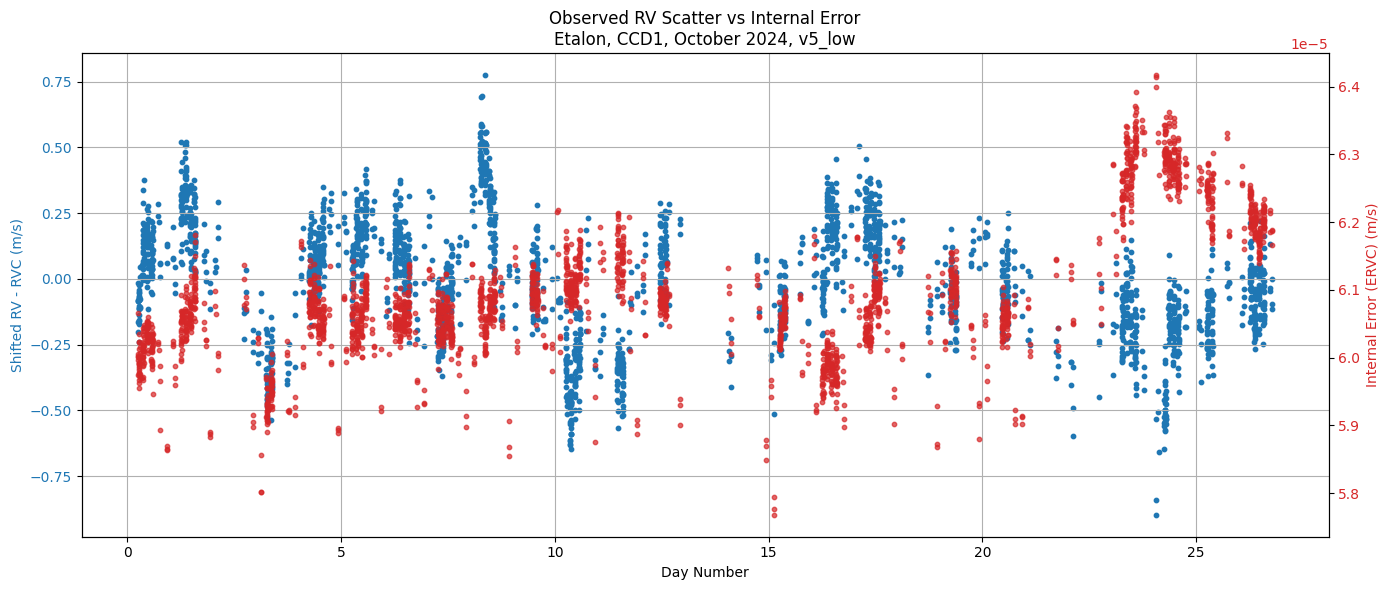

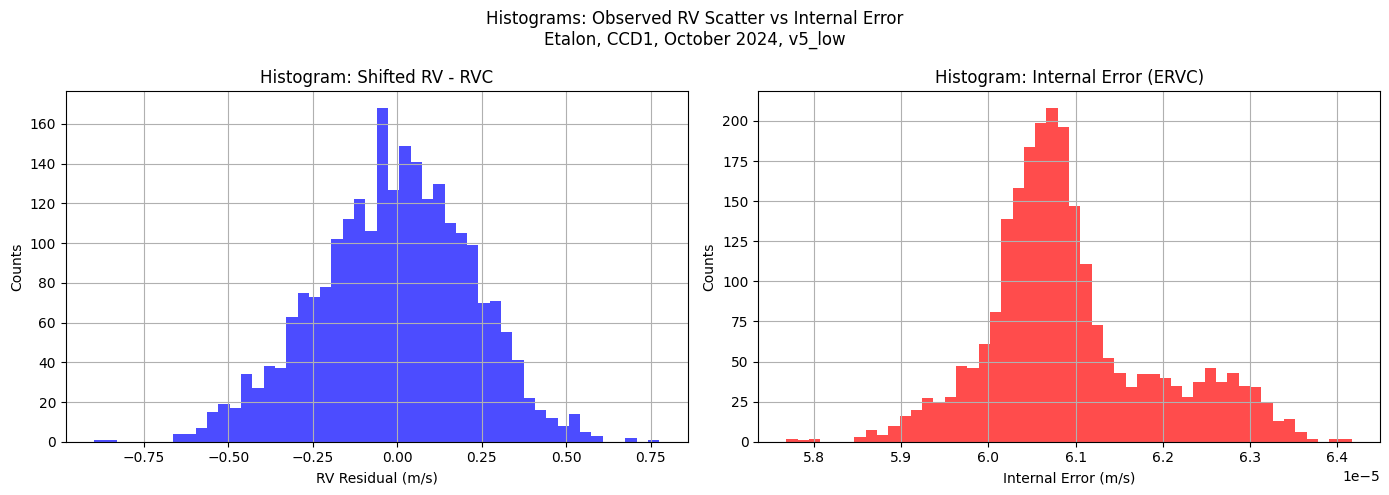


Summary Statistics:


Metric  Shifted (RV - RVC)  Internal Error (ERVC)
0                Mean           -0.009290           6.093608e-05
1              Median            0.000000           6.075320e-05
2  Standard Deviation            0.226856           9.816446e-07
3                 RMS            0.227046           6.094399e-05
4                 IQR            0.311971           9.890000e-07

In [51]:
summary_stats = compare_internal_error_vs_observed_scatter(
    df_v5_qc_etalon_low,
    rv_col='CCD1RV',
    rvc_col='CCD1RVC',
    ervc_col='CCD1ERVC',
    subtitle='Etalon, CCD1, October 2024, v5_low'
)

## New ERV Timeseries and Analysis of Etalon CCD2ERVC across tsdb version

INFO: Starting AnalyzeTimeSeries
INFO: Jupyter Notebook environment detected.
INFO: Path of database file: /testdata/kpf_ts_aug_oct2024_v5.db
INFO: Base data directory: /data/L0
INFO: Primary table 'kpfdb' created/updated successfully.
INFO: Metadata table 'kpfdb_metadata' created/updated successfully.
INFO: Summary: 14928 obs x 1661 cols over 27 days in 20241001-20241027; updated 2025-04-03 04:48:16
INFO: Plotting from config: /code/KPF-Pipeline/static/tsdb_plot_configs/RV/autocal_erv.yaml


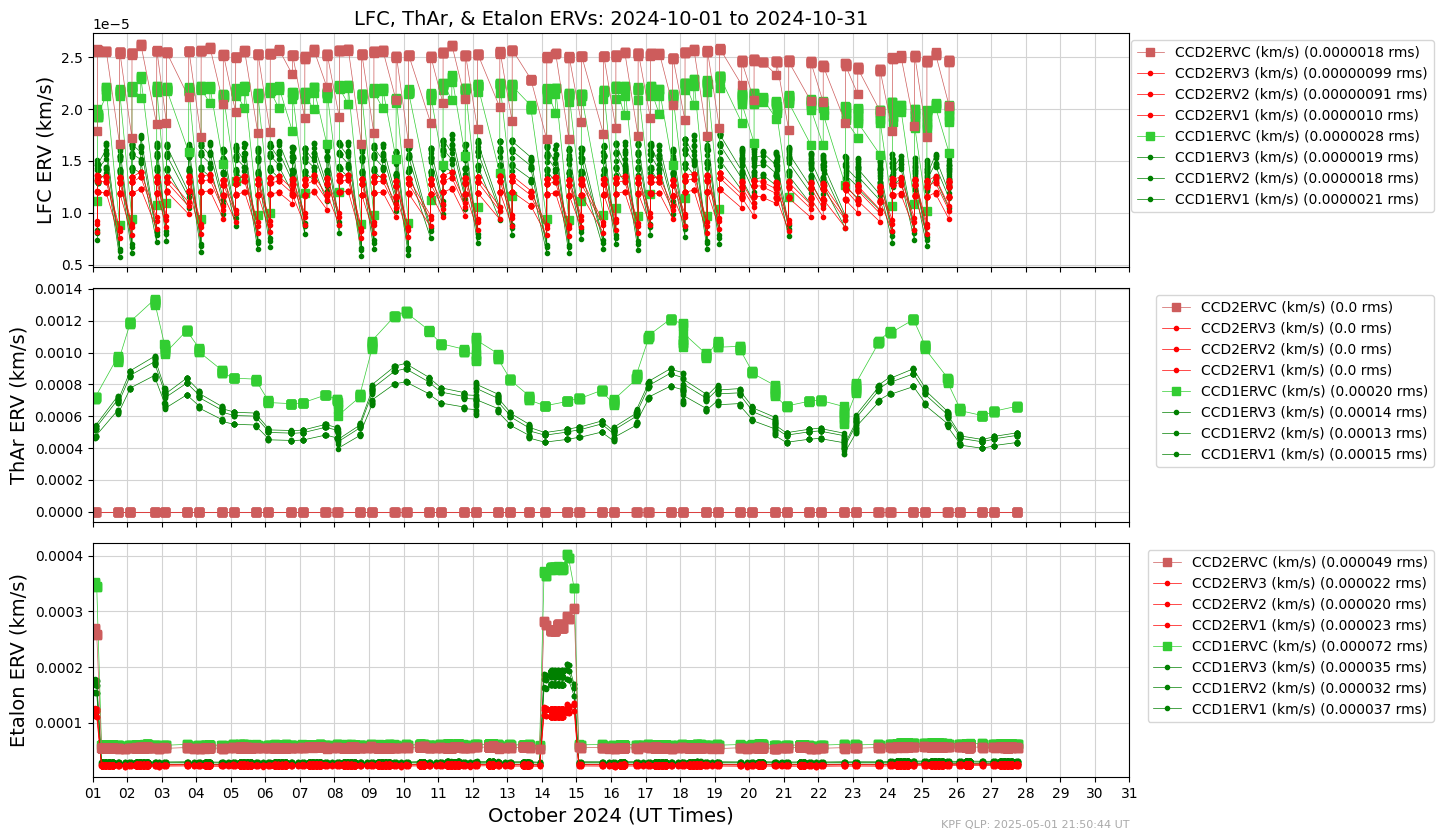

In [46]:
myTS_test = AnalyzeTimeSeries(db_path=db_path)
start_date = datetime(2024, 10,  1)
end_date   = datetime(2024, 10,  31)
myTS_test.plot_time_series_multipanel('autocal_erv', start_date=start_date, end_date=end_date, show_plot=True, clean=True)

Dataset      Mean     StDev       RMS
0  tsdb v3 - DRP 2.8.2  0.127700  0.005799  0.127831
1  tsdb v5 - DRP 2.8.2  0.121801  0.002194  0.121821
2  tsdb v5 - DRP 2.9.0  0.024588  0.000417  0.024592

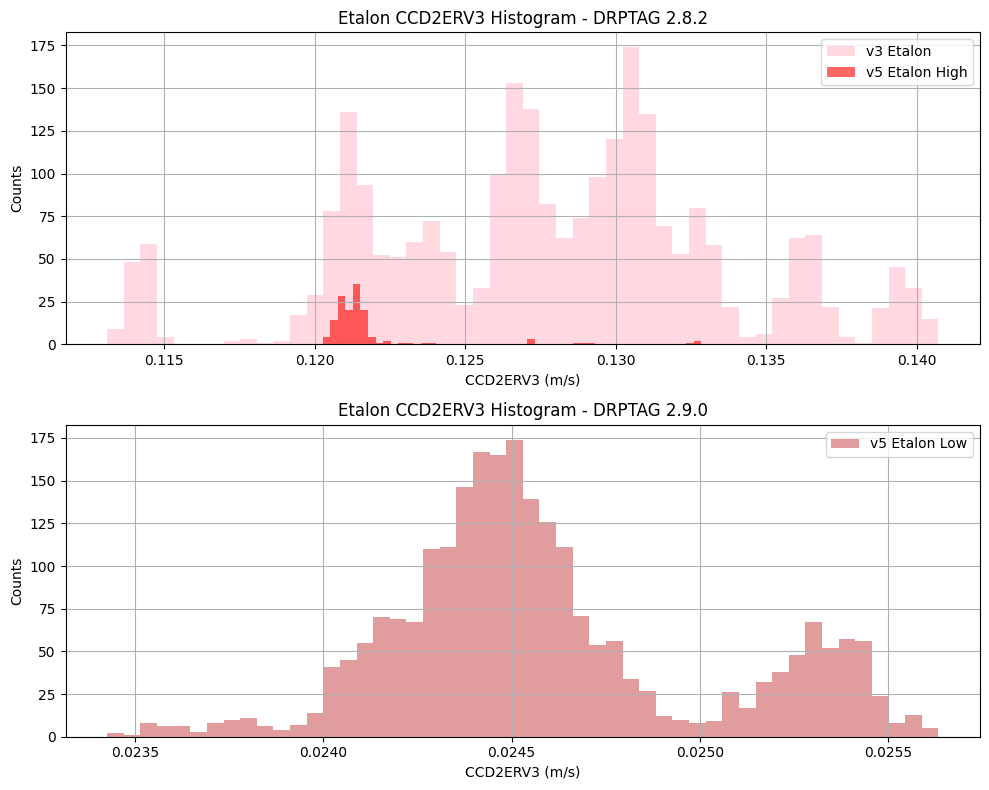

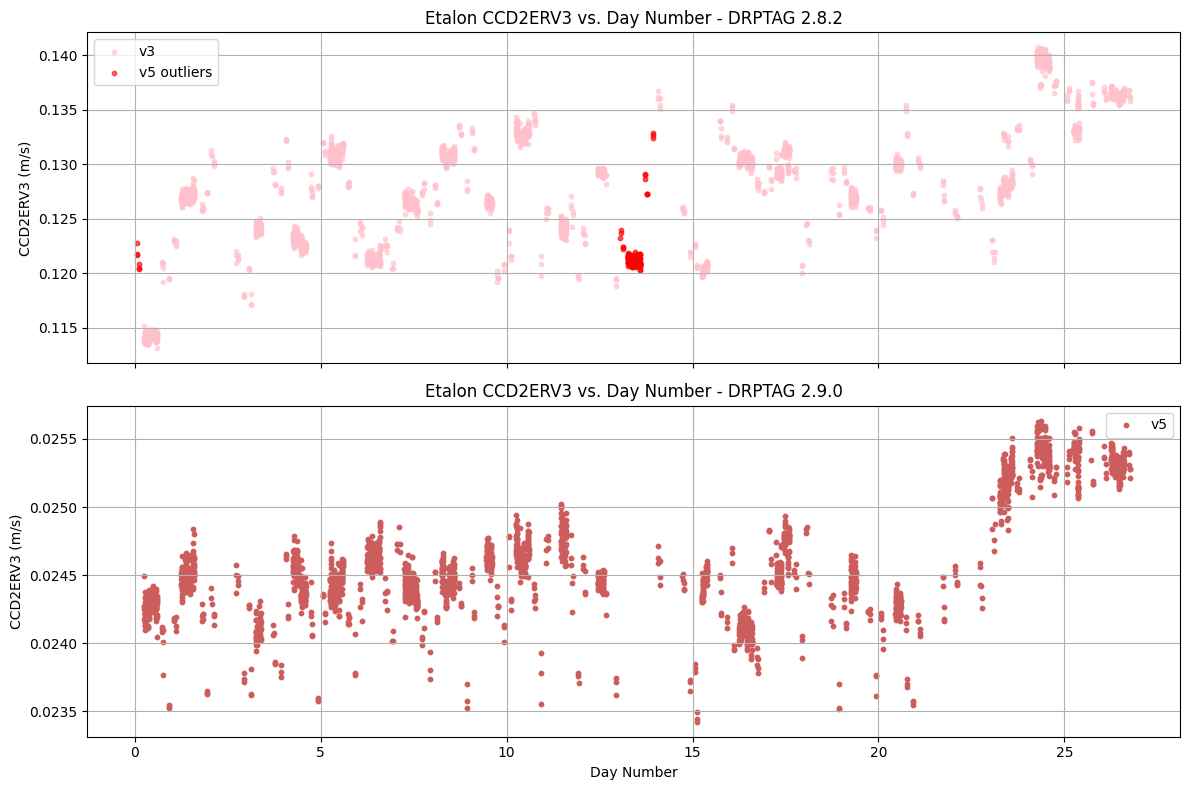

In [44]:
# compute stats
def compute_stats(df, col):
    mean = df[col].mean()
    std = df[col].std()
    rms = np.sqrt(np.mean(np.square(df[col])))
    return mean, std, rms
stats_v3 = compute_stats(df_v3_qc_etalon, 'CCD2ERV3')
stats_v5_low = compute_stats(df_v5_qc_etalon_low, 'CCD2ERV3')
stats_v5_high = compute_stats(df_v5_qc_etalon_high, 'CCD2ERV3')


# create summary dataframe
summary_df = pd.DataFrame({
    #'Dataset': ['v3_etalon', 'v5_etalon_low', 'v5_etalon_high'],
    'Dataset': ['tsdb v3 - DRP 2.8.2', 'tsdb v5 - DRP 2.8.2', 'tsdb v5 - DRP 2.9.0'],
    'Mean': [stats_v3[0], stats_v5_high[0], stats_v5_low[0]],
    'StDev': [stats_v3[1], stats_v5_high[1], stats_v5_low[1]],
    'RMS': [stats_v3[2], stats_v5_high[2], stats_v5_low[2]]
})
display(summary_df)



fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=False)
# Top panel: v3 and v5 high-error
axs[0].hist(df_v3_qc_etalon['CCD2ERV3'], bins=50, alpha=0.6, color='pink', label='v3 Etalon')
axs[0].hist(df_v5_qc_etalon_high['CCD2ERV3'], bins=50, alpha=0.6, color='red', label='v5 Etalon High')
axs[0].set_title('Etalon CCD2ERV3 Histogram - DRPTAG 2.8.2')
axs[0].set_xlabel('CCD2ERV3 (m/s)')
axs[0].set_ylabel('Counts')
axs[0].legend()
axs[0].grid(True)
# Bottom panel: v5 low-error
axs[1].hist(df_v5_qc_etalon_low['CCD2ERV3'], bins=50, alpha=0.6, color='indianred', label='v5 Etalon Low')
axs[1].set_title('Etalon CCD2ERV3 Histogram - DRPTAG 2.9.0')
axs[1].set_xlabel('CCD2ERV3 (m/s)')
axs[1].set_ylabel('Counts')
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
plt.show()


fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
# Top panel: v3 and v5 high-error (shared scale)
axs[0].scatter(df_v3_qc_etalon['day_num'], df_v3_qc_etalon['CCD2ERV3'], color='pink', s=10, label='v3', alpha=0.6)
axs[0].scatter(df_v5_qc_etalon_high['day_num'], df_v5_qc_etalon_high['CCD2ERV3'], color='red', s=10, label='v5 outliers', alpha=0.6)
axs[0].set_title('Etalon CCD2ERV3 vs. Day Number - DRPTAG 2.8.2')
axs[0].set_ylabel('CCD2ERV3 (m/s)')
axs[0].legend()
axs[0].grid(True)
# Bottom panel: v5 low-error
axs[1].scatter(df_v5_qc_etalon_low['day_num'], df_v5_qc_etalon_low['CCD2ERV3'], color='indianred', s=10, label='v5')
axs[1].set_title('Etalon CCD2ERV3 vs. Day Number - DRPTAG 2.9.0')
axs[1].set_xlabel('Day Number')
axs[1].set_ylabel('CCD2ERV3 (m/s)')
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
plt.show()




## Linear Relationships Between RV/ERV and Diagnostic Features

In [ ]:
import pandas as pd
import numpy as np

def summarize_correlations(df, feature_cols_num):
    """
    Compute and return correlation summaries for various RV and ERV columns
    against a given list of numerical features.

    Parameters:
    df (pd.DataFrame): Input DataFrame with relevant columns.
    feature_cols_num (list): List of numerical feature column names.

    Returns:
    dict: Dictionary containing summary statistics DataFrames for each target column.
    """
    from IPython.display import display

    # Define the target columns of interest
    target_cols = [
        'CCD1ERVC', 'CCD1ERV', 'CCD1RVC', 'CCD1RV',
        'CCD2ERVC', 'CCD2ERV', 'CCD2RVC', 'CCD2RV'
    ]
    print(target_cols)

    summary_dfs = {}

    for target_col in target_cols:
        if target_col not in df.columns:
            continue
        # Calculate Pearson correlation
        correlations = df[feature_cols_num + [target_col]].corr()[target_col].drop(target_col)
        # Drop NaN correlations
        correlations = correlations.dropna()
        # Get top 10 most strongly correlated features
        top_features = correlations.abs().sort_values(ascending=False).head(10).index.tolist()
        summary_df = correlations.loc[top_features].to_frame(name='Correlation')
        summary_df.index.name = 'Feature'
        summary_dfs[f'summary_stats_{target_col}'] = summary_df
        

    return summary_dfs


# This code block defines the function only. 
# You can now call summarize_correlations(df, feature_cols_num) with your data.


summarize_correlations(df=df_v5_qc_etalon_low, feature_cols_num=feature_cols_num) # df_v5_qc_etalon_low

['CCD1ERVC', 'CCD1ERV', 'CCD1RVC', 'CCD1RV', 'CCD2ERVC', 'CCD2ERV', 'CCD2RVC', 'CCD2RV']


{'summary_stats_CCD1ERVC':                                 Correlation
 Feature                                    
 kpfcal.BLUECUTIACT                 0.419155
 kpfmet.CAL_BENCH_TRANS_STG_MOT    -0.340116
 kpfmet.U_DAILY                    -0.299923
 kpfmet.TH_DAILY                   -0.262851
 AGEWLS                             0.259944
 AGEWLS2                            0.187630
 kpfred.BRD10_DRVR_T               -0.147929
 kpfcal.VISFLUX                     0.138809
 kpfgreen.CF_TIP_T                  0.125287
 kpfmet.CALEM_SCMBLR_FIBER_END      0.106491,
 'summary_stats_CCD1ERV':                                 Correlation
 Feature                                    
 kpfcal.BLUECUTIACT                 0.417901
 kpfmet.CAL_BENCH_TRANS_STG_MOT    -0.343008
 kpfmet.U_DAILY                    -0.300512
 kpfmet.TH_DAILY                   -0.265192
 AGEWLS                             0.253998
 AGEWLS2                            0.182588
 kpfcal.VISFLUX                     0.140758
 kp

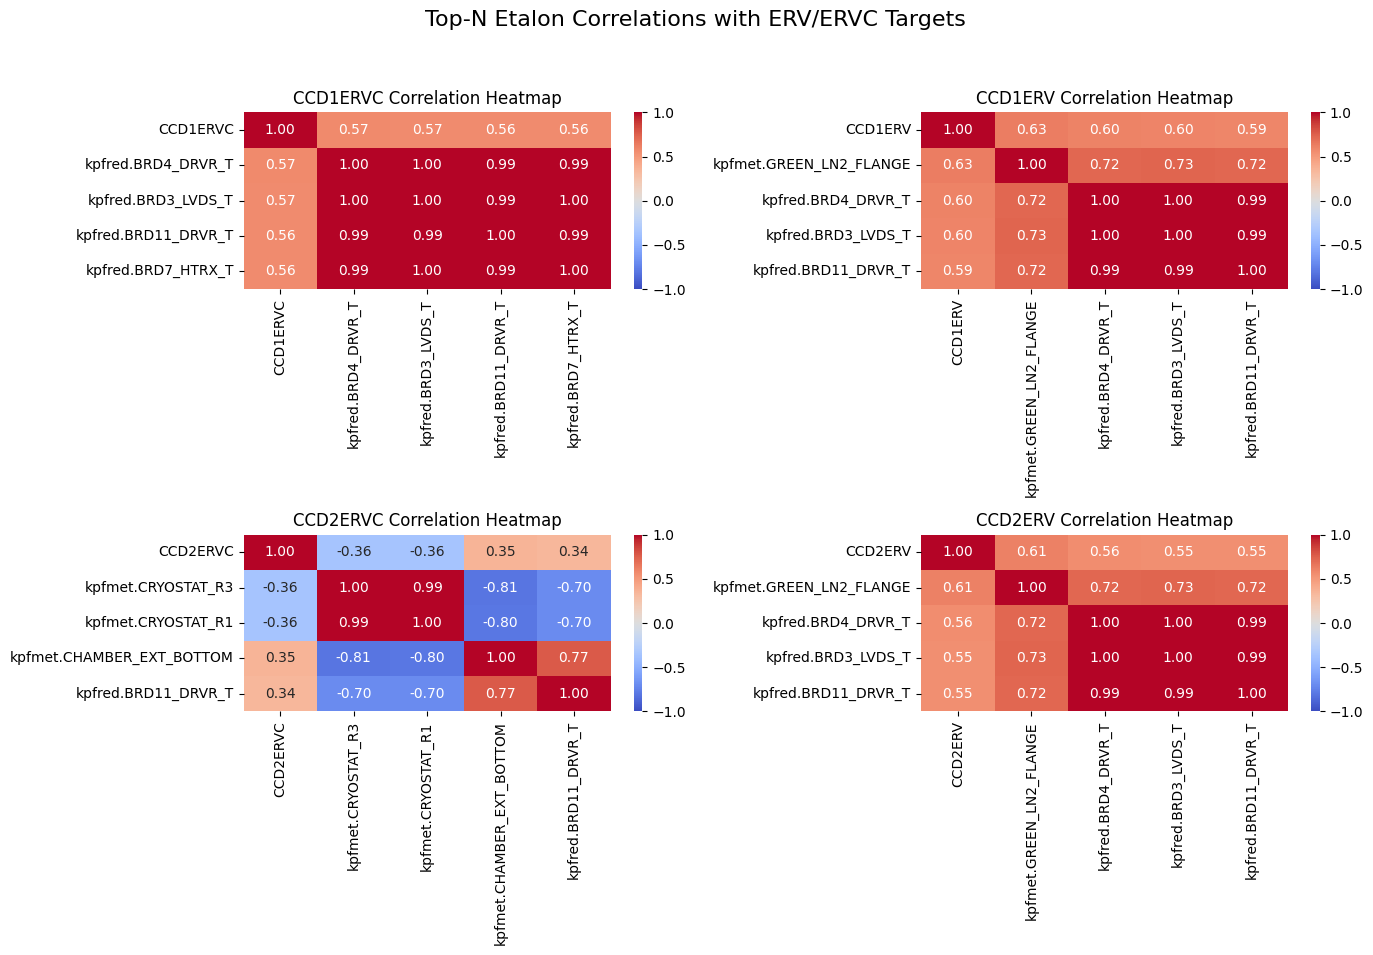

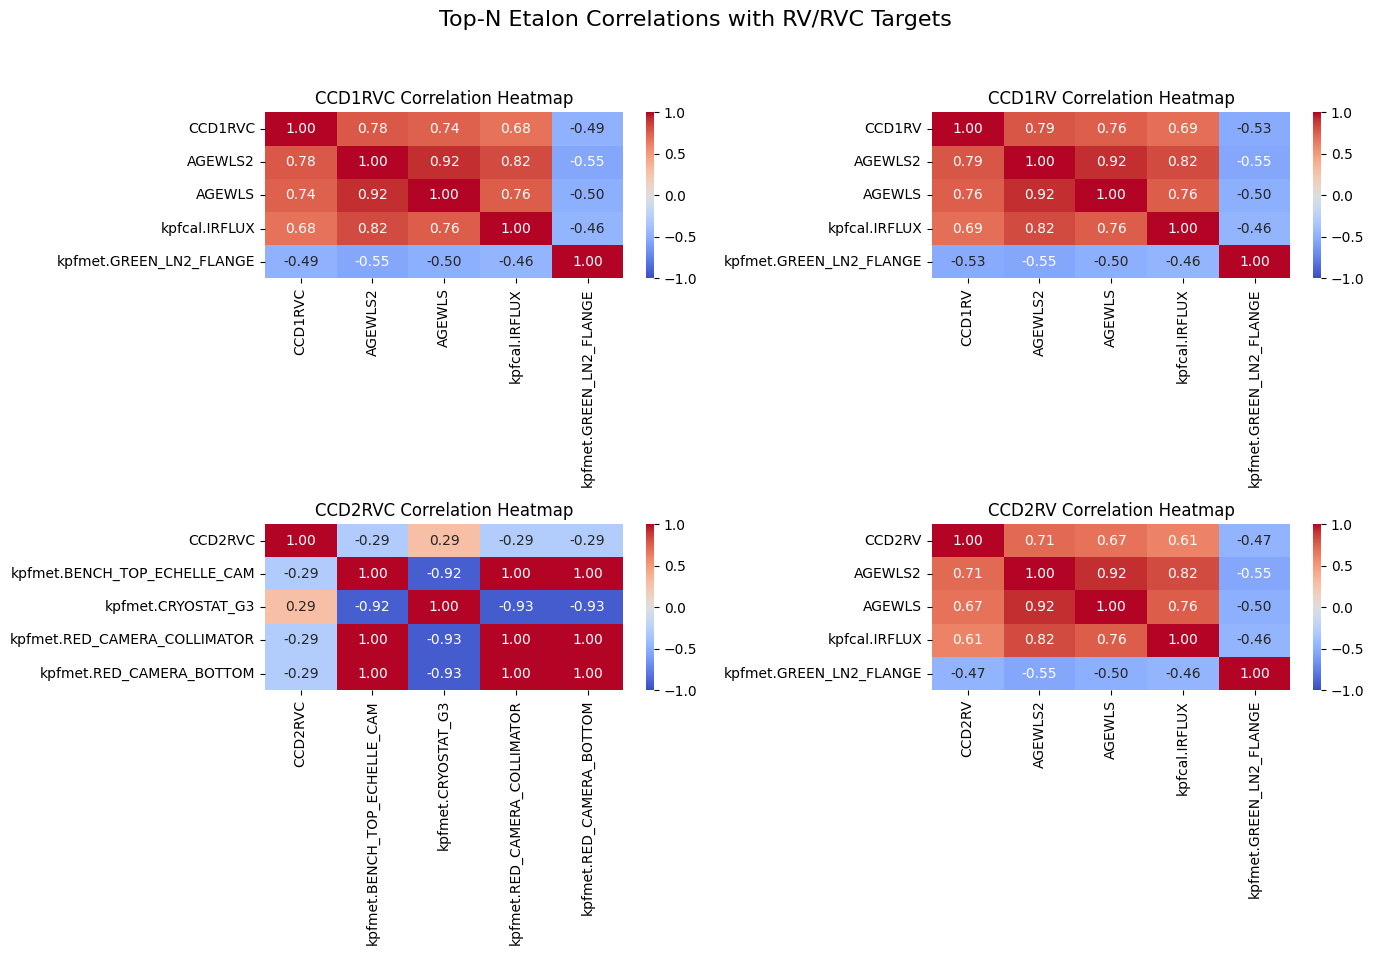

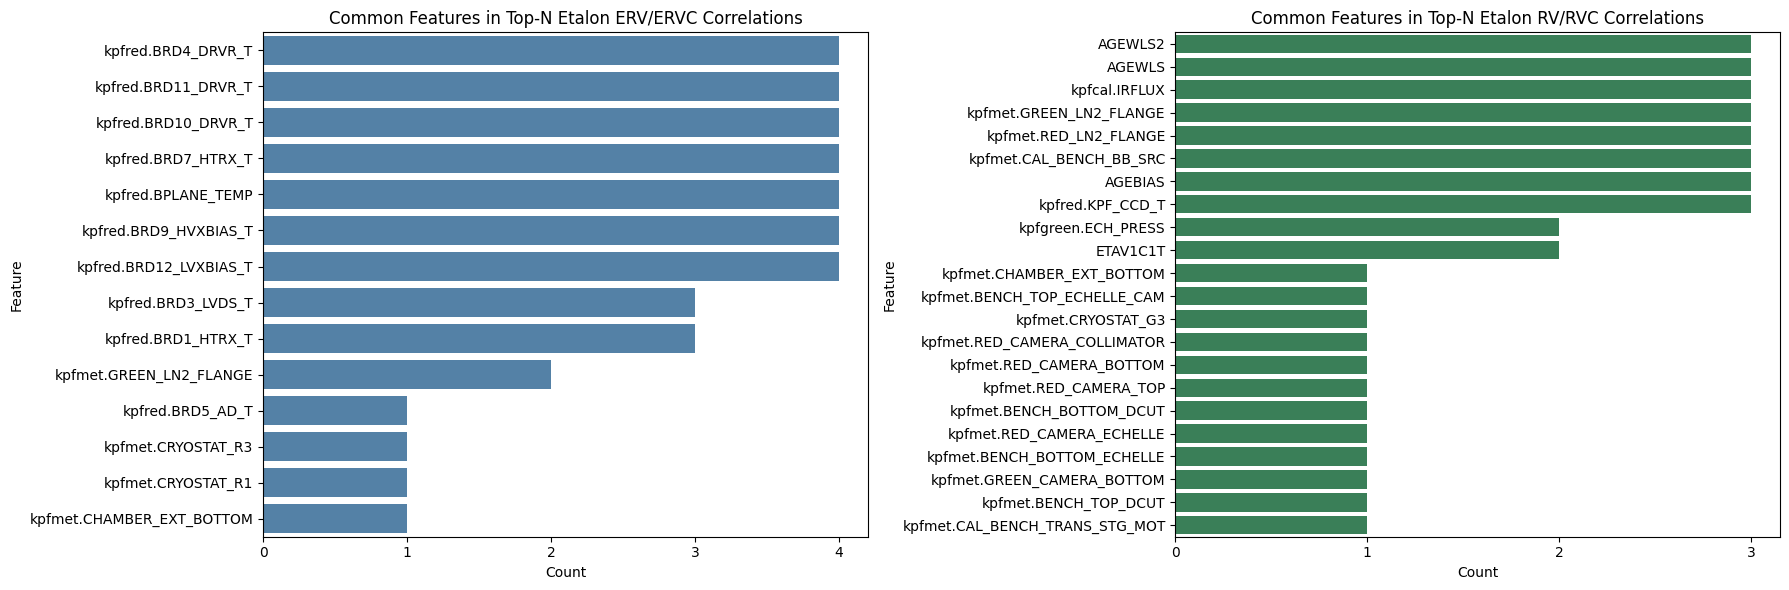

In [54]:
# Re-import necessary libraries after kernel reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def show_heatmaps(df, feature_cols_num, N=4):
    targets_erv = ['CCD1ERVC', 'CCD1ERV', 'CCD2ERVC', 'CCD2ERV']
    targets_rv = ['CCD1RVC', 'CCD1RV', 'CCD2RVC', 'CCD2RV']
    
    fig1, axs1 = plt.subplots(2, 2, figsize=(14, 10))
    fig1.suptitle("Top-N Etalon Correlations with ERV/ERVC Targets", fontsize=16)
    
    for ax, target in zip(axs1.ravel(), targets_erv):
        if target in df.columns:
            corr = df[feature_cols_num + [target]].corr()[target].drop(target)
            top_features = corr.abs().sort_values(ascending=False).head(N).index.tolist()
            sns.heatmap(df[[target] + top_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=ax, vmin=-1, vmax=1)
            ax.set_title(f'{target} Correlation Heatmap')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    fig2, axs2 = plt.subplots(2, 2, figsize=(14, 10))
    fig2.suptitle("Top-N Etalon Correlations with RV/RVC Targets", fontsize=16)
    
    for ax, target in zip(axs2.ravel(), targets_rv):
        if target in df.columns:
            corr = df[feature_cols_num + [target]].corr()[target].drop(target)
            top_features = corr.abs().sort_values(ascending=False).head(N).index.tolist()
            sns.heatmap(df[[target] + top_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=ax, vmin=-1, vmax=1)
            ax.set_title(f'{target} Correlation Heatmap')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def show_common_keywords(df, feature_cols_num, M=10):
    targets_erv = ['CCD1ERVC', 'CCD1ERV', 'CCD2ERVC', 'CCD2ERV']
    targets_rv = ['CCD1RVC', 'CCD1RV', 'CCD2RVC', 'CCD2RV']
    
    counter_erv = Counter()
    for target in targets_erv:
        if target in df.columns:
            corr = df[feature_cols_num + [target]].corr()[target].drop(target)
            top_features = corr.abs().sort_values(ascending=False).head(M).index.tolist()
            counter_erv.update(top_features)

    counter_rv = Counter()
    for target in targets_rv:
        if target in df.columns:
            corr = df[feature_cols_num + [target]].corr()[target].drop(target)
            top_features = corr.abs().sort_values(ascending=False).head(M).index.tolist()
            counter_rv.update(top_features)
    
    df_erv = pd.DataFrame(counter_erv.items(), columns=['Feature', 'Count']).sort_values(by='Count', ascending=False)
    df_rv = pd.DataFrame(counter_rv.items(), columns=['Feature', 'Count']).sort_values(by='Count', ascending=False)

    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    sns.barplot(data=df_erv, x='Count', y='Feature', ax=axs[0], color='steelblue')
    axs[0].set_title('Common Features in Top-N Etalon ERV/ERVC Correlations')
    axs[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    sns.barplot(data=df_rv, x='Count', y='Feature', ax=axs[1], color='seagreen')
    axs[1].set_title('Common Features in Top-N Etalon RV/RVC Correlations')
    axs[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()


show_heatmaps(df=df_v5_qc_etalon_low, feature_cols_num=feature_cols_num, N=4)

show_common_keywords(df=df_v5_qc_etalon_low, feature_cols_num=feature_cols_num, M=10)


## Phase-Folded Analysis of Diurnal Trends

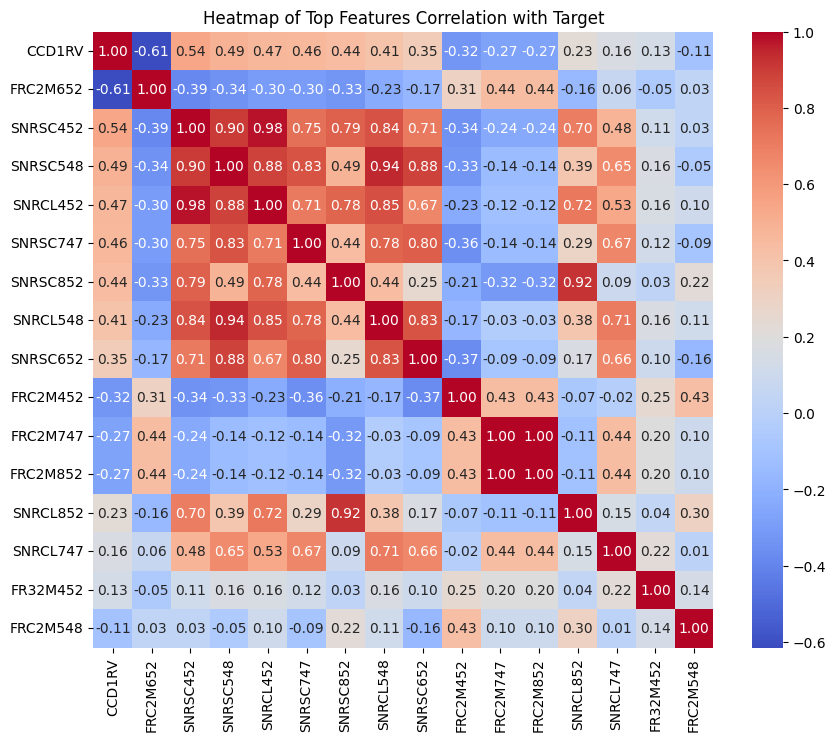

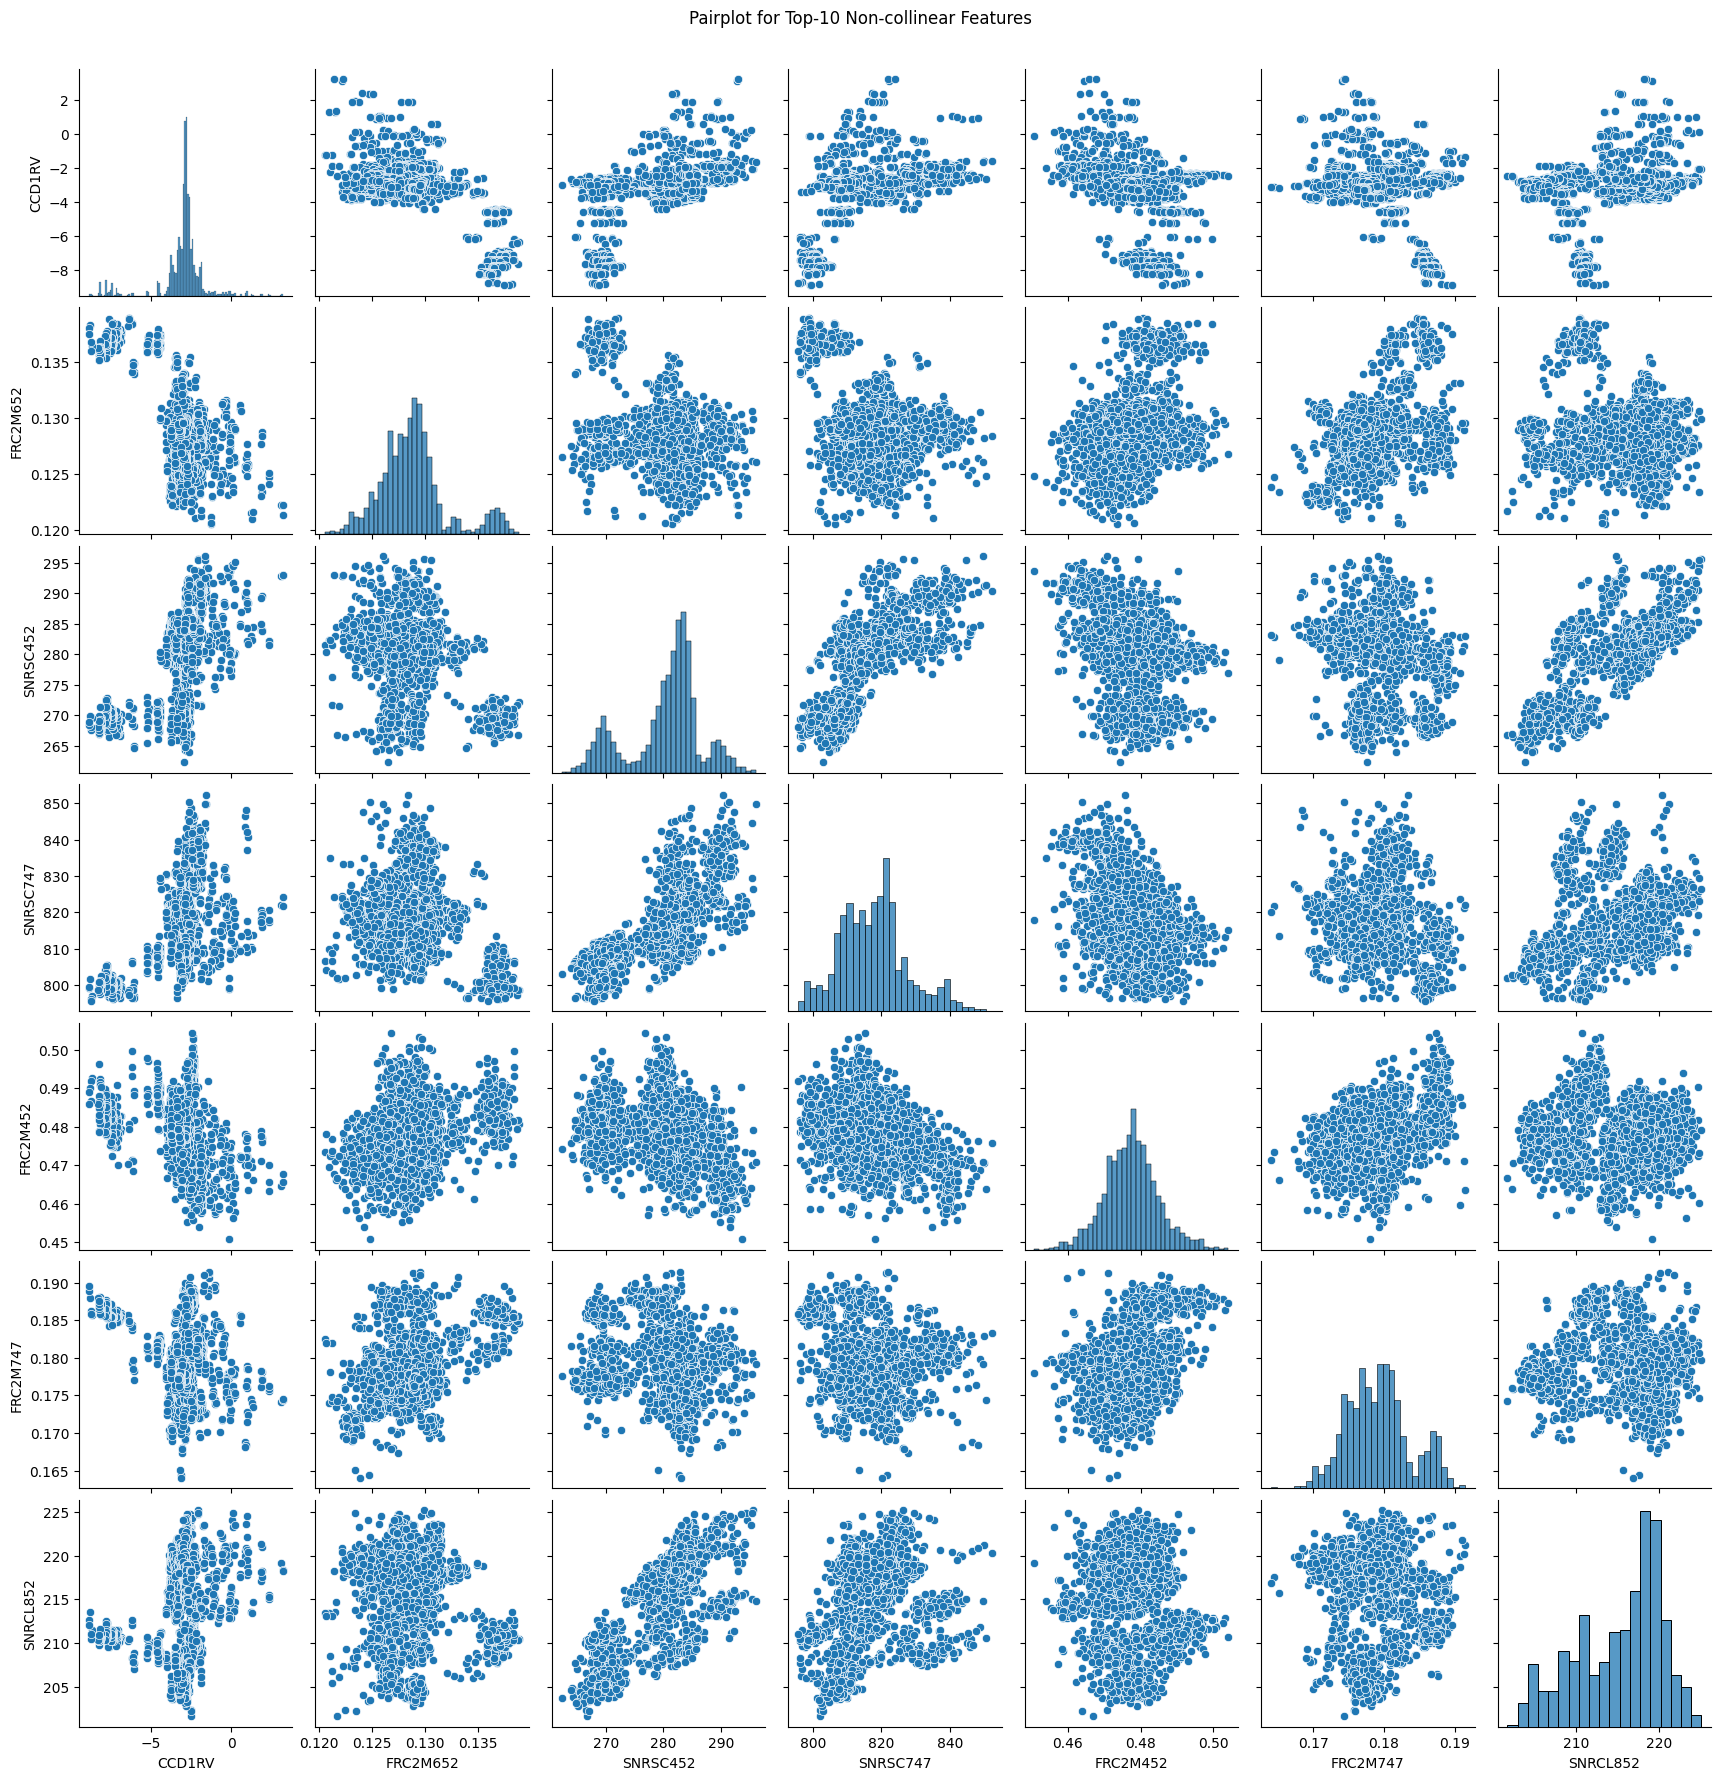

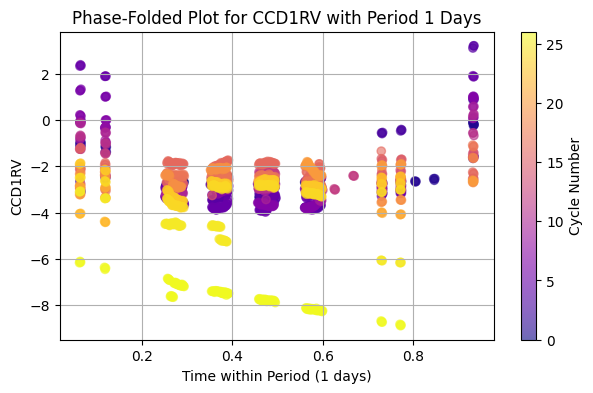

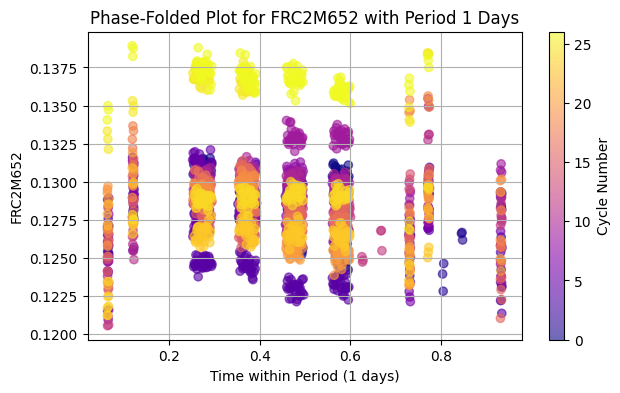

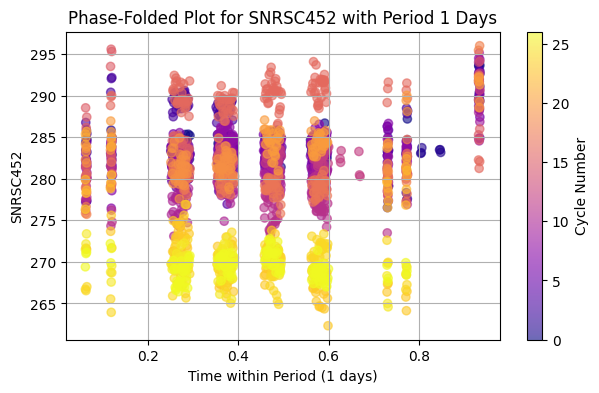

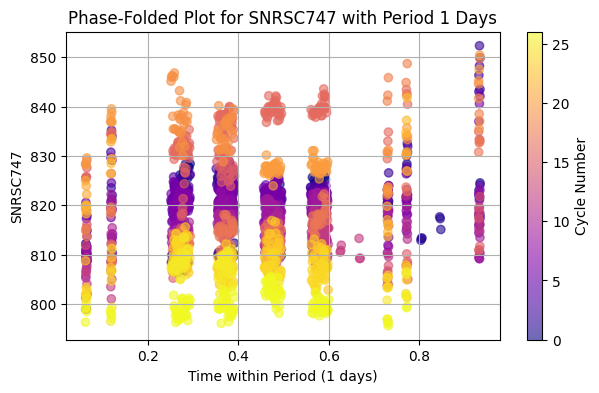

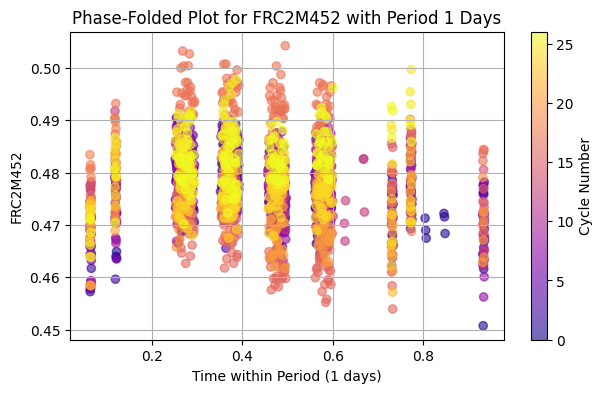

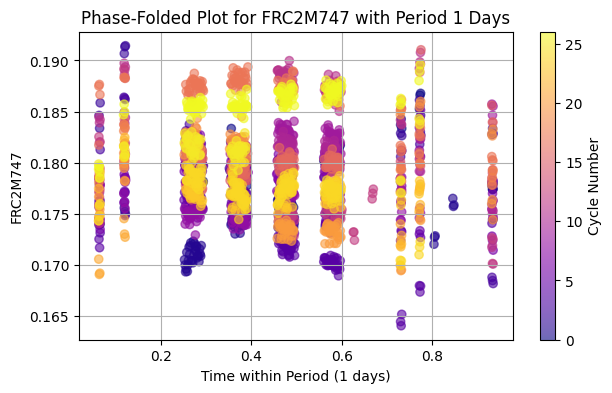

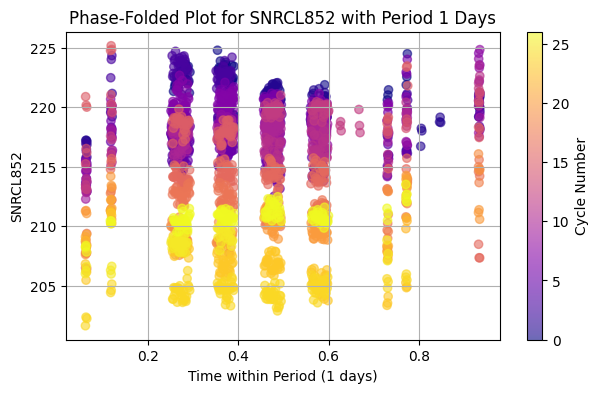

/tmp/ipykernel_90/3813602596.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(categories))


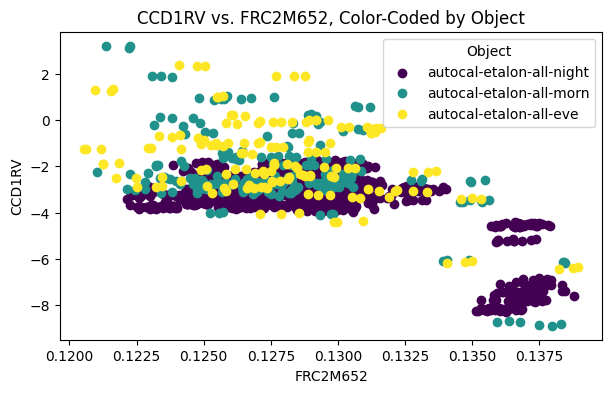

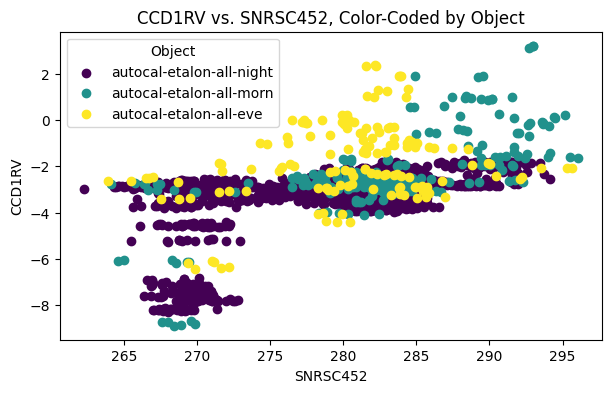

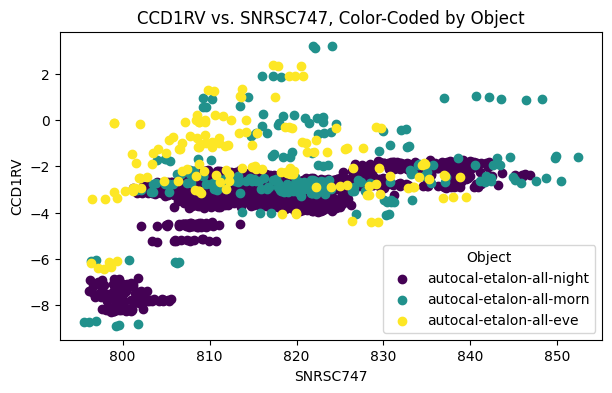

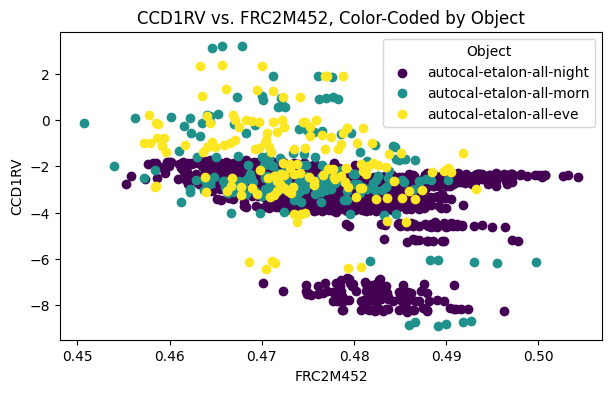

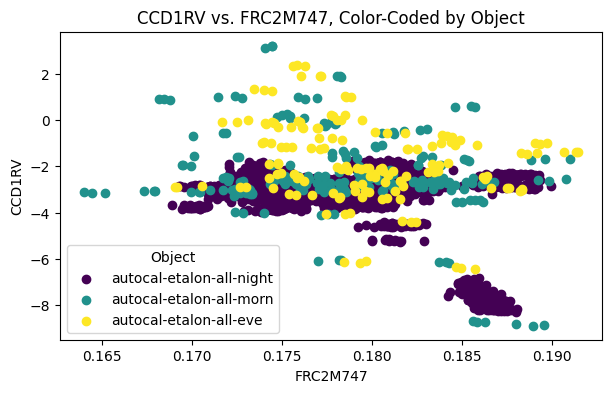

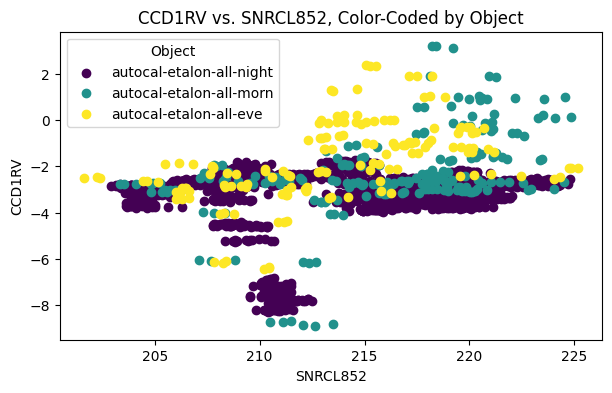

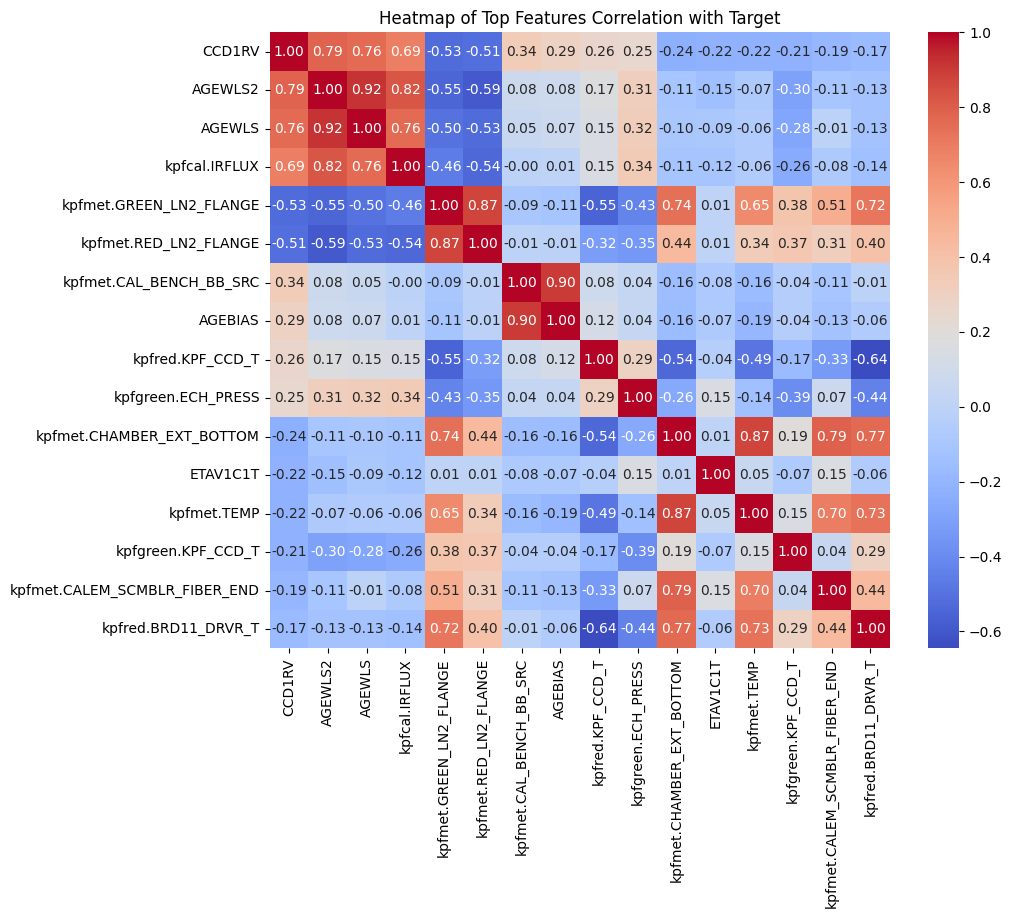

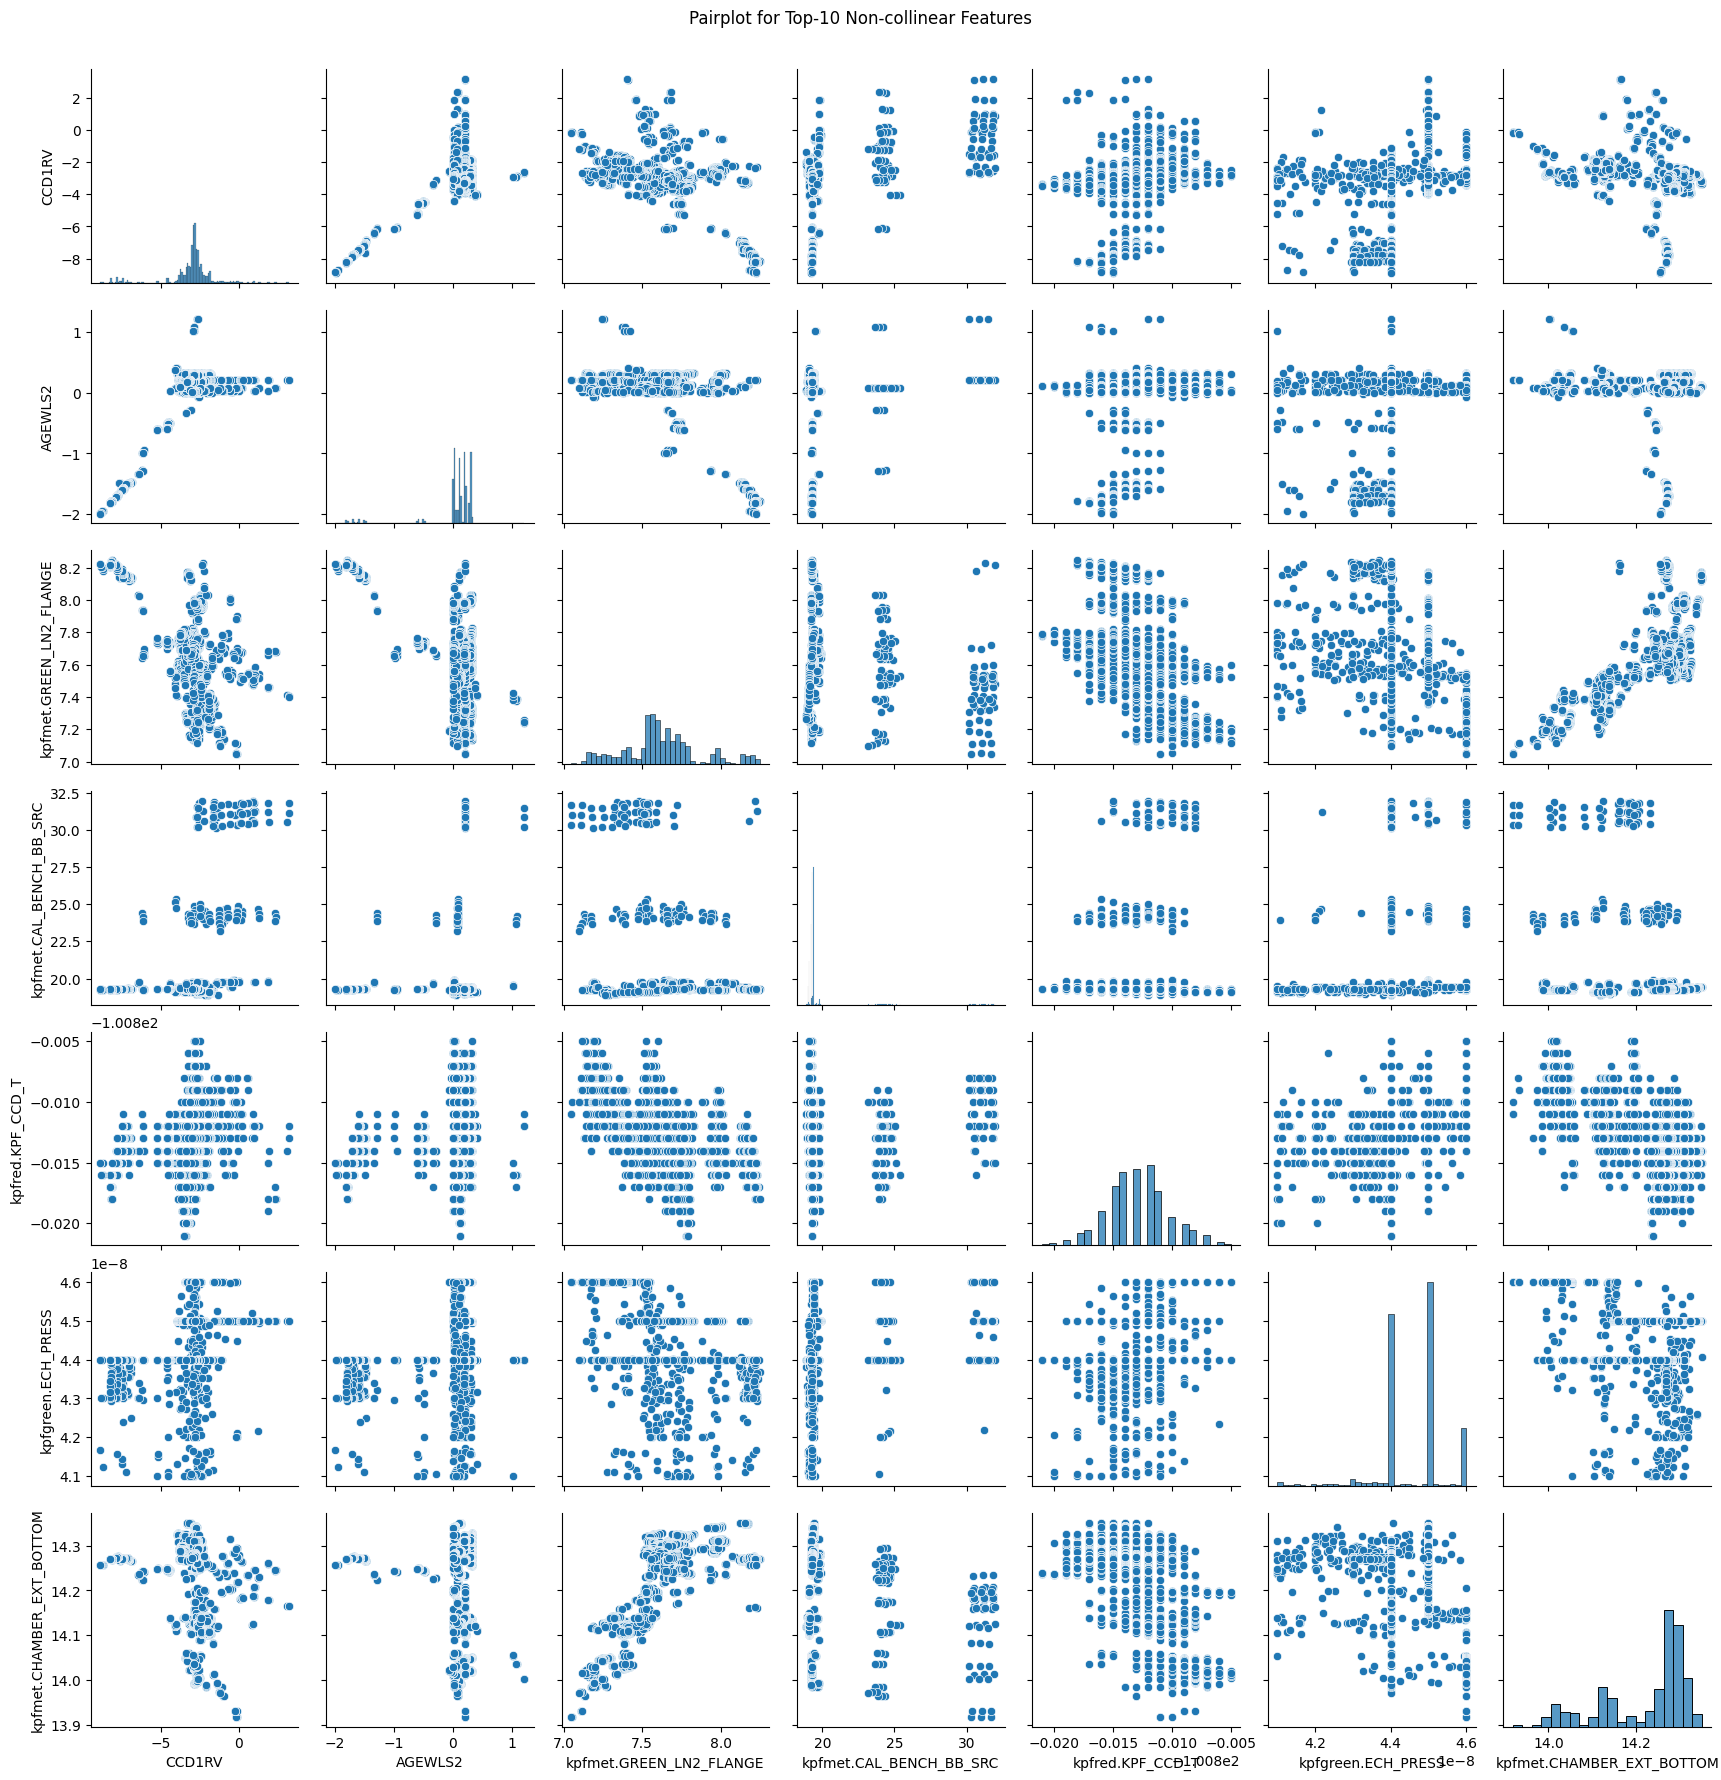

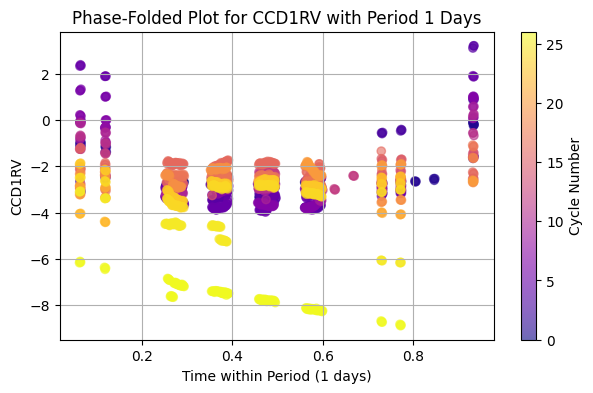

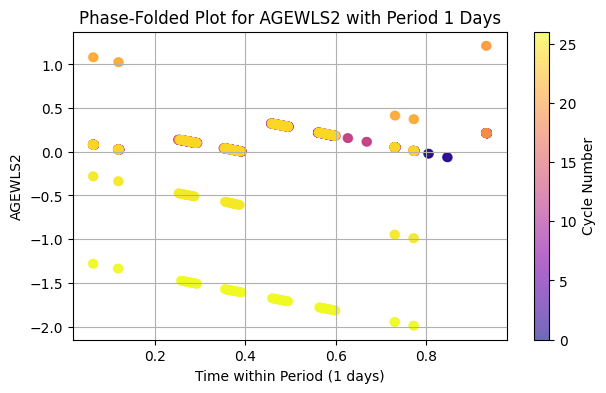

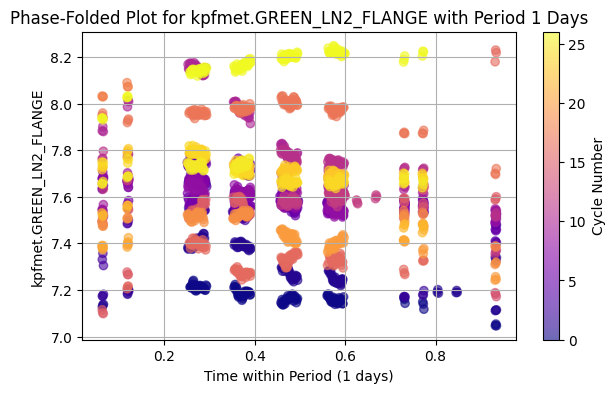

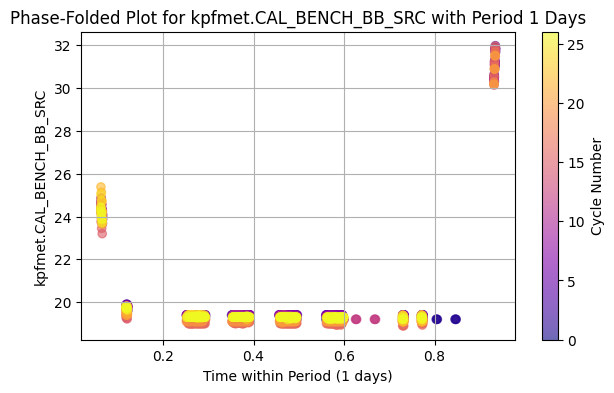

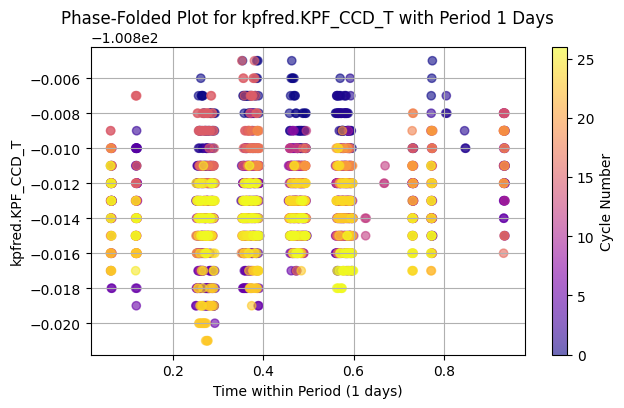

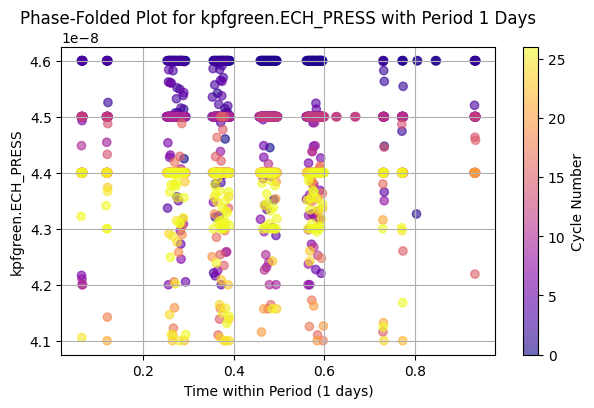

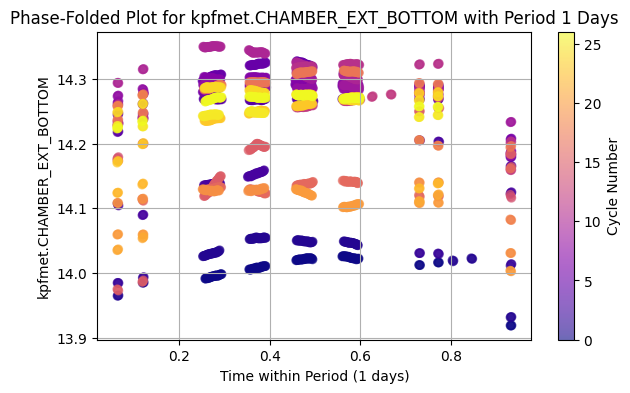

/tmp/ipykernel_90/3813602596.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(categories))


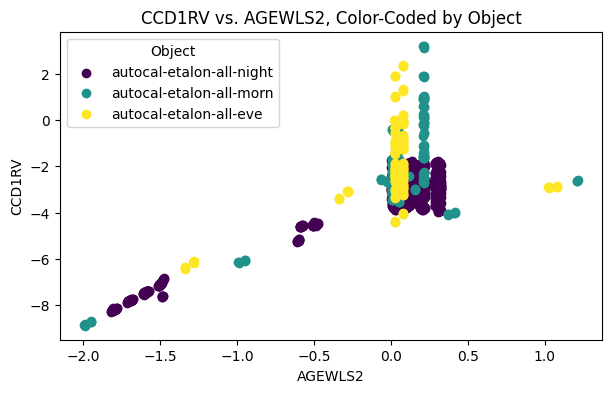

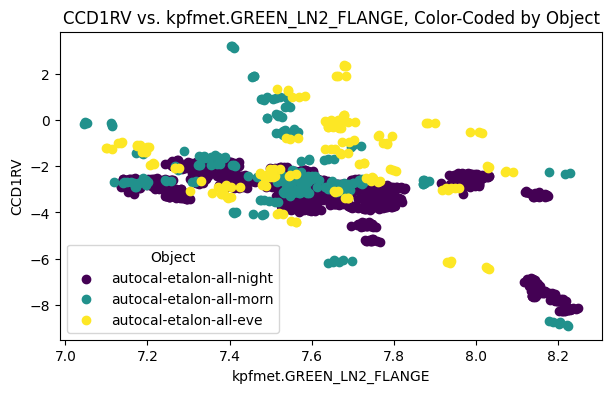

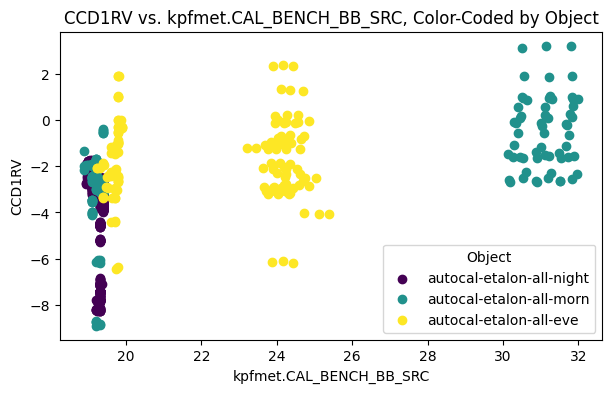

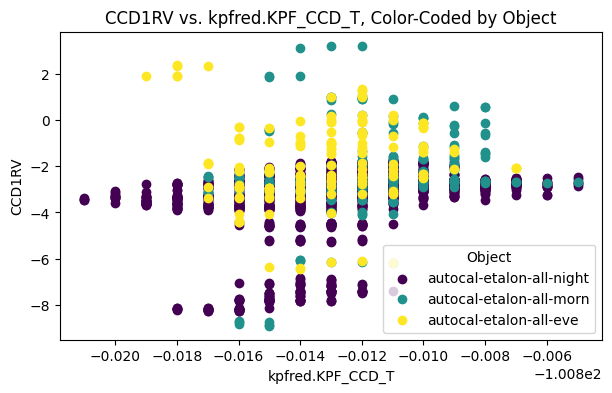

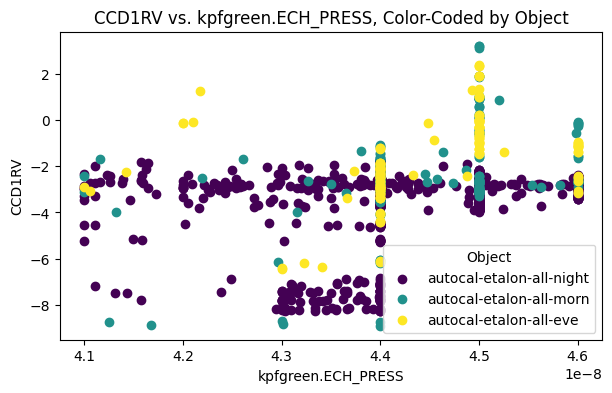

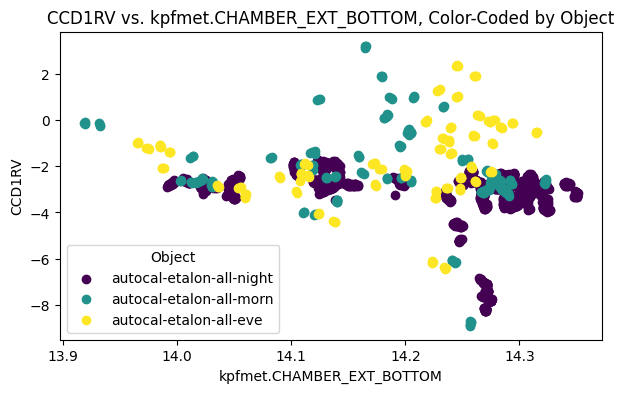

In [65]:
target_col = 'CCD1RV'

analyze_overall_stats(df=df_v5_qc_etalon_low,
                      target_col=target_col,
                      feature_cols_snr=feature_cols_snr,
                      feature_cols_num=feature_cols_num,
                      feature_cols_bool=feature_cols_qc)

## Gaussian Mixture Modeling and Subpopulations

In [ ]:
# Multiply by a factor of 1k to handle convergence issue
df_v5_qc_etalon_low['CCD1ERVC'] *= 1000
df_v5_qc_etalon_low['CCD1ERV'] *= 1000
df_v5_qc_etalon_low['CCD2ERVC'] *= 1000
df_v5_qc_etalon_low['CCD2ERV'] *= 1000

/tmp/ipykernel_90/3449954831.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_90/3449954831.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_90/3449954831.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



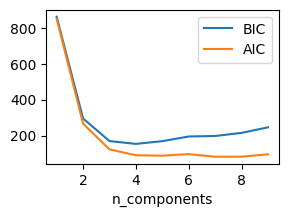

Optimal number of components selected: 4


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but GaussianMixture was fitted with feature names

/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but GaussianMixture was fitted with feature names



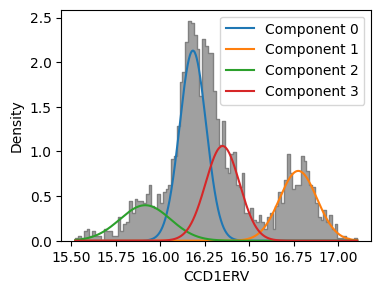

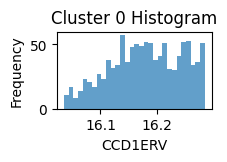

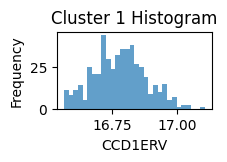

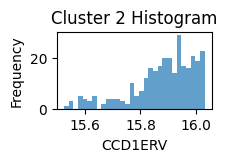

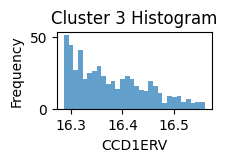

/tmp/ipykernel_90/402002511.py:117: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/tmp/ipykernel_90/402002511.py:118: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



True_Cluster0 False_Cluster0 NaN_Cluster0  \
NOTJUNK                                 1.000            nan          nan   
GOODREAD                                1.000            nan          nan   
OLDBIAS                                 1.000            nan          nan   
OLDDARK                                 1.000            nan          nan   
OLDFLAT                                 1.000            nan          nan   
WLSL1                                   0.929          0.071          nan   
LFCSAT                                    nan            nan        1.000   
TIMCHKL0                                0.997          0.003          nan   
TIMCHKL2                                0.997          0.003          nan   
DATAPRL0                                1.000            nan          nan   
DATAPRL1                                1.000            nan          nan   
DATAPRL2                                1.000            nan          nan   
DATAPR2D                                1.000            nan          nan   
CAHKPRL1                                0.995            nan        0.005   
CAHKPR2D                                0.995            nan        0.005   
KWRDPRL0                                1.000            nan          nan   
LFC2DFOK                                  nan            nan        1.000   
EMSAT                                     nan            nan        1.000   
EMNEG                                     nan            nan        1.000   
LOWBIAS                                   nan            nan        1.000   
LOWDARK                                   nan            nan        1.000   
POS2DSNR                                  nan          1.000          nan   
MONOTWLS                                1.000            nan          nan   
GREEN                                   1.000            nan          nan   
RED                                     1.000            nan          nan   
CA_HK                                   0.995          0.005          nan   
EXPMETER                                  nan          1.000          nan   
GUIDE                                     nan          1.000          nan   
FFFB                                      nan          1.000          nan   
OBJECT_autocal-etalon-all-eve           0.061          0.939          nan   
OBJECT_autocal-etalon-all-morn          0.077          0.923          nan   
OBJECT_autocal-etalon-all-night         0.862          0.138          nan   

                                True_Cluster1 False_Cluster1 NaN_Cluster1  \
NOTJUNK                                 1.000            nan          nan   
GOODREAD                                1.000            nan          nan   
OLDBIAS                                 1.000            nan          nan   
OLDDARK                                 1.000            nan          nan   
OLDFLAT                                 1.000            nan          nan   
WLSL1                                   0.568          0.432          nan   
LFCSAT                                    nan            nan        1.000   
TIMCHKL0                                0.996          0.004          nan   
TIMCHKL2                                0.996          0.004          nan   
DATAPRL0                                1.000            nan          nan   
DATAPRL1                                1.000            nan          nan   
DATAPRL2                                1.000            nan          nan   
DATAPR2D                                1.000            nan          nan   
CAHKPRL1                                1.000            nan          nan   
CAHKPR2D                                1.000            nan          nan   
KWRDPRL0                                1.000            nan          nan   
LFC2DFOK                                  nan            nan        1.000   
EMSAT                                     nan            nan        1.000   
EMNEG                      

Empty DataFrame
Columns: [Feature, ClusterA, ClusterB]
Index: []

mean_Cluster0 std_Cluster0 mean_Cluster1  \
AGEBIAS                                     0.006        0.075         0.000   
AGEDARK                                     0.000        0.000         0.000   
AGEFLAT                                     0.000        0.000         0.006   
AGEWLS                                     -0.216        0.143        -0.630   
AGEWLS2                                     0.151        0.116        -0.428   
ETAV1C1T                                   23.990        0.001        23.990   
ETAV1C2T                                   23.790        0.001        23.790   
ETAV1C3T                                   23.600        0.000        23.600   
ETAV1C4T                                   23.900        0.000        23.900   
ETAV2C3T                                   24.000        0.001        24.000   
kpfmet.BENCH_BOTTOM_BETWEEN_CAMERAS        14.937        0.057        14.943   
kpfmet.BENCH_BOTTOM_COLLIMATOR             15.415        0.060        15.420   
kpfmet.BENCH_BOTTOM_DCUT                   15.184        0.060        15.189   
kpfmet.BENCH_BOTTOM_ECHELLE                15.353        0.058        15.356   
kpfmet.BENCH_TOP_BETWEEN_CAMERAS           14.872        0.056        14.877   
kpfmet.BENCH_TOP_COLL                      15.512        0.060        15.518   
kpfmet.BENCH_TOP_DCUT                      15.226        0.059        15.231   
kpfmet.BENCH_TOP_ECHELLE_CAM               15.259        0.058        15.261   
kpfmet.CALEM_SCMBLR_CHMBR_END              16.155        0.094        16.173   
kpfmet.CALEM_SCMBLR_FIBER_END              15.993        0.094        16.018   
kpfmet.CAL_BENCH                           18.781        0.173        18.752   
kpfmet.CAL_BENCH_BB_SRC                    19.507        1.208        19.422   
kpfmet.CAL_BENCH_BOT                       21.883        0.117        21.852   
kpfmet.CAL_BENCH_ENCL_AIR                  18.669        0.195        18.623   
kpfmet.CAL_BENCH_OCT_MOT                   18.601        0.166        18.611   
kpfmet.CAL_BENCH_TRANS_STG_MOT             19.009        0.356        18.967   
kpfmet.CAL_RACK_TOP                        21.875        0.119        21.875   
kpfmet.CHAMBER_EXT_BOTTOM                  14.202        0.111        14.267   
kpfmet.CHAMBER_EXT_TOP                   -273.150        0.000      -273.150   
kpfmet.CRYOSTAT_G1                       -273.150        0.000      -273.150   
kpfmet.CRYOSTAT_G2                       -273.150        0.000      -273.150   
kpfmet.CRYOSTAT_G3                         16.773        0.008        16.771   
kpfmet.CRYOSTAT_R1                         16.027        0.006        16.024   
kpfmet.CRYOSTAT_R2                       -273.150        0.000      -273.150   
kpfmet.CRYOSTAT_R3                         15.453        0.007        15.449   
kpfmet.ECHELLE_BOTTOM                      15.374        0.058        15.377   
kpfmet.ECHELLE_TOP                         15.234        0.058        15.236   
kpfmet.FF_SRC                              17.489        0.143        17.409   
kpfmet.GREEN_CAMERA_BOTTOM                 15.873        0.051        15.876   
kpfmet.GREEN_CAMERA_COLLIMATOR             15.914        0.051        15.917   
kpfmet.GREEN_CAMERA_ECHELLE                15.817        0.050        15.820   
kpfmet.GREEN_CAMERA_TOP                    15.727        0.050        15.730   
kpfmet.GREEN_GRISM_TOP                     15.404        0.055        15.408   
kpfmet.GREEN_LN2_FLANGE                     7.519        0.183         7.849   
kpfmet.PRIMARY_COLLIMATOR_TOP              15.809        0.060        15.817   
kpfmet.RED_CAMERA_BOTTOM                   15.381        0.051        15.384   
kpfmet.RED_CAMERA_COLLIMATOR               15.718        0.051        15.721   
kpfmet.RED_CAMERA_ECHELLE                  15.666        0.052        15.669   
kpfmet.RED_CAMERA_TOP                      15.625        0.051        15.627   
kpfmet.RED_GRISM_TOP                

Feature ClusterA ClusterB
0                     AGEWLS        1        2
1                    AGEWLS2        0        1
2                    AGEWLS2        1        2
3                    AGEWLS2        1        3
7    kpfmet.CAL_BENCH_BB_SRC        0        2
8    kpfmet.CAL_BENCH_BB_SRC        1        2
9    kpfmet.CAL_BENCH_BB_SRC        2        3
13     kpfmet.RED_LN2_FLANGE        0        1
14     kpfmet.RED_LN2_FLANGE        1        2
15     kpfmet.RED_LN2_FLANGE        2        3
16            kpfmet.U_DAILY        0        3
17            kpfmet.U_DAILY        1        2
18            kpfmet.U_DAILY        2        3
19     kpfexpose.CAMBARREL_C        0        1
20       kpfexpose.ECHELLE_C        0        1
21             kpfcal.IRFLUX        0        1
22             kpfcal.IRFLUX        0        2
23             kpfcal.IRFLUX        0        3
24             kpfcal.IRFLUX        1        2
25             kpfcal.IRFLUX        1        3
26             kpfcal.IRFLUX        2        3
33            kpfcal.VISFLUX        0        1
34            kpfcal.VISFLUX        0        2
35            kpfcal.VISFLUX        0        3
36            kpfcal.VISFLUX        1        2
37            kpfcal.VISFLUX        1        3
42            kpfcal.VISFLUX        2        3
43            kpfmot.AGITSPD        0        3
44            kpfmot.AGITSPD        1        2
45            kpfmot.AGITSPD        1        3
46            kpfmot.AGITSPD        2        3
47            kpfmot.AGITSPD        0        1
49                  SNRCL452        0        1
50                  SNRCL452        0        2
51                  SNRCL452        0        3
52                  SNRCL452        1        2
53                  SNRCL452        1        3
54                  SNRCL452        2        3
56                  SNRSC452        0        1
57                  SNRSC452        0        2
58                  SNRSC452        0        3
59                  SNRSC452        1        2
60                  SNRSC452        1        3
61                  SNRSC452        2        3
66                  SNRCL548        0        1
67                  SNRCL548        0        2
68                  SNRCL548        0        3
69                  SNRCL548        1        2
70                  SNRCL548        1        3
71                  SNRCL548        2        3
76                  SNRSC548        0        1
77                  SNRSC548        0        2
78                  SNRSC548        0        3
79                  SNRSC548        1        2
80                  SNRSC548        1        3
81                  SNRSC548        2        3
88                  SNRCL652        0        1
89                  SNRCL652        0        2
90                  SNRCL652        0        3
91                  SNRCL652        1        2
92                  SNRCL652        1        3
93                  SNRCL652        2        3
99                  SNRSC652        0        1
100                 SNRSC652        0        2
101                 SNRSC652        0        3
102                 SNRSC652        1        2
103                 SNRSC652        1        3
104                 SNRSC652        2        3
111                 SNRCL747        0        1
112                 SNRCL747        0        2
113                 SNRCL747        0        3
114                 SNRCL747        1        2
115                 SNRCL747        1        3
116                 SNRCL747        2        3
122                 SNRSC747        0        1
123                 SNRSC747        0        2
124                 SNRSC747        0        3
125                 SNRSC747        1        2
126                 SNRSC747        1        3
127                 SNRSC747        2        3
134                 SNRCL852        0        1
135                 SNRCL852        0        3
136                 SNRCL852        1        2
137                 SNRCL852        1        3
138                 SNRCL8

{0: {'min': np.float64(16.0347), 'max': np.float64(16.2857)}, 1: {'min': np.float64(16.561200000000003), 'max': np.float64(17.1083)}, 2: {'min': np.float64(15.5227), 'max': np.float64(16.0325)}, 3: {'min': np.float64(16.285999999999998), 'max': np.float64(16.560100000000002)}}


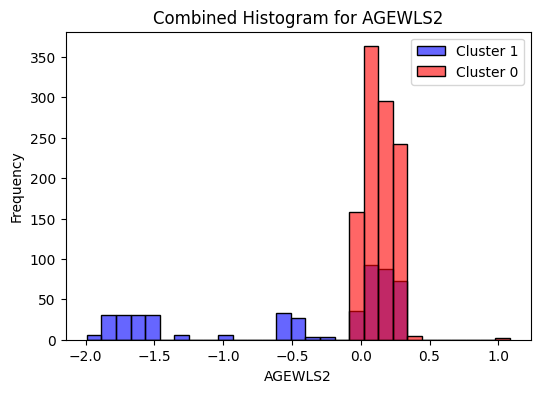

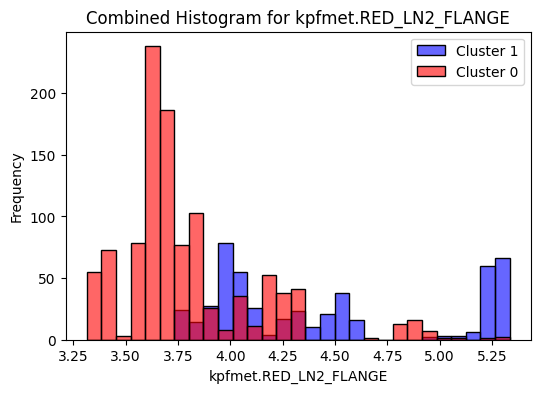

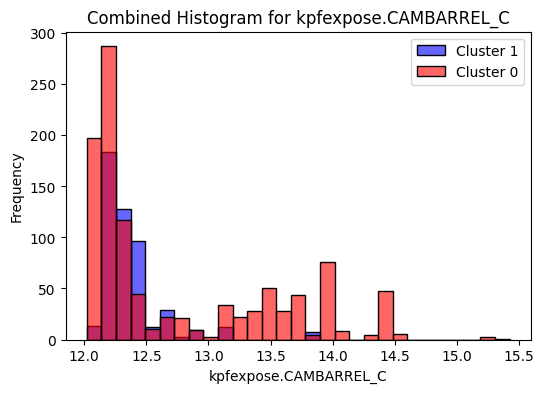

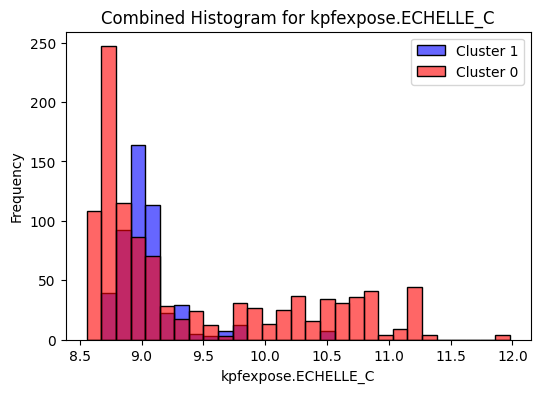

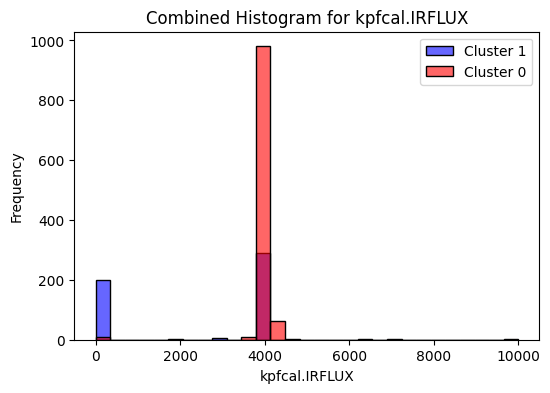

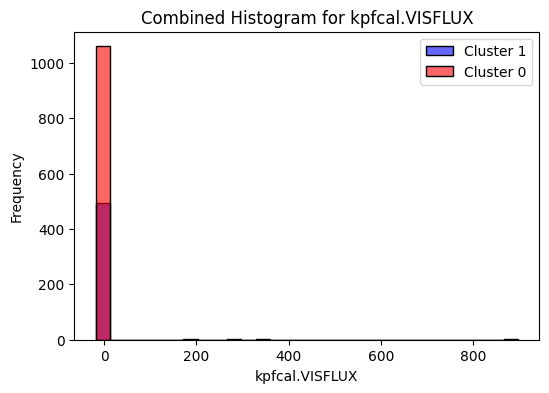

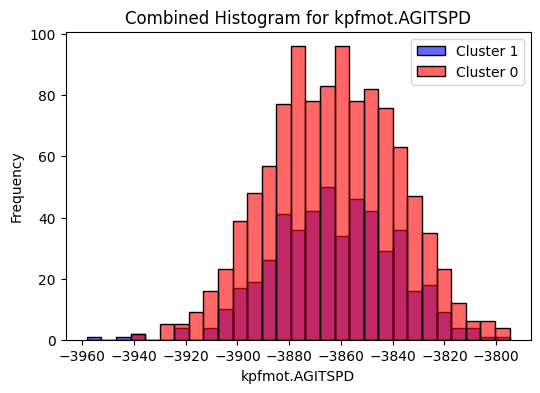

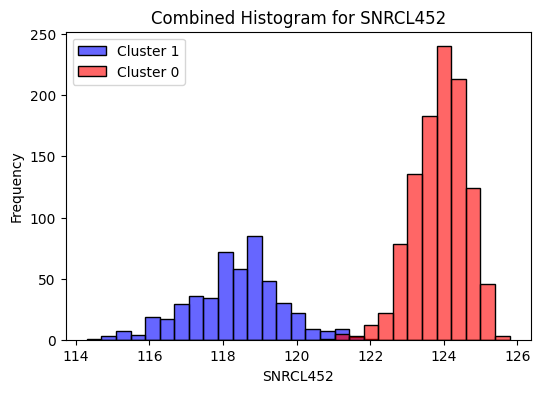

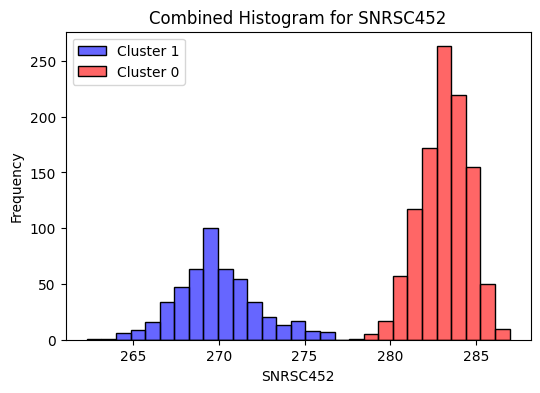

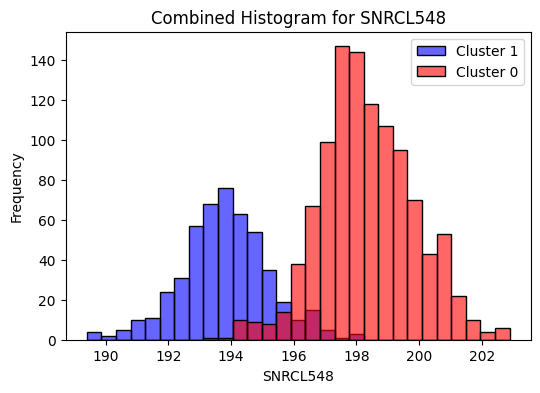

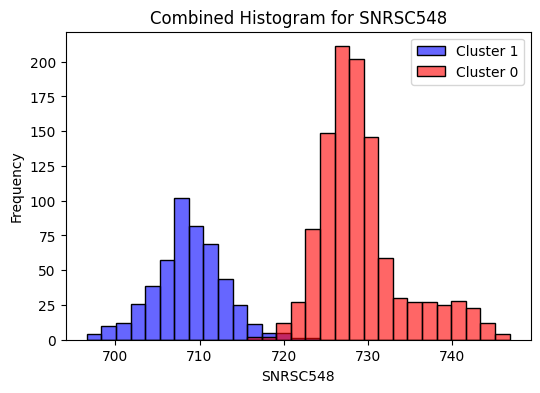

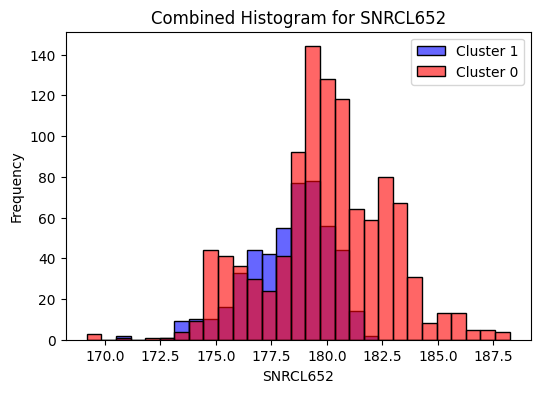

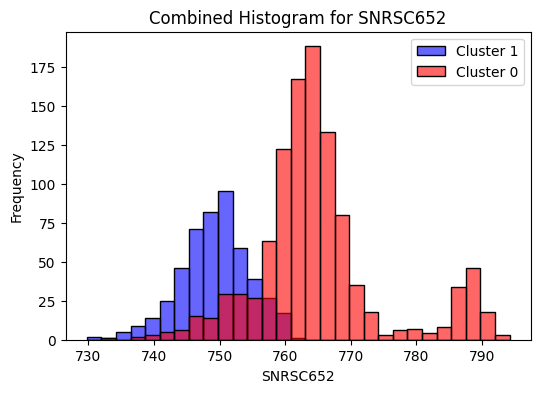

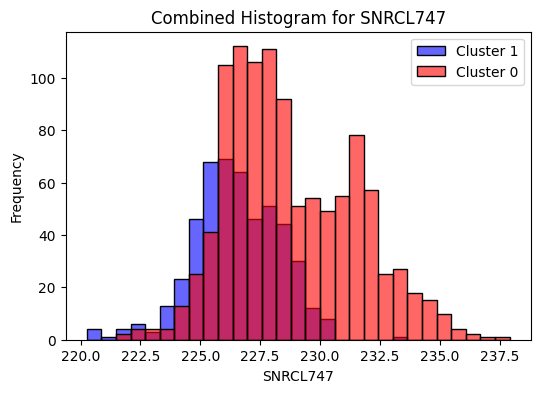

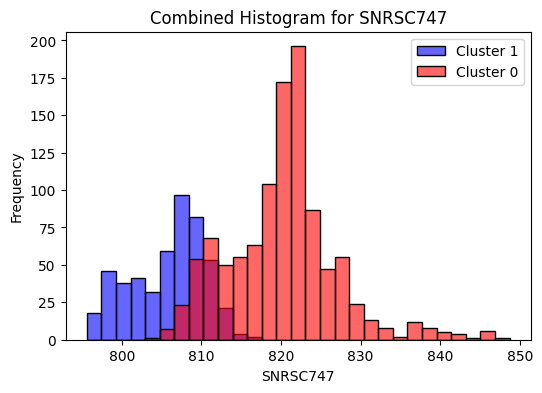

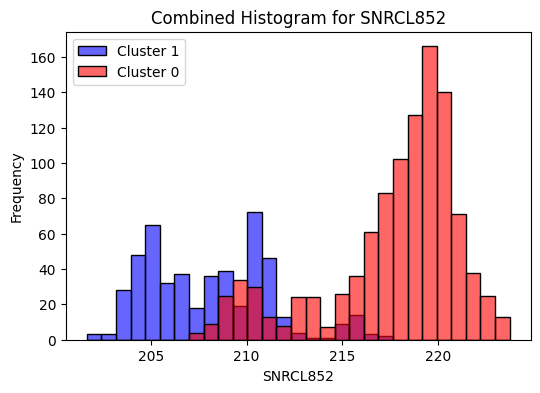

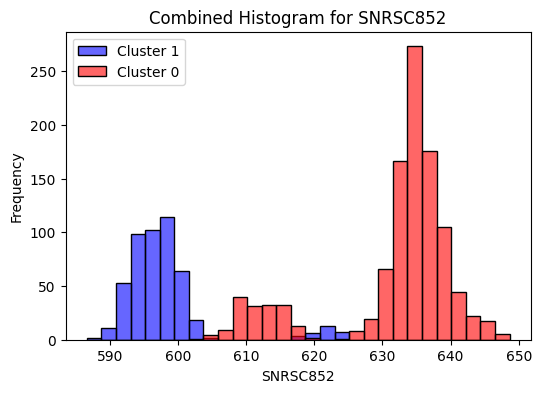

In [139]:
target_col = 'CCD1ERV'
df = df_v5_qc_etalon_low

qc_stats, num_stats, qc_differences, num_differences, cluster_ranges = analyze_sub_pop_stats(df=df,
                                                                                             target_col=target_col,
                                                                                             feature_cols_num=feature_cols_num + feature_cols_snr,
                                                                                             feature_cols_bool=feature_cols_qc,
                                                                                             n_components='bic')

display(qc_stats)
display(qc_differences)

display(num_stats)
display(num_differences)

print(cluster_ranges)

features = compare_sub_pop_stats(df=df,
                                 target_col=target_col,
                                 feature_cols_bool=feature_cols_qc,
                                 num_differences=num_differences,
                                 cluster_ranges=cluster_ranges,
                                 clusterA='1',
                                 clusterB='0')